In [11]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '4000.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '88.1816MHz', 'g13': '-4.5537MHz', 'g23': '83.6564MHz'}


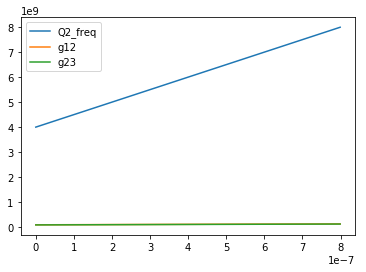

In [12]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0,7/7.0,800)
freq_array = 4e9+flux_pulse * (8e9 - 4e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',4e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.3e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',-0.0008)

raw_config.setValue('Q2 Voltage period',-2)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

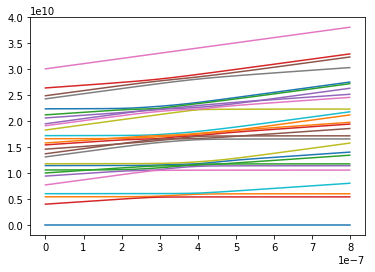

In [13]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=19e6)
Simulator.EigenResult.show_eigenenergy()
# eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
# plt.plot(freq_array,eigen_trace/1e6)

In [14]:
%matplotlib qt

In [15]:
def get_suppress_point(r1c,r2c,r12,Q1_freq,Q2_freq):
    g12 = r12*np.sqrt(Q1_freq*Q2_freq)
    Qc_arr = np.linspace(Q1_freq-0.4e9,Q1_freq-4e9,361)
    geff_arr = []
    for Qc in Qc_arr:
        g1cg2c = r2c*r1c*np.sqrt(Q1_freq*Q2_freq)*Qc
        geff = g12+g1cg2c/2*(1/(Q1_freq-Qc)+1/(Q2_freq-Qc)-1/(Q1_freq+Qc)-1/(Q2_freq+Qc)   )
        geff_arr.append(geff)
    geff_arr= np.array(geff_arr)
    return Qc_arr[np.argmin( np.abs(geff_arr))]
#     return geff_arr

# def r12_zero_geff(w1,w2,wc,r1c,r2c):
#     g1cg2c = np.sqrt(w1*wc)*r1c*np.sqrt(w2*wc)*r2c
#     g12 = -g1cg2c*(1/(w1-wc)+1/(w2-wc)-1/(w1+wc)-1/(w2+wc))/2
#     return g12/(np.sqrt(w1*w2))

In [16]:
get_suppress_point(0.018,0.018,-0.0008,5.4e9,5.8e9)

4140000000.0

In [17]:
def cost_func(pulse_params,*args):
    gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 5.4e9+detuning
    coupler_freq = get_suppress_point(0.018,0.018,-0.0008,5.4e9,q2_freq)

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=5.4e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq=q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=-0.0008,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=True,dfdV=8e9-coupler_freq,gap_threshold=16e6,freqpoints=801,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
#     Seq.add_filter('Reflection',*(0.02,3e-9))
    flux_pulse=Seq.get_sequence()
        

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',5.4e9)
    raw_config.setValue('Q2 f01_max',9e9)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',coupler_freq)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*coupler_anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',-0.0008)
    
    raw_config.setValue('Q2 Voltage period',-2)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('lamb:',lamb1)
#     print('error:',1-fidelity)
    return 1 - fidelity

In [18]:
gate_time=30e-9
coupler_anhar=-300e6
detuning=600e6
SRATE=6e9
q2_freq = 5.4e9+detuning
coupler_freq = get_suppress_point(0.018,0.018,-0.0008,5.4e9,q2_freq)

lamb1 = -2
total_len = gate_time + 10e-9


Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=5.4e9,
             CPLR_idle_freq=coupler_freq,Q2_freq=q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=-0.0008,anhar_CPLR=coupler_anhar,
             anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=True,dfdV=8e9-coupler_freq,gap_threshold=20e6,freqpoints=801,pulsepoints=601)
# Seq.add_filter('Gauss Low Pass',300e6)
#     Seq.add_filter('Reflection',*(0.02,3e-9))
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

In [19]:
coupler_freq

4190000000.0

In [ ]:

BBQ_error = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_error_anhar_Total.txt')
BBQ_lambda = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_lambda_anhar_Total.txt')



In [37]:
%matplotlib inline

In [58]:
SRATE=6e9
gate_time=30e-9

# anhar_arr = np.linspace(-800e6,400e6,61)
# detuning_arr = np.linspace(20e6,1.2e9,60)


anhar_arr = np.arange(-800e6,51e6,10e6)
detuning_arr = np.arange(300e6,1.201e9,10e6)

anhar_arr2 = np.arange(-800e6,401e6,10e6)
detuning_arr2 = np.arange(10e6,1.201e9,10e6)

Adia_error=np.zeros([len(anhar_arr2),len(detuning_arr2)])
Adia_lambda=np.zeros([len(anhar_arr2),len(detuning_arr2)])

# raw_initial_seeds=[1]
ii=0
for anhar_coupler in anhar_arr:
    jj=29
    for detuning in detuning_arr:
        time_start = time.time()
        raw_initial_seeds = [PARAM_ALL[ii,jj]]
        DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,anhar_coupler,detuning,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':10e-5,'xtol':10e-5,'maxiter': 16})
#         raw_initial_seeds =[max(DATA.x[0]*0.96,0.6)]  
        Adia_error[ii,jj] = DATA.fun
        Adia_lambda[ii,jj] = DATA.x
        print(time.time()-time_start)
        jj+=1
    ii+=1
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Simu_NonAdiaError.txt',Adia_error)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Simu_Parameters.txt',Adia_lambda)

lamb: [1.07304688]
lamb: [1.12669922]
lamb: [1.01939453]
lamb: [1.0462207]
lamb: [1.01939453]
lamb: [1.05963379]
lamb: [1.03280762]
lamb: [1.05292725]
lamb: [1.05963379]
lamb: [1.04957397]
lamb: [1.0462207]
lamb: [1.05125061]
lamb: [1.05292725]
lamb: [1.05041229]
lamb: [1.04957397]
lamb: [1.05083145]
lamb: [1.04999313]
lamb: [1.04957397]
lamb: [1.04957397]
lamb: [1.05020271]
lamb: [1.05041229]
lamb: [1.05009792]
lamb: [1.05009792]
lamb: [1.0503075]
lamb: [1.05041229]
lamb: [1.05041229]
lamb: [1.05025511]
lamb: [1.05025511]
Optimization terminated successfully.
         Current function value: 0.022523
         Iterations: 13
         Function evaluations: 28
48.84051012992859
lamb: [0.93945312]
lamb: [0.98642578]
lamb: [0.89248047]
lamb: [0.9159668]
lamb: [0.89248047]
lamb: [0.92770996]
lamb: [0.90422363]
lamb: [0.92183838]
lamb: [0.92770996]
lamb: [0.91890259]
lamb: [0.92477417]
lamb: [0.92037048]
lamb: [0.92330627]
lamb: [0.92110443]
lamb: [0.92037048]
lamb: [0.92147141]
lamb: [0.920

lamb: [0.49397461]
lamb: [0.51930664]
lamb: [0.50030762]
lamb: [0.49397461]
lamb: [0.50347412]
lamb: [0.49714111]
lamb: [0.50189087]
lamb: [0.49872437]
lamb: [0.50109924]
lamb: [0.50189087]
lamb: [0.50070343]
lamb: [0.50030762]
lamb: [0.50090134]
lamb: [0.50109924]
lamb: [0.50080238]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 9
         Function evaluations: 18
30.854827880859375
lamb: [0.49921875]
lamb: [0.52417969]
lamb: [0.47425781]
lamb: [0.48673828]
lamb: [0.51169922]
lamb: [0.49297852]
lamb: [0.48673828]
lamb: [0.49609863]
lamb: [0.4898584]
lamb: [0.49453857]
lamb: [0.49141846]
lamb: [0.49375854]
lamb: [0.49453857]
lamb: [0.49336853]
lamb: [0.49297852]
lamb: [0.49356354]
lamb: [0.49375854]
lamb: [0.49346603]
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 9
         Function evaluations: 18
31.01566195487976
lamb: [0.49296875]
lamb: [0.51761719]
lamb: [0.46832031]
lamb: 

lamb: [0.46328125]
lamb: [0.48644531]
lamb: [0.44011719]
lamb: [0.45169922]
lamb: [0.47486328]
lamb: [0.45749023]
lamb: [0.45169922]
lamb: [0.46038574]
lamb: [0.45459473]
lamb: [0.45893799]
lamb: [0.46038574]
lamb: [0.45821411]
lamb: [0.45749023]
lamb: [0.45857605]
lamb: [0.45893799]
lamb: [0.45839508]
lamb: [0.45875702]
lamb: [0.45848557]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
30.986459732055664
lamb: [0.46445312]
lamb: [0.48767578]
lamb: [0.44123047]
lamb: [0.4528418]
lamb: [0.47606445]
lamb: [0.45864746]
lamb: [0.4528418]
lamb: [0.46155029]
lamb: [0.45574463]
lamb: [0.46009888]
lamb: [0.46155029]
lamb: [0.45937317]
lamb: [0.45864746]
lamb: [0.45973602]
lamb: [0.45901031]
lamb: [0.4595546]
lamb: [0.45919174]
lamb: [0.45946388]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 18
31.37020444869995
lamb: [0

lamb: [0.51348145]
lamb: [0.51429199]
lamb: [0.51368408]
lamb: [0.51408936]
lamb: [0.5137854]
lamb: [0.51398804]
lamb: [0.51383606]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
34.494263648986816
lamb: [0.52460937]
lamb: [0.55083984]
lamb: [0.49837891]
lamb: [0.51149414]
lamb: [0.53772461]
lamb: [0.51805176]
lamb: [0.51149414]
lamb: [0.52133057]
lamb: [0.52460937]
lamb: [0.51969116]
lamb: [0.51805176]
lamb: [0.52051086]
lamb: [0.51887146]
lamb: [0.52010101]
lamb: [0.51928131]
lamb: [0.51989609]
lamb: [0.51948624]
lamb: [0.51979362]
lamb: [0.51989609]
lamb: [0.51974239]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
34.64003324508667
lamb: [0.53046875]
lamb: [0.55699219]
lamb: [0.50394531]
lamb: [0.51720703]
lamb: [0.54373047]
lamb: [0.52383789]
lamb: [0.51720703]
lamb: [0.52715332]
lamb: [0.53046875]
lamb

lamb: [0.63710937]
lamb: [0.66896484]
lamb: [0.60525391]
lamb: [0.62118164]
lamb: [0.65303711]
lamb: [0.62914551]
lamb: [0.62118164]
lamb: [0.63312744]
lamb: [0.63710937]
lamb: [0.63113647]
lamb: [0.63511841]
lamb: [0.63213196]
lamb: [0.63113647]
lamb: [0.6326297]
lamb: [0.63163422]
lamb: [0.63238083]
lamb: [0.63188309]
lamb: [0.63225639]
lamb: [0.63238083]
lamb: [0.63219418]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.67471766471863
lamb: [0.64609375]
lamb: [0.67839844]
lamb: [0.61378906]
lamb: [0.62994141]
lamb: [0.66224609]
lamb: [0.63801758]
lamb: [0.62994141]
lamb: [0.64205566]
lamb: [0.64609375]
lamb: [0.64003662]
lamb: [0.64407471]
lamb: [0.64104614]
lamb: [0.64003662]
lamb: [0.6415509]
lamb: [0.64054138]
lamb: [0.64129852]
lamb: [0.6415509]
lamb: [0.64117233]
lamb: [0.64104614]
lamb: [0.64123543]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.77997681]
lamb: [0.77814301]
lamb: [0.77936554]
lamb: [0.77844864]
lamb: [0.77814301]
lamb: [0.77860146]
lamb: [0.77829582]
lamb: [0.77852505]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.59577012062073
lamb: [0.79257812]
lamb: [0.83220703]
lamb: [0.75294922]
lamb: [0.77276367]
lamb: [0.81239258]
lamb: [0.7826709]
lamb: [0.80248535]
lamb: [0.78762451]
lamb: [0.7826709]
lamb: [0.79010132]
lamb: [0.78514771]
lamb: [0.78886292]
lamb: [0.79010132]
lamb: [0.78824371]
lamb: [0.78948212]
lamb: [0.78855331]
lamb: [0.78917252]
lamb: [0.78870811]
lamb: [0.78855331]
lamb: [0.78878551]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.664790630340576
lamb: [0.80273437]
lamb: [0.84287109]
lamb: [0.76259766]
lamb: [0.78266602]
lamb: [0.82280273]
lamb: [0.7927002]
lamb: [0.81276855]
lamb: [0.79771729]
lamb: 

lamb: [0.76291199]
lamb: [0.76260864]
lamb: [0.76306366]
lamb: [0.76321533]
lamb: [0.76298782]
Optimization terminated successfully.
         Current function value: 0.001984
         Iterations: 10
         Function evaluations: 20
34.51905941963196
lamb: [0.72421875]
lamb: [0.76042969]
lamb: [0.68800781]
lamb: [0.70611328]
lamb: [0.68800781]
lamb: [0.71516602]
lamb: [0.72421875]
lamb: [0.71063965]
lamb: [0.70611328]
lamb: [0.71290283]
lamb: [0.71516602]
lamb: [0.71177124]
lamb: [0.71403442]
lamb: [0.71233704]
lamb: [0.71346863]
lamb: [0.71261993]
lamb: [0.71318573]
lamb: [0.71276138]
lamb: [0.71261993]
lamb: [0.71283211]
Optimization terminated successfully.
         Current function value: 0.002169
         Iterations: 10
         Function evaluations: 20
40.87921690940857
lamb: [0.6828125]
lamb: [0.71695312]
lamb: [0.64867187]
lamb: [0.66574219]
lamb: [0.64867187]
lamb: [0.67427734]
lamb: [0.6828125]
lamb: [0.67000977]
lamb: [0.67854492]
lamb: [0.67214355]
lamb: [0.67000977]
lamb: 

lamb: [0.47188477]
lamb: [0.49608398]
lamb: [0.47793457]
lamb: [0.47188477]
lamb: [0.48095947]
lamb: [0.47490967]
lamb: [0.47944702]
lamb: [0.47642212]
lamb: [0.4786908]
lamb: [0.47944702]
lamb: [0.47831268]
lamb: [0.47906891]
lamb: [0.47850174]
lamb: [0.47887985]
lamb: [0.47859627]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 9
         Function evaluations: 18
31.670919179916382
lamb: [0.48007812]
lamb: [0.50408203]
lamb: [0.45607422]
lamb: [0.46807617]
lamb: [0.49208008]
lamb: [0.47407715]
lamb: [0.46807617]
lamb: [0.47707764]
lamb: [0.47107666]
lamb: [0.47557739]
lamb: [0.4725769]
lamb: [0.47482727]
lamb: [0.47557739]
lamb: [0.47445221]
lamb: [0.47407715]
lamb: [0.47463974]
lamb: [0.47426468]
lamb: [0.47454597]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 9
         Function evaluations: 18
31.722745418548584
lamb: [0.4765625]
lamb: [0.50039062]
lamb: [0.45273437]
lamb: [

lamb: [0.46564674]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
31.34155035018921
lamb: [0.47265625]
lamb: [0.49628906]
lamb: [0.44902344]
lamb: [0.46083984]
lamb: [0.48447266]
lamb: [0.46674805]
lamb: [0.46083984]
lamb: [0.46970215]
lamb: [0.46379395]
lamb: [0.4682251]
lamb: [0.46970215]
lamb: [0.46748657]
lamb: [0.46896362]
lamb: [0.46785583]
lamb: [0.46748657]
lamb: [0.46804047]
lamb: [0.4676712]
lamb: [0.46794815]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
31.915520429611206
lamb: [0.47539062]
lamb: [0.49916016]
lamb: [0.45162109]
lamb: [0.46350586]
lamb: [0.48727539]
lamb: [0.46944824]
lamb: [0.46350586]
lamb: [0.47241943]
lamb: [0.46647705]
lamb: [0.47093384]
lamb: [0.47241943]
lamb: [0.47019104]
lamb: [0.47167664]
lamb: [0.47056244]
lamb: [0.47019104]
lamb: [0.47074814]
lamb: [0.47037674]
lamb: [

lamb: [0.55]
lamb: [0.5775]
lamb: [0.5225]
lamb: [0.53625]
lamb: [0.56375]
lamb: [0.543125]
lamb: [0.53625]
lamb: [0.5465625]
lamb: [0.55]
lamb: [0.54484375]
lamb: [0.543125]
lamb: [0.54570312]
lamb: [0.5465625]
lamb: [0.54527344]
lamb: [0.54484375]
lamb: [0.54548828]
lamb: [0.54505859]
lamb: [0.54538086]
lamb: [0.54548828]
lamb: [0.54532715]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.04409599304199
lamb: [0.55703125]
lamb: [0.58488281]
lamb: [0.52917969]
lamb: [0.54310547]
lamb: [0.57095703]
lamb: [0.55006836]
lamb: [0.54310547]
lamb: [0.5535498]
lamb: [0.55703125]
lamb: [0.55180908]
lamb: [0.55006836]
lamb: [0.55267944]
lamb: [0.5535498]
lamb: [0.55224426]
lamb: [0.55180908]
lamb: [0.55246185]
lamb: [0.55202667]
lamb: [0.55235306]
lamb: [0.55246185]
lamb: [0.55229866]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function

lamb: [0.66751099]
lamb: [0.66909027]
lamb: [0.6696167]
lamb: [0.66882706]
lamb: [0.66935349]
lamb: [0.66895866]
lamb: [0.66882706]
lamb: [0.66902447]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.68236303329468
lamb: [0.68320312]
lamb: [0.71736328]
lamb: [0.64904297]
lamb: [0.66612305]
lamb: [0.7002832]
lamb: [0.67466309]
lamb: [0.66612305]
lamb: [0.67893311]
lamb: [0.68320312]
lamb: [0.6767981]
lamb: [0.68106812]
lamb: [0.6778656]
lamb: [0.68000061]
lamb: [0.67839935]
lamb: [0.6778656]
lamb: [0.67866623]
lamb: [0.67813248]
lamb: [0.67853279]
lamb: [0.67866623]
lamb: [0.67846607]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.68569469451904
lamb: [0.69257812]
lamb: [0.72720703]
lamb: [0.65794922]
lamb: [0.67526367]
lamb: [0.70989258]
lamb: [0.6839209]
lamb: [0.67526367]
lamb: [0.68824951]
lamb: [0.6

lamb: [0.83242187]
lamb: [0.87404297]
lamb: [0.79080078]
lamb: [0.81161133]
lamb: [0.85323242]
lamb: [0.8220166]
lamb: [0.84282715]
lamb: [0.82721924]
lamb: [0.8220166]
lamb: [0.82982056]
lamb: [0.83242187]
lamb: [0.8285199]
lamb: [0.82721924]
lamb: [0.82917023]
lamb: [0.82982056]
lamb: [0.82884506]
lamb: [0.8285199]
lamb: [0.82900764]
lamb: [0.82868248]
lamb: [0.82892635]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
34.88960099220276
lamb: [0.8421875]
lamb: [0.88429687]
lamb: [0.80007812]
lamb: [0.82113281]
lamb: [0.86324219]
lamb: [0.83166016]
lamb: [0.85271484]
lamb: [0.83692383]
lamb: [0.83166016]
lamb: [0.83955566]
lamb: [0.8421875]
lamb: [0.83823975]
lamb: [0.83692383]
lamb: [0.83889771]
lamb: [0.83955566]
lamb: [0.83856873]
lamb: [0.83823975]
lamb: [0.83873322]
lamb: [0.83840424]
lamb: [0.83865097]
Optimization terminated successfully.
         Current function value: 0.000001
         I

lamb: [0.59189453]
lamb: [0.61525879]
lamb: [0.62304687]
lamb: [0.61136475]
lamb: [0.61915283]
lamb: [0.61331177]
lamb: [0.61720581]
lamb: [0.61428528]
lamb: [0.61331177]
lamb: [0.61477203]
lamb: [0.61525879]
lamb: [0.61452866]
lamb: [0.61501541]
lamb: [0.61465034]
lamb: [0.61489372]
lamb: [0.61471119]
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 10
         Function evaluations: 20
35.03736710548401
lamb: [0.60039062]
lamb: [0.63041016]
lamb: [0.57037109]
lamb: [0.58538086]
lamb: [0.57037109]
lamb: [0.59288574]
lamb: [0.60039062]
lamb: [0.5891333]
lamb: [0.59663818]
lamb: [0.59100952]
lamb: [0.59476196]
lamb: [0.59194763]
lamb: [0.59382385]
lamb: [0.59241669]
lamb: [0.59194763]
lamb: [0.59265121]
lamb: [0.59288574]
lamb: [0.59253395]
lamb: [0.59241669]
lamb: [0.59259258]
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 10
         Function evaluations: 20
34.85379672050476
lamb:

lamb: [0.49710937]
lamb: [0.44976562]
lamb: [0.46160156]
lamb: [0.48527344]
lamb: [0.46751953]
lamb: [0.46160156]
lamb: [0.47047852]
lamb: [0.46456055]
lamb: [0.46899902]
lamb: [0.46604004]
lamb: [0.46825928]
lamb: [0.46899902]
lamb: [0.4678894]
lamb: [0.46862915]
lamb: [0.46807434]
lamb: [0.4678894]
lamb: [0.46816681]
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 9
         Function evaluations: 18
31.360108852386475
lamb: [0.47148437]
lamb: [0.49505859]
lamb: [0.44791016]
lamb: [0.45969727]
lamb: [0.48327148]
lamb: [0.46559082]
lamb: [0.45969727]
lamb: [0.4685376]
lamb: [0.46264404]
lamb: [0.46706421]
lamb: [0.46411743]
lamb: [0.46632751]
lamb: [0.46706421]
lamb: [0.46595917]
lamb: [0.46669586]
lamb: [0.46614334]
lamb: [0.46595917]
lamb: [0.46623543]
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 9
         Function evaluations: 18
30.83959460258484
lamb: [0.46992187]
lamb: [0

lamb: [0.48081238]
lamb: [0.48109711]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
30.93921208381653
lamb: [0.48945312]
lamb: [0.51392578]
lamb: [0.46498047]
lamb: [0.4772168]
lamb: [0.50168945]
lamb: [0.48333496]
lamb: [0.4772168]
lamb: [0.48639404]
lamb: [0.48027588]
lamb: [0.4848645]
lamb: [0.48639404]
lamb: [0.48409973]
lamb: [0.48562927]
lamb: [0.48524689]
lamb: [0.48448212]
lamb: [0.48467331]
lamb: [0.48505569]
lamb: [0.48476891]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 9
         Function evaluations: 18
31.21713161468506
lamb: [0.49375]
lamb: [0.5184375]
lamb: [0.4690625]
lamb: [0.48140625]
lamb: [0.50609375]
lamb: [0.48757812]
lamb: [0.48140625]
lamb: [0.49066406]
lamb: [0.48449219]
lamb: [0.48912109]
lamb: [0.49066406]
lamb: [0.48834961]
lamb: [0.48989258]
lamb: [0.48873535]
lamb: [0.48950684]
lamb: [0.48892822]
lamb: [0.48931

lamb: [0.57477112]
lamb: [0.57296082]
lamb: [0.57431854]
lamb: [0.57477112]
lamb: [0.57409225]
lamb: [0.57454483]
lamb: [0.5742054]
lamb: [0.57443169]
lamb: [0.57426197]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.63957333564758
lamb: [0.58671875]
lamb: [0.61605469]
lamb: [0.55738281]
lamb: [0.57205078]
lamb: [0.60138672]
lamb: [0.57938477]
lamb: [0.57205078]
lamb: [0.58305176]
lamb: [0.58671875]
lamb: [0.58121826]
lamb: [0.57938477]
lamb: [0.58213501]
lamb: [0.58305176]
lamb: [0.58167664]
lamb: [0.58259338]
lamb: [0.58190582]
lamb: [0.5823642]
lamb: [0.58202042]
lamb: [0.58190582]
lamb: [0.58207771]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.7948157787323
lamb: [0.59492187]
lamb: [0.62466797]
lamb: [0.56517578]
lamb: [0.58004883]
lamb: [0.60979492]
lamb: [0.58748535]
lamb: [0.58004883]
lamb: [

lamb: [0.72226562]
lamb: [0.75837891]
lamb: [0.68615234]
lamb: [0.70420898]
lamb: [0.74032227]
lamb: [0.7132373]
lamb: [0.73129395]
lamb: [0.71775146]
lamb: [0.7132373]
lamb: [0.72000854]
lamb: [0.71549438]
lamb: [0.71888]
lamb: [0.71662292]
lamb: [0.71831573]
lamb: [0.71718719]
lamb: [0.7180336]
lamb: [0.71746933]
lamb: [0.71789253]
lamb: [0.7180336]
lamb: [0.717822]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.4572274684906
lamb: [0.73242187]
lamb: [0.76904297]
lamb: [0.69580078]
lamb: [0.71411133]
lamb: [0.75073242]
lamb: [0.7232666]
lamb: [0.71411133]
lamb: [0.72784424]
lamb: [0.73242187]
lamb: [0.72555542]
lamb: [0.73013306]
lamb: [0.72669983]
lamb: [0.72898865]
lamb: [0.72727203]
lamb: [0.72841644]
lamb: [0.72755814]
lamb: [0.72813034]
lamb: [0.72770119]
lamb: [0.72798729]
lamb: [0.72777271]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterat

lamb: [0.86623291]
lamb: [0.86895264]
lamb: [0.86691284]
lamb: [0.86623291]
lamb: [0.86725281]
lamb: [0.86657288]
lamb: [0.86708282]
lamb: [0.86725281]
lamb: [0.86699783]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
34.686713218688965
lamb: [0.87929687]
lamb: [0.92326172]
lamb: [0.83533203]
lamb: [0.85731445]
lamb: [0.9012793]
lamb: [0.86830566]
lamb: [0.89028809]
lamb: [0.87380127]
lamb: [0.86830566]
lamb: [0.87654907]
lamb: [0.87929687]
lamb: [0.87517517]
lamb: [0.87792297]
lamb: [0.87586212]
lamb: [0.87723602]
lamb: [0.8762056]
lamb: [0.87586212]
lamb: [0.87637733]
lamb: [0.87603386]
lamb: [0.87629147]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
34.632317304611206
lamb: [0.88789062]
lamb: [0.93228516]
lamb: [0.84349609]
lamb: [0.86569336]
lamb: [0.91008789]
lamb: [0.87679199]
lamb: [0.89898926]
lamb

lamb: [0.55943848]
lamb: [0.5576709]
lamb: [0.55899658]
lamb: [0.55811279]
lamb: [0.55877563]
lamb: [0.55833374]
lamb: [0.55866516]
lamb: [0.55877563]
lamb: [0.55860992]
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 10
         Function evaluations: 20
34.5798077583313
lamb: [0.5515625]
lamb: [0.57914062]
lamb: [0.52398437]
lamb: [0.53777344]
lamb: [0.56535156]
lamb: [0.54466797]
lamb: [0.53777344]
lamb: [0.54811523]
lamb: [0.5412207]
lamb: [0.5463916]
lamb: [0.54294434]
lamb: [0.54552979]
lamb: [0.54380615]
lamb: [0.54509888]
lamb: [0.54552979]
lamb: [0.54488342]
lamb: [0.54466797]
lamb: [0.54499115]
lamb: [0.5447757]
lamb: [0.54493729]
Optimization terminated successfully.
         Current function value: 0.000075
         Iterations: 10
         Function evaluations: 20
34.88332176208496
lamb: [0.5390625]
lamb: [0.56601562]
lamb: [0.51210937]
lamb: [0.52558594]
lamb: [0.55253906]
lamb: [0.53232422]
lamb: [0.52558594]
lamb: [0.53

lamb: [0.46612518]
lamb: [0.46649323]
lamb: [0.46621719]
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 9
         Function evaluations: 18
31.402852058410645
lamb: [0.47070312]
lamb: [0.49423828]
lamb: [0.44716797]
lamb: [0.45893555]
lamb: [0.4824707]
lamb: [0.46481934]
lamb: [0.45893555]
lamb: [0.46776123]
lamb: [0.46187744]
lamb: [0.46629028]
lamb: [0.46776123]
lamb: [0.46555481]
lamb: [0.46481934]
lamb: [0.46592255]
lamb: [0.46518707]
lamb: [0.46573868]
lamb: [0.46592255]
lamb: [0.46564674]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 9
         Function evaluations: 18
31.131402730941772
lamb: [0.4703125]
lamb: [0.49382812]
lamb: [0.44679687]
lamb: [0.45855469]
lamb: [0.48207031]
lamb: [0.46443359]
lamb: [0.45855469]
lamb: [0.46737305]
lamb: [0.46149414]
lamb: [0.46590332]
lamb: [0.46737305]
lamb: [0.46516846]
lamb: [0.46443359]
lamb: [0.46553589]
lamb: [0.46590332]
lamb: 

lamb: [0.49587891]
lamb: [0.52130859]
lamb: [0.50223633]
lamb: [0.49587891]
lamb: [0.50541504]
lamb: [0.49905762]
lamb: [0.50382568]
lamb: [0.50541504]
lamb: [0.50303101]
lamb: [0.50462036]
lamb: [0.50342834]
lamb: [0.50422302]
lamb: [0.50362701]
lamb: [0.50402435]
lamb: [0.50372635]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 9
         Function evaluations: 18
84.53045415878296
lamb: [0.51367187]
lamb: [0.53935547]
lamb: [0.48798828]
lamb: [0.50083008]
lamb: [0.52651367]
lamb: [0.50725098]
lamb: [0.50083008]
lamb: [0.51046143]
lamb: [0.51367187]
lamb: [0.5088562]
lamb: [0.50725098]
lamb: [0.50965881]
lamb: [0.50805359]
lamb: [0.50925751]
lamb: [0.5084549]
lamb: [0.50905685]
lamb: [0.50925751]
lamb: [0.50895653]
lamb: [0.50915718]
lamb: [0.50900669]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
109.67799806594849
lamb: [0.51914062]
lamb: 

lamb: [0.60607452]
lamb: [0.60643272]
lamb: [0.60619392]
lamb: [0.60637302]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
73.21307492256165
lamb: [0.61953125]
lamb: [0.65050781]
lamb: [0.58855469]
lamb: [0.60404297]
lamb: [0.63501953]
lamb: [0.61178711]
lamb: [0.60404297]
lamb: [0.61565918]
lamb: [0.61953125]
lamb: [0.61372314]
lamb: [0.61759521]
lamb: [0.61469116]
lamb: [0.61372314]
lamb: [0.61517517]
lamb: [0.61420715]
lamb: [0.61493317]
lamb: [0.61444916]
lamb: [0.61481216]
lamb: [0.61493317]
lamb: [0.61475166]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
73.38995933532715
lamb: [0.628125]
lamb: [0.65953125]
lamb: [0.59671875]
lamb: [0.61242187]
lamb: [0.64382812]
lamb: [0.62027344]
lamb: [0.61242187]
lamb: [0.62419922]
lamb: [0.628125]
lamb: [0.62223633]
lamb: [0.62616211]
lamb: [0.62321777]
lamb: [0

lamb: [0.7625]
lamb: [0.800625]
lamb: [0.724375]
lamb: [0.7434375]
lamb: [0.7815625]
lamb: [0.75296875]
lamb: [0.77203125]
lamb: [0.75773437]
lamb: [0.75296875]
lamb: [0.76011719]
lamb: [0.75535156]
lamb: [0.75892578]
lamb: [0.76011719]
lamb: [0.75833008]
lamb: [0.75773437]
lamb: [0.75862793]
lamb: [0.75803223]
lamb: [0.758479]
lamb: [0.75818115]
lamb: [0.75840454]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
99.55917572975159
lamb: [0.77265625]
lamb: [0.81128906]
lamb: [0.73402344]
lamb: [0.75333984]
lamb: [0.79197266]
lamb: [0.76299805]
lamb: [0.78231445]
lamb: [0.76782715]
lamb: [0.76299805]
lamb: [0.7702417]
lamb: [0.7654126]
lamb: [0.76903442]
lamb: [0.7702417]
lamb: [0.76843079]
lamb: [0.76782715]
lamb: [0.7687326]
lamb: [0.76903442]
lamb: [0.7685817]
lamb: [0.76843079]
lamb: [0.76865715]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 

lamb: [0.90327393]
lamb: [0.90044678]
lamb: [0.90256714]
lamb: [0.90115356]
lamb: [0.90221375]
lamb: [0.90150696]
lamb: [0.90203705]
lamb: [0.90221375]
lamb: [0.9019487]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
49.72376275062561
lamb: [0.9125]
lamb: [0.958125]
lamb: [0.866875]
lamb: [0.8896875]
lamb: [0.9353125]
lamb: [0.90109375]
lamb: [0.92390625]
lamb: [0.90679687]
lamb: [0.91820312]
lamb: [0.90964844]
lamb: [0.90679687]
lamb: [0.91107422]
lamb: [0.90822266]
lamb: [0.91036133]
lamb: [0.90893555]
lamb: [0.91000488]
lamb: [0.91036133]
lamb: [0.90982666]
lamb: [0.91018311]
lamb: [0.90991577]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
48.16401243209839
lamb: [1.07148438]
lamb: [1.12505859]
lamb: [1.01791016]
lamb: [1.04469727]
lamb: [1.01791016]
lamb: [1.05809082]
lamb: [1.03130371]
lamb: [1.051394

lamb: [0.52472168]
lamb: [0.52348022]
lamb: [0.52430786]
lamb: [0.52368713]
lamb: [0.52348022]
lamb: [0.52379059]
lamb: [0.52389404]
lamb: [0.52373886]
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 10
         Function evaluations: 20
61.25710153579712
lamb: [0.5203125]
lamb: [0.54632812]
lamb: [0.49429687]
lamb: [0.50730469]
lamb: [0.53332031]
lamb: [0.51380859]
lamb: [0.50730469]
lamb: [0.51706055]
lamb: [0.51055664]
lamb: [0.51543457]
lamb: [0.51218262]
lamb: [0.51462158]
lamb: [0.51543457]
lamb: [0.51421509]
lamb: [0.51502808]
lamb: [0.51441833]
lamb: [0.51482483]
lamb: [0.51451996]
lamb: [0.51472321]
lamb: [0.51457077]
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 10
         Function evaluations: 20
62.407047748565674
lamb: [0.5125]
lamb: [0.538125]
lamb: [0.486875]
lamb: [0.4996875]
lamb: [0.5253125]
lamb: [0.50609375]
lamb: [0.4996875]
lamb: [0.50929687]
lamb: [0.502890

lamb: [0.47382812]
lamb: [0.49751953]
lamb: [0.45013672]
lamb: [0.46198242]
lamb: [0.48567383]
lamb: [0.46790527]
lamb: [0.46198242]
lamb: [0.4708667]
lamb: [0.46494385]
lamb: [0.46938599]
lamb: [0.4708667]
lamb: [0.46864563]
lamb: [0.46790527]
lamb: [0.46901581]
lamb: [0.46827545]
lamb: [0.46883072]
lamb: [0.46901581]
lamb: [0.46873817]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 9
         Function evaluations: 18
56.68952012062073
lamb: [0.47421875]
lamb: [0.49792969]
lamb: [0.45050781]
lamb: [0.46236328]
lamb: [0.48607422]
lamb: [0.46829102]
lamb: [0.46236328]
lamb: [0.47125488]
lamb: [0.46532715]
lamb: [0.46977295]
lamb: [0.47125488]
lamb: [0.46903198]
lamb: [0.47051392]
lamb: [0.46940247]
lamb: [0.46903198]
lamb: [0.46958771]
lamb: [0.46977295]
lamb: [0.46949509]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 9
         Function evaluations: 18
61.89948487281799
lamb: [0

lamb: [0.52626953]
lamb: [0.52460937]
lamb: [0.52709961]
lamb: [0.52543945]
lamb: [0.52668457]
lamb: [0.52709961]
lamb: [0.52647705]
lamb: [0.52626953]
lamb: [0.52658081]
lamb: [0.52637329]
lamb: [0.52652893]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
59.16405010223389
lamb: [0.5375]
lamb: [0.564375]
lamb: [0.510625]
lamb: [0.5240625]
lamb: [0.5509375]
lamb: [0.53078125]
lamb: [0.5240625]
lamb: [0.53414062]
lamb: [0.5375]
lamb: [0.53246094]
lamb: [0.53078125]
lamb: [0.53330078]
lamb: [0.53162109]
lamb: [0.53288086]
lamb: [0.53204102]
lamb: [0.5326709]
lamb: [0.53288086]
lamb: [0.53256592]
lamb: [0.53277588]
lamb: [0.53261841]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
60.79683756828308
lamb: [0.54375]
lamb: [0.5709375]
lamb: [0.5165625]
lamb: [0.53015625]
lamb: [0.55734375]
lamb: [0.53695312]
lamb: 

lamb: [0.65507812]
lamb: [0.68783203]
lamb: [0.62232422]
lamb: [0.63870117]
lamb: [0.67145508]
lamb: [0.64688965]
lamb: [0.63870117]
lamb: [0.65098389]
lamb: [0.65507812]
lamb: [0.64893677]
lamb: [0.65303101]
lamb: [0.64996033]
lamb: [0.64893677]
lamb: [0.65047211]
lamb: [0.65098389]
lamb: [0.65021622]
lamb: [0.650728]
lamb: [0.65034416]
lamb: [0.65021622]
lamb: [0.65040813]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.902345180511475
lamb: [0.66445312]
lamb: [0.69767578]
lamb: [0.63123047]
lamb: [0.6478418]
lamb: [0.68106445]
lamb: [0.65614746]
lamb: [0.6478418]
lamb: [0.66030029]
lamb: [0.66445312]
lamb: [0.65822388]
lamb: [0.66237671]
lamb: [0.65926208]
lamb: [0.65822388]
lamb: [0.65978119]
lamb: [0.66030029]
lamb: [0.65952164]
lamb: [0.65926208]
lamb: [0.65965141]
lamb: [0.65939186]
lamb: [0.65958652]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.80061523]
lamb: [0.79873291]
lamb: [0.79998779]
lamb: [0.79904663]
lamb: [0.79967407]
lamb: [0.79920349]
lamb: [0.79904663]
lamb: [0.79928192]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
38.86530876159668
lamb: [0.81289062]
lamb: [0.85353516]
lamb: [0.77224609]
lamb: [0.79256836]
lamb: [0.83321289]
lamb: [0.80272949]
lamb: [0.82305176]
lamb: [0.80781006]
lamb: [0.80272949]
lamb: [0.81035034]
lamb: [0.81289062]
lamb: [0.8090802]
lamb: [0.80781006]
lamb: [0.80971527]
lamb: [0.80844513]
lamb: [0.80939774]
lamb: [0.80971527]
lamb: [0.80923897]
lamb: [0.8090802]
lamb: [0.80931835]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
38.18933916091919
lamb: [0.82304687]
lamb: [0.86419922]
lamb: [0.78189453]
lamb: [0.8024707]
lamb: [0.84362305]
lamb: [0.81275879]
lamb: [0.83333496]
lamb: [0.81790283]
lamb: [

lamb: [0.92085472]
lamb: [0.92122108]
lamb: [0.92112949]
Optimization terminated successfully.
         Current function value: 0.004049
         Iterations: 10
         Function evaluations: 20
37.46991229057312
lamb: [0.8453125]
lamb: [0.88757812]
lamb: [0.80304687]
lamb: [0.82417969]
lamb: [0.80304687]
lamb: [0.83474609]
lamb: [0.8453125]
lamb: [0.82946289]
lamb: [0.82417969]
lamb: [0.83210449]
lamb: [0.82682129]
lamb: [0.83078369]
lamb: [0.83210449]
lamb: [0.83012329]
lamb: [0.83144409]
lamb: [0.83045349]
lamb: [0.83012329]
lamb: [0.83061859]
lamb: [0.83028839]
lamb: [0.83037094]
lamb: [0.83053604]
Optimization terminated successfully.
         Current function value: 0.000653
         Iterations: 10
         Function evaluations: 21
39.16426181793213
lamb: [0.7765625]
lamb: [0.81539062]
lamb: [0.73773437]
lamb: [0.75714844]
lamb: [0.73773437]
lamb: [0.76685547]
lamb: [0.7765625]
lamb: [0.76200195]
lamb: [0.75714844]
lamb: [0.76442871]
lamb: [0.76685547]
lamb: [0.76321533]
lamb: [0

lamb: [0.52623047]
lamb: [0.47611328]
lamb: [0.48864258]
lamb: [0.51370117]
lamb: [0.49490723]
lamb: [0.48864258]
lamb: [0.49803955]
lamb: [0.4917749]
lamb: [0.49647339]
lamb: [0.49803955]
lamb: [0.49569031]
lamb: [0.49490723]
lamb: [0.49608185]
lamb: [0.49647339]
lamb: [0.49588608]
lamb: [0.49569031]
lamb: [0.49598396]
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 9
         Function evaluations: 18
35.15160250663757
lamb: [0.49609375]
lamb: [0.52089844]
lamb: [0.47128906]
lamb: [0.48369141]
lamb: [0.50849609]
lamb: [0.48989258]
lamb: [0.48369141]
lamb: [0.49299316]
lamb: [0.48679199]
lamb: [0.49144287]
lamb: [0.49299316]
lamb: [0.49066772]
lamb: [0.48989258]
lamb: [0.4910553]
lamb: [0.49028015]
lamb: [0.49086151]
lamb: [0.49047394]
lamb: [0.49076462]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 18
34.67514109611511
lamb: [0.49179687]
lamb: [0

lamb: [0.47578781]
lamb: [0.47606956]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
34.42017483711243
lamb: [0.48320312]
lamb: [0.50736328]
lamb: [0.45904297]
lamb: [0.47112305]
lamb: [0.4952832]
lamb: [0.47716309]
lamb: [0.47112305]
lamb: [0.48018311]
lamb: [0.47414307]
lamb: [0.4786731]
lamb: [0.48018311]
lamb: [0.47791809]
lamb: [0.4794281]
lamb: [0.47829559]
lamb: [0.47791809]
lamb: [0.47848434]
lamb: [0.47810684]
lamb: [0.47838997]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 9
         Function evaluations: 18
34.77944350242615
lamb: [0.48554687]
lamb: [0.50982422]
lamb: [0.46126953]
lamb: [0.4734082]
lamb: [0.49768555]
lamb: [0.47947754]
lamb: [0.4734082]
lamb: [0.48251221]
lamb: [0.47644287]
lamb: [0.48099487]
lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.48175354]
lamb: [0.48061554]
lamb: [0.48137421]
lamb: [0.48080521]
lamb: [0.48

lamb: [0.55285538]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
38.406447410583496
lamb: [0.56445312]
lamb: [0.59267578]
lamb: [0.53623047]
lamb: [0.5503418]
lamb: [0.57856445]
lamb: [0.55739746]
lamb: [0.5503418]
lamb: [0.56092529]
lamb: [0.56445312]
lamb: [0.55916138]
lamb: [0.55739746]
lamb: [0.56004333]
lamb: [0.56092529]
lamb: [0.55960236]
lamb: [0.55916138]
lamb: [0.55982285]
lamb: [0.56004333]
lamb: [0.5597126]
lamb: [0.55993309]
lamb: [0.55976772]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.55700421333313
lamb: [0.571875]
lamb: [0.60046875]
lamb: [0.54328125]
lamb: [0.55757812]
lamb: [0.58617187]
lamb: [0.56472656]
lamb: [0.55757812]
lamb: [0.56830078]
lamb: [0.571875]
lamb: [0.56651367]
lamb: [0.56472656]
lamb: [0.56740723]
lamb: [0.56830078]
lamb: [0.56696045]
lamb: [0.56651367]
lamb: [0.5

lamb: [0.72761719]
lamb: [0.65832031]
lamb: [0.67564453]
lamb: [0.71029297]
lamb: [0.68430664]
lamb: [0.67564453]
lamb: [0.6886377]
lamb: [0.69296875]
lamb: [0.68647217]
lamb: [0.69080322]
lamb: [0.68755493]
lamb: [0.68972046]
lamb: [0.68809631]
lamb: [0.68755493]
lamb: [0.688367]
lamb: [0.6886377]
lamb: [0.68823166]
lamb: [0.68850235]
lamb: [0.68829933]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.92505145072937
lamb: [0.70273437]
lamb: [0.73787109]
lamb: [0.66759766]
lamb: [0.68516602]
lamb: [0.72030273]
lamb: [0.6939502]
lamb: [0.68516602]
lamb: [0.69834229]
lamb: [0.70273437]
lamb: [0.69614624]
lamb: [0.70053833]
lamb: [0.69724426]
lamb: [0.69944031]
lamb: [0.69779327]
lamb: [0.69724426]
lamb: [0.69806778]
lamb: [0.69834229]
lamb: [0.69793053]
lamb: [0.69820503]
lamb: [0.69799915]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
    

lamb: [0.8412616]
lamb: [0.8392868]
lamb: [0.83862854]
lamb: [0.83961594]
lamb: [0.83895767]
lamb: [0.83945137]
lamb: [0.83912224]
lamb: [0.83936909]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.25758957862854
lamb: [0.85234375]
lamb: [0.89496094]
lamb: [0.80972656]
lamb: [0.83103516]
lamb: [0.87365234]
lamb: [0.84168945]
lamb: [0.86299805]
lamb: [0.8470166]
lamb: [0.84168945]
lamb: [0.84968018]
lamb: [0.85234375]
lamb: [0.84834839]
lamb: [0.8470166]
lamb: [0.84901428]
lamb: [0.84968018]
lamb: [0.84868134]
lamb: [0.84934723]
lamb: [0.84884781]
lamb: [0.84918076]
lamb: [0.84893105]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.22271966934204
lamb: [0.86171875]
lamb: [0.90480469]
lamb: [0.81863281]
lamb: [0.84017578]
lamb: [0.88326172]
lamb: [0.85094727]
lamb: [0.87249023]
lamb: [0.85633301]
lamb: [0

lamb: [0.71433975]
lamb: [0.71377304]
lamb: [0.71419807]
lamb: [0.71433975]
lamb: [0.71412724]
Optimization terminated successfully.
         Current function value: 0.002238
         Iterations: 10
         Function evaluations: 20
38.12742495536804
lamb: [0.684375]
lamb: [0.71859375]
lamb: [0.65015625]
lamb: [0.66726562]
lamb: [0.65015625]
lamb: [0.67582031]
lamb: [0.684375]
lamb: [0.67154297]
lamb: [0.68009766]
lamb: [0.67368164]
lamb: [0.67154297]
lamb: [0.67475098]
lamb: [0.67582031]
lamb: [0.67421631]
lamb: [0.67528564]
lamb: [0.67448364]
lamb: [0.67421631]
lamb: [0.67461731]
lamb: [0.67434998]
lamb: [0.67455048]
Optimization terminated successfully.
         Current function value: 0.001108
         Iterations: 10
         Function evaluations: 20
38.62540674209595
lamb: [0.65234375]
lamb: [0.68496094]
lamb: [0.61972656]
lamb: [0.63603516]
lamb: [0.61972656]
lamb: [0.64418945]
lamb: [0.65234375]
lamb: [0.6401123]
lamb: [0.6482666]
lamb: [0.64215088]
lamb: [0.64622803]
lamb: [0.6

lamb: [0.50249023]
lamb: [0.48410645]
lamb: [0.47797852]
lamb: [0.48717041]
lamb: [0.48104248]
lamb: [0.48563843]
lamb: [0.48717041]
lamb: [0.48487244]
lamb: [0.48410645]
lamb: [0.48525543]
lamb: [0.48563843]
lamb: [0.48506393]
lamb: [0.48487244]
lamb: [0.48515968]
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 9
         Function evaluations: 18
34.93161201477051
lamb: [0.4875]
lamb: [0.511875]
lamb: [0.463125]
lamb: [0.4753125]
lamb: [0.4996875]
lamb: [0.48140625]
lamb: [0.4753125]
lamb: [0.48445312]
lamb: [0.47835937]
lamb: [0.48292969]
lamb: [0.48445312]
lamb: [0.48216797]
lamb: [0.48140625]
lamb: [0.48254883]
lamb: [0.48178711]
lamb: [0.4823584]
lamb: [0.48197754]
lamb: [0.48226318]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 9
         Function evaluations: 18
34.26955723762512
lamb: [0.48476562]
lamb: [0.50900391]
lamb: [0.46052734]
lamb: [0.47264648]
lamb: [0.49688477]

lamb: [0.496875]
lamb: [0.52171875]
lamb: [0.47203125]
lamb: [0.48445312]
lamb: [0.50929687]
lamb: [0.49066406]
lamb: [0.48445312]
lamb: [0.49376953]
lamb: [0.48755859]
lamb: [0.4922168]
lamb: [0.49376953]
lamb: [0.49144043]
lamb: [0.49299316]
lamb: [0.49182861]
lamb: [0.49260498]
lamb: [0.49202271]
lamb: [0.49241089]
lamb: [0.49211975]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 9
         Function evaluations: 18
34.35174632072449
lamb: [0.50078125]
lamb: [0.52582031]
lamb: [0.47574219]
lamb: [0.48826172]
lamb: [0.51330078]
lamb: [0.49452148]
lamb: [0.48826172]
lamb: [0.49765137]
lamb: [0.50078125]
lamb: [0.49608643]
lamb: [0.49452148]
lamb: [0.4968689]
lamb: [0.49530396]
lamb: [0.49647766]
lamb: [0.49569519]
lamb: [0.49628204]
lamb: [0.49589081]
lamb: [0.49618423]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
35.807262659072876
lamb: [0.

lamb: [0.58217857]
lamb: [0.58235058]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.89689898490906
lamb: [0.59492187]
lamb: [0.62466797]
lamb: [0.56517578]
lamb: [0.58004883]
lamb: [0.60979492]
lamb: [0.58748535]
lamb: [0.58004883]
lamb: [0.59120361]
lamb: [0.59492187]
lamb: [0.58934448]
lamb: [0.58748535]
lamb: [0.59027405]
lamb: [0.59120361]
lamb: [0.58980927]
lamb: [0.59073883]
lamb: [0.59004166]
lamb: [0.59050644]
lamb: [0.59015785]
lamb: [0.59039024]
lamb: [0.59021595]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
37.49488925933838
lamb: [0.603125]
lamb: [0.63328125]
lamb: [0.57296875]
lamb: [0.58804687]
lamb: [0.61820312]
lamb: [0.59558594]
lamb: [0.58804687]
lamb: [0.59935547]
lamb: [0.603125]
lamb: [0.5974707]
lamb: [0.59558594]
lamb: [0.59841309]
lamb: [0.59935547]
lamb: [0.59794189]
lamb: [0.

lamb: [0.7328125]
lamb: [0.76945312]
lamb: [0.69617187]
lamb: [0.71449219]
lamb: [0.75113281]
lamb: [0.72365234]
lamb: [0.71449219]
lamb: [0.72823242]
lamb: [0.7328125]
lamb: [0.72594238]
lamb: [0.73052246]
lamb: [0.7270874]
lamb: [0.72937744]
lamb: [0.72765991]
lamb: [0.72880493]
lamb: [0.72794617]
lamb: [0.72851868]
lamb: [0.72808929]
lamb: [0.72837555]
lamb: [0.72816086]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.980355739593506
lamb: [0.74257812]
lamb: [0.77970703]
lamb: [0.70544922]
lamb: [0.72401367]
lamb: [0.76114258]
lamb: [0.7332959]
lamb: [0.75186035]
lamb: [0.73793701]
lamb: [0.7332959]
lamb: [0.74025757]
lamb: [0.73561646]
lamb: [0.73909729]
lamb: [0.73677673]
lamb: [0.73851715]
lamb: [0.73909729]
lamb: [0.73822708]
lamb: [0.73793701]
lamb: [0.73837212]
lamb: [0.73808205]
lamb: [0.73815456]
Optimization terminated successfully.
         Current function value: 0.000000
        

lamb: [0.88007812]
lamb: [0.87595276]
lamb: [0.878703]
lamb: [0.87664032]
lamb: [0.87801544]
lamb: [0.8769841]
lamb: [0.87664032]
lamb: [0.87715599]
lamb: [0.87732788]
lamb: [0.87707005]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
37.203064918518066
lamb: [0.8890625]
lamb: [0.93351563]
lamb: [0.84460937]
lamb: [0.86683594]
lamb: [0.91128906]
lamb: [0.87794922]
lamb: [0.90017578]
lamb: [0.88350586]
lamb: [0.87794922]
lamb: [0.88628418]
lamb: [0.8890625]
lamb: [0.88489502]
lamb: [0.88767334]
lamb: [0.8855896]
lamb: [0.88697876]
lamb: [0.88593689]
lamb: [0.8855896]
lamb: [0.88611053]
lamb: [0.88628418]
lamb: [0.88602371]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
37.00028038024902
lamb: [0.89726562]
lamb: [0.94212891]
lamb: [0.85240234]
lamb: [0.87483398]
lamb: [0.91969727]
lamb: [0.8860498]
lamb: [0.90

lamb: [0.61921997]
lamb: [0.61848572]
lamb: [0.61897522]
lamb: [0.61860809]
lamb: [0.61848572]
lamb: [0.61866928]
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 10
         Function evaluations: 20
37.9165735244751
lamb: [0.6046875]
lamb: [0.63492187]
lamb: [0.57445312]
lamb: [0.58957031]
lamb: [0.57445312]
lamb: [0.59712891]
lamb: [0.6046875]
lamb: [0.59334961]
lamb: [0.6009082]
lamb: [0.59901855]
lamb: [0.59523926]
lamb: [0.59807373]
lamb: [0.59618408]
lamb: [0.59760132]
lamb: [0.59665649]
lamb: [0.59736511]
lamb: [0.5968927]
lamb: [0.59724701]
lamb: [0.5970108]
lamb: [0.59718796]
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 10
         Function evaluations: 20
38.37581491470337
lamb: [0.58632812]
lamb: [0.61564453]
lamb: [0.55701172]
lamb: [0.57166992]
lamb: [0.60098633]
lamb: [0.57899902]
lamb: [0.57166992]
lamb: [0.58266357]
lamb: [0.57533447]
lamb: [0.5808313]
lamb: [0.57

lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.48175354]
lamb: [0.48061554]
lamb: [0.48023621]
lamb: [0.48080521]
lamb: [0.48042587]
lamb: [0.48071037]
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 9
         Function evaluations: 18
34.77547311782837
lamb: [0.48398437]
lamb: [0.50818359]
lamb: [0.45978516]
lamb: [0.47188477]
lamb: [0.49608398]
lamb: [0.47793457]
lamb: [0.47188477]
lamb: [0.48095947]
lamb: [0.47490967]
lamb: [0.47944702]
lamb: [0.48095947]
lamb: [0.4786908]
lamb: [0.48020325]
lamb: [0.47906891]
lamb: [0.4786908]
lamb: [0.47925797]
lamb: [0.47887985]
lamb: [0.47916344]
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 9
         Function evaluations: 18
35.91963744163513
lamb: [0.48320312]
lamb: [0.50736328]
lamb: [0.45904297]
lamb: [0.47112305]
lamb: [0.4952832]
lamb: [0.47716309]
lamb: [0.47112305]
lamb: [0.48018311]
lamb: [0.47414307]
lamb: [0.4786731]
lamb: [0.4

lamb: [0.515625]
lamb: [0.54140625]
lamb: [0.48984375]
lamb: [0.50273437]
lamb: [0.52851562]
lamb: [0.50917969]
lamb: [0.50273437]
lamb: [0.51240234]
lamb: [0.515625]
lamb: [0.51079102]
lamb: [0.50917969]
lamb: [0.51159668]
lamb: [0.50998535]
lamb: [0.51119385]
lamb: [0.51038818]
lamb: [0.51099243]
lamb: [0.5105896]
lamb: [0.51089172]
lamb: [0.51069031]
lamb: [0.51084137]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
39.44233775138855
lamb: [0.52070312]
lamb: [0.54673828]
lamb: [0.49466797]
lamb: [0.50768555]
lamb: [0.5337207]
lamb: [0.51419434]
lamb: [0.50768555]
lamb: [0.51744873]
lamb: [0.52070312]
lamb: [0.51582153]
lamb: [0.51419434]
lamb: [0.51663513]
lamb: [0.51500793]
lamb: [0.51622833]
lamb: [0.51663513]
lamb: [0.51602493]
lamb: [0.51643173]
lamb: [0.51612663]
lamb: [0.51602493]
lamb: [0.51617748]
Optimization terminated successfully.
         Current function value: 0.000006
         I

lamb: [0.61507874]
lamb: [0.61604736]
lamb: [0.61459442]
lamb: [0.61556305]
lamb: [0.61483658]
lamb: [0.61532089]
lamb: [0.61519981]
lamb: [0.61495766]
lamb: [0.6150182]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
36.23727750778198
lamb: [0.62851562]
lamb: [0.65994141]
lamb: [0.59708984]
lamb: [0.61280273]
lamb: [0.64422852]
lamb: [0.62065918]
lamb: [0.61280273]
lamb: [0.6245874]
lamb: [0.62851562]
lamb: [0.62262329]
lamb: [0.62655151]
lamb: [0.62360535]
lamb: [0.62262329]
lamb: [0.62409637]
lamb: [0.62311432]
lamb: [0.62385086]
lamb: [0.62409637]
lamb: [0.6237281]
lamb: [0.62360535]
lamb: [0.62378948]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.6015088558197
lamb: [0.6375]
lamb: [0.669375]
lamb: [0.605625]
lamb: [0.6215625]
lamb: [0.6534375]
lamb: [0.62953125]
lamb: [0.6215625]
lamb: [0.63351562]


lamb: [0.7734375]
lamb: [0.81210937]
lamb: [0.73476562]
lamb: [0.75410156]
lamb: [0.79277344]
lamb: [0.76376953]
lamb: [0.78310547]
lamb: [0.76860352]
lamb: [0.76376953]
lamb: [0.77102051]
lamb: [0.76618652]
lamb: [0.76981201]
lamb: [0.76739502]
lamb: [0.76920776]
lamb: [0.76981201]
lamb: [0.76890564]
lamb: [0.76950989]
lamb: [0.7690567]
lamb: [0.76935883]
lamb: [0.76913223]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
36.085124492645264
lamb: [0.78359375]
lamb: [0.82277344]
lamb: [0.74441406]
lamb: [0.76400391]
lamb: [0.80318359]
lamb: [0.77379883]
lamb: [0.79338867]
lamb: [0.77869629]
lamb: [0.77379883]
lamb: [0.78114502]
lamb: [0.77624756]
lamb: [0.77992065]
lamb: [0.78114502]
lamb: [0.77930847]
lamb: [0.77869629]
lamb: [0.77961456]
lamb: [0.77900238]
lamb: [0.77946152]
lamb: [0.77915543]
lamb: [0.77938499]
Optimization terminated successfully.
         Current function value: 0.000000
     

lamb: [0.90796143]
lamb: [0.91224426]
lamb: [0.90938904]
lamb: [0.91153046]
lamb: [0.91224426]
lamb: [0.91117355]
lamb: [0.91081665]
lamb: [0.91135201]
lamb: [0.9109951]
lamb: [0.91126278]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
39.69604420661926
lamb: [0.92148438]
lamb: [0.96755859]
lamb: [0.87541016]
lamb: [0.89844727]
lamb: [0.94452148]
lamb: [0.90996582]
lamb: [0.93300293]
lamb: [0.9157251]
lamb: [0.92724365]
lamb: [0.91860474]
lamb: [0.9157251]
lamb: [0.92004456]
lamb: [0.91716492]
lamb: [0.91932465]
lamb: [0.91788483]
lamb: [0.91896469]
lamb: [0.91932465]
lamb: [0.91878471]
lamb: [0.91914467]
lamb: [0.9188747]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
46.30630683898926
lamb: [0.92890625]
lamb: [0.97535156]
lamb: [0.88246094]
lamb: [0.90568359]
lamb: [0.95212891]
lamb: [0.91729492]
lamb: [0

lamb: [0.56255493]
lamb: [0.56523376]
lamb: [0.56612671]
lamb: [0.56478729]
lamb: [0.56568024]
lamb: [0.56501053]
lamb: [0.56478729]
lamb: [0.56512215]
lamb: [0.56523376]
lamb: [0.56506634]
Optimization terminated successfully.
         Current function value: 0.000188
         Iterations: 10
         Function evaluations: 20
36.493539810180664
lamb: [0.55820312]
lamb: [0.58611328]
lamb: [0.53029297]
lamb: [0.54424805]
lamb: [0.5721582]
lamb: [0.55122559]
lamb: [0.54424805]
lamb: [0.55471436]
lamb: [0.54773682]
lamb: [0.55296997]
lamb: [0.5494812]
lamb: [0.55209778]
lamb: [0.55296997]
lamb: [0.55166168]
lamb: [0.55253387]
lamb: [0.55187973]
lamb: [0.55231583]
lamb: [0.55198875]
lamb: [0.5522068]
lamb: [0.55204327]
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 10
         Function evaluations: 20
38.60765838623047
lamb: [0.54648437]
lamb: [0.57380859]
lamb: [0.51916016]
lamb: [0.53282227]
lamb: [0.56014648]
lamb: [0.53965332]
lamb: 

lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.48175354]
lamb: [0.48061554]
lamb: [0.48023621]
lamb: [0.48080521]
lamb: [0.48042587]
lamb: [0.48071037]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 9
         Function evaluations: 18
37.58602595329285
lamb: [0.48554687]
lamb: [0.50982422]
lamb: [0.46126953]
lamb: [0.4734082]
lamb: [0.49768555]
lamb: [0.47947754]
lamb: [0.4734082]
lamb: [0.48251221]
lamb: [0.47644287]
lamb: [0.48099487]
lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.47947754]
lamb: [0.48061554]
lamb: [0.48099487]
lamb: [0.48042587]
lamb: [0.48080521]
lamb: [0.48052071]
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 9
         Function evaluations: 18
36.677547216415405
lamb: [0.48554687]
lamb: [0.50982422]
lamb: [0.46126953]
lamb: [0.4734082]
lamb: [0.49768555]
lamb: [0.47947754]
lamb: [0.4734082]
lamb: [0.48251221]
lamb: [0.47644287]
lamb: [0.48099487]
lamb: [0.

lamb: [0.52779438]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
37.5361225605011
lamb: [0.53867187]
lamb: [0.56560547]
lamb: [0.51173828]
lamb: [0.52520508]
lamb: [0.55213867]
lamb: [0.53193848]
lamb: [0.52520508]
lamb: [0.53530518]
lamb: [0.53867187]
lamb: [0.53362183]
lamb: [0.53193848]
lamb: [0.5344635]
lamb: [0.53278015]
lamb: [0.53404266]
lamb: [0.5344635]
lamb: [0.53383224]
lamb: [0.53362183]
lamb: [0.53393745]
lamb: [0.53404266]
lamb: [0.53388485]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
40.30063843727112
lamb: [0.54492187]
lamb: [0.57216797]
lamb: [0.51767578]
lamb: [0.53129883]
lamb: [0.55854492]
lamb: [0.53811035]
lamb: [0.53129883]
lamb: [0.54151611]
lamb: [0.54492187]
lamb: [0.53981323]
lamb: [0.53811035]
lamb: [0.54066467]
lamb: [0.54151611]
lamb: [0.54023895]
lamb: [0.53981323]
lamb: [

lamb: [0.62269531]
lamb: [0.63908203]
lamb: [0.67185547]
lamb: [0.64727539]
lamb: [0.63908203]
lamb: [0.65137207]
lamb: [0.65546875]
lamb: [0.64932373]
lamb: [0.65342041]
lamb: [0.6503479]
lamb: [0.64932373]
lamb: [0.65085999]
lamb: [0.65137207]
lamb: [0.65060394]
lamb: [0.6503479]
lamb: [0.65073196]
lamb: [0.65085999]
lamb: [0.65066795]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
37.950496435165405
lamb: [0.66484375]
lamb: [0.69808594]
lamb: [0.63160156]
lamb: [0.64822266]
lamb: [0.68146484]
lamb: [0.6565332]
lamb: [0.64822266]
lamb: [0.66068848]
lamb: [0.66484375]
lamb: [0.65861084]
lamb: [0.66276611]
lamb: [0.65964966]
lamb: [0.65861084]
lamb: [0.66016907]
lamb: [0.66068848]
lamb: [0.65990936]
lamb: [0.65964966]
lamb: [0.66003922]
lamb: [0.66016907]
lamb: [0.65997429]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function ev

lamb: [0.80139404]
lamb: [0.79950989]
lamb: [0.80076599]
lamb: [0.79982391]
lamb: [0.80045197]
lamb: [0.79998093]
lamb: [0.79982391]
lamb: [0.80005943]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
40.16889977455139
lamb: [0.8140625]
lamb: [0.85476562]
lamb: [0.77335937]
lamb: [0.79371094]
lamb: [0.83441406]
lamb: [0.80388672]
lamb: [0.82423828]
lamb: [0.80897461]
lamb: [0.80388672]
lamb: [0.81151855]
lamb: [0.80643066]
lamb: [0.81024658]
lamb: [0.81151855]
lamb: [0.8096106]
lamb: [0.81088257]
lamb: [0.80992859]
lamb: [0.81056458]
lamb: [0.81008759]
lamb: [0.81040558]
lamb: [0.81016708]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.51539587974548
lamb: [0.82382812]
lamb: [0.86501953]
lamb: [0.78263672]
lamb: [0.80323242]
lamb: [0.84442383]
lamb: [0.81353027]
lamb: [0.83412598]
lamb: [0.8186792]
lamb: [

lamb: [0.94335937]
lamb: [0.99052734]
lamb: [0.89619141]
lamb: [0.91977539]
lamb: [0.96694336]
lamb: [0.93156738]
lamb: [0.95515137]
lamb: [0.93746338]
lamb: [0.94925537]
lamb: [0.94041138]
lamb: [0.93746338]
lamb: [0.94188538]
lamb: [0.93893738]
lamb: [0.94114838]
lamb: [0.94188538]
lamb: [0.94077988]
lamb: [0.94151688]
lamb: [0.94096413]
lamb: [0.94077988]
lamb: [0.94105625]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
39.12177300453186
lamb: [0.95]
lamb: [0.9975]
lamb: [0.9025]
lamb: [0.92625]
lamb: [0.97375]
lamb: [0.938125]
lamb: [0.961875]
lamb: [0.9440625]
lamb: [0.9559375]
lamb: [0.94703125]
lamb: [0.9440625]
lamb: [0.94851562]
lamb: [0.95]
lamb: [0.94777344]
lamb: [0.94703125]
lamb: [0.94814453]
lamb: [0.94851562]
lamb: [0.94795898]
lamb: [0.94777344]
lamb: [0.94805176]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Func

lamb: [0.52482422]
lamb: [0.55173828]
lamb: [0.53155273]
lamb: [0.52482422]
lamb: [0.53491699]
lamb: [0.52818848]
lamb: [0.53323486]
lamb: [0.53491699]
lamb: [0.5323938]
lamb: [0.53155273]
lamb: [0.53281433]
lamb: [0.53323486]
lamb: [0.53260406]
lamb: [0.5323938]
lamb: [0.5327092]
lamb: [0.53249893]
lamb: [0.53265663]
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 10
         Function evaluations: 20
39.259082555770874
lamb: [0.5296875]
lamb: [0.55617187]
lamb: [0.50320312]
lamb: [0.51644531]
lamb: [0.54292969]
lamb: [0.52306641]
lamb: [0.51644531]
lamb: [0.52637695]
lamb: [0.51975586]
lamb: [0.52472168]
lamb: [0.52637695]
lamb: [0.52389404]
lamb: [0.52306641]
lamb: [0.52430786]
lamb: [0.52348022]
lamb: [0.52410095]
lamb: [0.52430786]
lamb: [0.5239975]
lamb: [0.52389404]
lamb: [0.52404922]
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 10
         Function evaluations: 20
38.6228

lamb: [0.48678223]
lamb: [0.48448608]
lamb: [0.48601685]
lamb: [0.48486877]
lamb: [0.48448608]
lamb: [0.48506012]
lamb: [0.48467743]
lamb: [0.48496445]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
36.219642639160156
lamb: [0.49101562]
lamb: [0.51556641]
lamb: [0.46646484]
lamb: [0.47874023]
lamb: [0.50329102]
lamb: [0.48487793]
lamb: [0.47874023]
lamb: [0.48794678]
lamb: [0.48180908]
lamb: [0.48641235]
lamb: [0.48794678]
lamb: [0.48564514]
lamb: [0.48717957]
lamb: [0.48602875]
lamb: [0.48679596]
lamb: [0.48622055]
lamb: [0.48602875]
lamb: [0.48631645]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 9
         Function evaluations: 18
36.214807987213135
lamb: [0.49257812]
lamb: [0.51720703]
lamb: [0.46794922]
lamb: [0.48026367]
lamb: [0.50489258]
lamb: [0.4864209]
lamb: [0.48026367]
lamb: [0.48949951]
lamb: [0.48334229]
lamb: [0.48796021]
lamb:

lamb: [0.55335693]
lamb: [0.55161133]
lamb: [0.55422974]
lamb: [0.55248413]
lamb: [0.55379333]
lamb: [0.55422974]
lamb: [0.55357513]
lamb: [0.55401154]
lamb: [0.55368423]
lamb: [0.55390244]
lamb: [0.55384789]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
40.67373561859131
lamb: [0.565625]
lamb: [0.59390625]
lamb: [0.53734375]
lamb: [0.55148437]
lamb: [0.57976562]
lamb: [0.55855469]
lamb: [0.55148437]
lamb: [0.56208984]
lamb: [0.565625]
lamb: [0.56032227]
lamb: [0.55855469]
lamb: [0.56120605]
lamb: [0.56208984]
lamb: [0.56076416]
lamb: [0.56032227]
lamb: [0.56098511]
lamb: [0.56054321]
lamb: [0.56087463]
lamb: [0.56065369]
lamb: [0.5608194]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
40.389498472213745
lamb: [0.57265625]
lamb: [0.60128906]
lamb: [0.54402344]
lamb: [0.55833984]
lamb: [0.58697266]
lamb: [0

lamb: [0.67912102]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
40.95905256271362
lamb: [0.69335937]
lamb: [0.72802734]
lamb: [0.65869141]
lamb: [0.67602539]
lamb: [0.71069336]
lamb: [0.68469238]
lamb: [0.67602539]
lamb: [0.68902588]
lamb: [0.69335937]
lamb: [0.68685913]
lamb: [0.69119263]
lamb: [0.6879425]
lamb: [0.69010925]
lamb: [0.68848419]
lamb: [0.68956757]
lamb: [0.68875504]
lamb: [0.68848419]
lamb: [0.68889046]
lamb: [0.68861961]
lamb: [0.68882275]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
40.378071784973145
lamb: [0.703125]
lamb: [0.73828125]
lamb: [0.66796875]
lamb: [0.68554687]
lamb: [0.72070312]
lamb: [0.69433594]
lamb: [0.68554687]
lamb: [0.69873047]
lamb: [0.703125]
lamb: [0.6965332]
lamb: [0.70092773]
lamb: [0.69763184]
lamb: [0.6998291]
lamb: [0.69818115]
lamb: [0.69927979]
lamb: [0.6

lamb: [0.84375]
lamb: [0.8859375]
lamb: [0.8015625]
lamb: [0.82265625]
lamb: [0.86484375]
lamb: [0.83320312]
lamb: [0.85429687]
lamb: [0.83847656]
lamb: [0.83320312]
lamb: [0.84111328]
lamb: [0.84375]
lamb: [0.83979492]
lamb: [0.83847656]
lamb: [0.8404541]
lamb: [0.84111328]
lamb: [0.84012451]
lamb: [0.84078369]
lamb: [0.84028931]
lamb: [0.84012451]
lamb: [0.8403717]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.64865255355835
lamb: [0.85351562]
lamb: [0.89619141]
lamb: [0.81083984]
lamb: [0.83217773]
lamb: [0.87485352]
lamb: [0.84284668]
lamb: [0.86418457]
lamb: [0.84818115]
lamb: [0.84284668]
lamb: [0.85084839]
lamb: [0.85351562]
lamb: [0.84951477]
lamb: [0.84818115]
lamb: [0.85018158]
lamb: [0.85084839]
lamb: [0.84984818]
lamb: [0.85051498]
lamb: [0.85001488]
lamb: [0.84984818]
lamb: [0.85009823]
Optimization terminated successfully.
         Current function value: 0.000001
         Itera

lamb: [1.05268433]
lamb: [1.04933716]
lamb: [1.05184753]
lamb: [1.05017395]
lamb: [1.05142914]
lamb: [1.05184753]
lamb: [1.05121994]
lamb: [1.05101074]
lamb: [1.05132454]
lamb: [1.05142914]
lamb: [1.05127224]
lamb: [1.05127224]
Optimization terminated successfully.
         Current function value: 0.020589
         Iterations: 11
         Function evaluations: 23
46.39662027359009
lamb: [0.93867187]
lamb: [0.98560547]
lamb: [0.89173828]
lamb: [0.91520508]
lamb: [0.89173828]
lamb: [0.92693848]
lamb: [0.93867187]
lamb: [0.92107178]
lamb: [0.91520508]
lamb: [0.92400513]
lamb: [0.92693848]
lamb: [0.92253845]
lamb: [0.92107178]
lamb: [0.92327179]
lamb: [0.92180511]
lamb: [0.92217178]
lamb: [0.92290512]
lamb: [0.92235512]
lamb: [0.92272179]
lamb: [0.92290512]
lamb: [0.92290512]
lamb: [0.92263012]
lamb: [0.92263012]
Optimization terminated successfully.
         Current function value: 0.003023
         Iterations: 11
         Function evaluations: 23
48.64059042930603
lamb: [0.846875]
lamb: 

lamb: [0.51805176]
lamb: [0.51928131]
lamb: [0.51969116]
lamb: [0.51907639]
lamb: [0.51887146]
lamb: [0.51917885]
lamb: [0.51928131]
lamb: [0.51912762]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
119.0930826663971
lamb: [0.51796875]
lamb: [0.54386719]
lamb: [0.49207031]
lamb: [0.50501953]
lamb: [0.53091797]
lamb: [0.51149414]
lamb: [0.50501953]
lamb: [0.51473145]
lamb: [0.50825684]
lamb: [0.51311279]
lamb: [0.51473145]
lamb: [0.51230347]
lamb: [0.51392212]
lamb: [0.51270813]
lamb: [0.51230347]
lamb: [0.51291046]
lamb: [0.5125058]
lamb: [0.5128093]
lamb: [0.51260696]
lamb: [0.51275871]
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 10
         Function evaluations: 20
104.40416216850281
lamb: [0.51289062]
lamb: [0.53853516]
lamb: [0.48724609]
lamb: [0.50006836]
lamb: [0.52571289]
lamb: [0.50647949]
lamb: [0.50006836]
lamb: [0.50968506]
lamb:

lamb: [0.49921875]
lamb: [0.52417969]
lamb: [0.47425781]
lamb: [0.48673828]
lamb: [0.51169922]
lamb: [0.49297852]
lamb: [0.48673828]
lamb: [0.49609863]
lamb: [0.4898584]
lamb: [0.49453857]
lamb: [0.49609863]
lamb: [0.49375854]
lamb: [0.4953186]
lamb: [0.49414856]
lamb: [0.49492859]
lamb: [0.49434357]
lamb: [0.49473358]
lamb: [0.49444107]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 18
115.84168481826782
lamb: [0.50195312]
lamb: [0.52705078]
lamb: [0.47685547]
lamb: [0.4894043]
lamb: [0.51450195]
lamb: [0.49567871]
lamb: [0.4894043]
lamb: [0.49881592]
lamb: [0.4925415]
lamb: [0.49724731]
lamb: [0.49881592]
lamb: [0.49646301]
lamb: [0.49803162]
lamb: [0.49685516]
lamb: [0.49763947]
lamb: [0.49705124]
lamb: [0.49744339]
lamb: [0.49714928]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
103.51220297813416
lamb: [0.

lamb: [0.57570709]
lamb: [0.57553703]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
114.42393827438354
lamb: [0.58789062]
lamb: [0.61728516]
lamb: [0.55849609]
lamb: [0.57319336]
lamb: [0.60258789]
lamb: [0.58054199]
lamb: [0.57319336]
lamb: [0.58421631]
lamb: [0.58789062]
lamb: [0.58237915]
lamb: [0.58054199]
lamb: [0.58329773]
lamb: [0.58421631]
lamb: [0.58283844]
lamb: [0.58375702]
lamb: [0.58306808]
lamb: [0.58352737]
lamb: [0.58318291]
lamb: [0.58306808]
lamb: [0.58324032]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
104.92856431007385
lamb: [0.59570312]
lamb: [0.62548828]
lamb: [0.56591797]
lamb: [0.58081055]
lamb: [0.6105957]
lamb: [0.58825684]
lamb: [0.58081055]
lamb: [0.59197998]
lamb: [0.59570312]
lamb: [0.59011841]
lamb: [0.59384155]
lamb: [0.59104919]
lamb: [0.59011841]
lamb: [0.59151459]
lam

lamb: [0.72304687]
lamb: [0.75919922]
lamb: [0.68689453]
lamb: [0.7049707]
lamb: [0.74112305]
lamb: [0.71400879]
lamb: [0.73208496]
lamb: [0.71852783]
lamb: [0.71400879]
lamb: [0.72078735]
lamb: [0.71626831]
lamb: [0.71965759]
lamb: [0.71739807]
lamb: [0.71909271]
lamb: [0.71796295]
lamb: [0.71881027]
lamb: [0.71909271]
lamb: [0.71866905]
lamb: [0.71852783]
lamb: [0.71873966]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
117.30873107910156
lamb: [0.73320312]
lamb: [0.76986328]
lamb: [0.69654297]
lamb: [0.71487305]
lamb: [0.7515332]
lamb: [0.72403809]
lamb: [0.74236816]
lamb: [0.72862061]
lamb: [0.72403809]
lamb: [0.73091187]
lamb: [0.72632935]
lamb: [0.72976624]
lamb: [0.72747498]
lamb: [0.72919342]
lamb: [0.72804779]
lamb: [0.72890701]
lamb: [0.72919342]
lamb: [0.72876381]
lamb: [0.72905022]
lamb: [0.72883541]
Optimization terminated successfully.
         Current function value: 0.000000
     

lamb: [0.86953979]
lamb: [0.87226562]
lamb: [0.86817688]
lamb: [0.87090271]
lamb: [0.86885834]
lamb: [0.87022125]
lamb: [0.86919907]
lamb: [0.86885834]
lamb: [0.86936943]
lamb: [0.86953979]
lamb: [0.86928425]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
44.65874242782593
lamb: [0.88125]
lamb: [0.9253125]
lamb: [0.8371875]
lamb: [0.85921875]
lamb: [0.90328125]
lamb: [0.87023437]
lamb: [0.89226562]
lamb: [0.87574219]
lamb: [0.87023437]
lamb: [0.87849609]
lamb: [0.88125]
lamb: [0.87711914]
lamb: [0.87987305]
lamb: [0.87780762]
lamb: [0.87918457]
lamb: [0.87815186]
lamb: [0.87884033]
lamb: [0.87832397]
lamb: [0.87815186]
lamb: [0.87841003]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
47.98848748207092
lamb: [0.89023438]
lamb: [0.93474609]
lamb: [0.84572266]
lamb: [0.86797852]
lamb: [0.91249023]
lamb: [0.879

lamb: [0.83336517]
lamb: [0.83204132]
lamb: [0.83303421]
lamb: [0.83336517]
lamb: [0.83286873]
lamb: [0.83319969]
lamb: [0.83336517]
lamb: [0.83336517]
lamb: [0.83311695]
Optimization terminated successfully.
         Current function value: 0.000931
         Iterations: 11
         Function evaluations: 22
48.92501711845398
lamb: [0.77890625]
lamb: [0.81785156]
lamb: [0.73996094]
lamb: [0.75943359]
lamb: [0.73996094]
lamb: [0.76916992]
lamb: [0.77890625]
lamb: [0.76430176]
lamb: [0.77403809]
lamb: [0.76673584]
lamb: [0.76430176]
lamb: [0.76795288]
lamb: [0.7655188]
lamb: [0.76734436]
lamb: [0.76612732]
lamb: [0.7670401]
lamb: [0.76643158]
lamb: [0.76688797]
lamb: [0.7670401]
lamb: [0.7668119]
lamb: [0.7668119]
Optimization terminated successfully.
         Current function value: 0.002877
         Iterations: 10
         Function evaluations: 21
46.71886348724365
lamb: [0.72851562]
lamb: [0.76494141]
lamb: [0.69208984]
lamb: [0.71030273]
lamb: [0.69208984]
lamb: [0.71940918]
lamb: [0.

lamb: [0.5109375]
lamb: [0.53648437]
lamb: [0.48539062]
lamb: [0.49816406]
lamb: [0.52371094]
lamb: [0.50455078]
lamb: [0.49816406]
lamb: [0.50774414]
lamb: [0.50135742]
lamb: [0.50614746]
lamb: [0.50774414]
lamb: [0.50534912]
lamb: [0.50455078]
lamb: [0.50574829]
lamb: [0.50614746]
lamb: [0.50554871]
lamb: [0.50534912]
lamb: [0.5056485]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 9
         Function evaluations: 18
37.216702699661255
lamb: [0.50703125]
lamb: [0.53238281]
lamb: [0.48167969]
lamb: [0.49435547]
lamb: [0.51970703]
lamb: [0.50069336]
lamb: [0.49435547]
lamb: [0.5038623]
lamb: [0.49752441]
lamb: [0.50227783]
lamb: [0.5038623]
lamb: [0.5014856]
lamb: [0.50307007]
lamb: [0.50188171]
lamb: [0.5014856]
lamb: [0.50207977]
lamb: [0.50227783]
lamb: [0.50198074]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 9
         Function evaluations: 18
39.55570936203003
lamb: [0.50

lamb: [0.50556107]
lamb: [0.50595993]
lamb: [0.50566078]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 9
         Function evaluations: 18
32.57957482337952
lamb: [0.51445312]
lamb: [0.54017578]
lamb: [0.48873047]
lamb: [0.5015918]
lamb: [0.52731445]
lamb: [0.50802246]
lamb: [0.5015918]
lamb: [0.51123779]
lamb: [0.50480713]
lamb: [0.50963013]
lamb: [0.51123779]
lamb: [0.50882629]
lamb: [0.51043396]
lamb: [0.50922821]
lamb: [0.51003204]
lamb: [0.50942917]
lamb: [0.50983109]
lamb: [0.50952965]
lamb: [0.50973061]
lamb: [0.50957989]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.919769287109375
lamb: [0.51875]
lamb: [0.5446875]
lamb: [0.4928125]
lamb: [0.50578125]
lamb: [0.53171875]
lamb: [0.51226562]
lamb: [0.50578125]
lamb: [0.51550781]
lamb: [0.51875]
lamb: [0.51388672]
lamb: [0.51226562]
lamb: [0.51469727]
lamb: [0.51307617]
lamb: [0.51429

lamb: [0.61210937]
lamb: [0.64271484]
lamb: [0.58150391]
lamb: [0.59680664]
lamb: [0.62741211]
lamb: [0.60445801]
lamb: [0.59680664]
lamb: [0.60828369]
lamb: [0.61210937]
lamb: [0.60637085]
lamb: [0.61019653]
lamb: [0.60732727]
lamb: [0.60637085]
lamb: [0.60780548]
lamb: [0.60684906]
lamb: [0.60756638]
lamb: [0.60780548]
lamb: [0.60744682]
lamb: [0.60732727]
lamb: [0.6075066]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.17745780944824
lamb: [0.62070312]
lamb: [0.65173828]
lamb: [0.58966797]
lamb: [0.60518555]
lamb: [0.6362207]
lamb: [0.61294434]
lamb: [0.60518555]
lamb: [0.61682373]
lamb: [0.62070312]
lamb: [0.61488403]
lamb: [0.61876343]
lamb: [0.61585388]
lamb: [0.61488403]
lamb: [0.61633881]
lamb: [0.61536896]
lamb: [0.61609634]
lamb: [0.61561142]
lamb: [0.61597511]
lamb: [0.61609634]
lamb: [0.6159145]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.74683838]
lamb: [0.75037231]
lamb: [0.74801636]
lamb: [0.74978333]
lamb: [0.75037231]
lamb: [0.74948883]
lamb: [0.74919434]
lamb: [0.74963608]
lamb: [0.74934158]
lamb: [0.74956245]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.170915603637695
lamb: [0.7640625]
lamb: [0.80226562]
lamb: [0.72585937]
lamb: [0.74496094]
lamb: [0.78316406]
lamb: [0.75451172]
lamb: [0.77361328]
lamb: [0.75928711]
lamb: [0.75451172]
lamb: [0.7616748]
lamb: [0.75689941]
lamb: [0.76048096]
lamb: [0.75809326]
lamb: [0.75988403]
lamb: [0.76048096]
lamb: [0.75958557]
lamb: [0.75928711]
lamb: [0.7597348]
lamb: [0.75988403]
lamb: [0.75966019]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.071799516677856
lamb: [0.77421875]
lamb: [0.81292969]
lamb: [0.73550781]
lamb: [0.75486328]
lamb: [0.79357422]
lamb: [0.76454102]
lamb:

lamb: [0.90742187]
lamb: [0.95279297]
lamb: [0.86205078]
lamb: [0.88473633]
lamb: [0.93010742]
lamb: [0.8960791]
lamb: [0.91876465]
lamb: [0.90175049]
lamb: [0.91309326]
lamb: [0.90458618]
lamb: [0.90175049]
lamb: [0.90600403]
lamb: [0.90316833]
lamb: [0.9052951]
lamb: [0.90387726]
lamb: [0.90494064]
lamb: [0.9052951]
lamb: [0.90476341]
lamb: [0.90458618]
lamb: [0.90485203]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.25773787498474
lamb: [0.91523437]
lamb: [0.96099609]
lamb: [0.86947266]
lamb: [0.89235352]
lamb: [0.93811523]
lamb: [0.90379395]
lamb: [0.9266748]
lamb: [0.90951416]
lamb: [0.92095459]
lamb: [0.91237427]
lamb: [0.90951416]
lamb: [0.91380432]
lamb: [0.91094421]
lamb: [0.91308929]
lamb: [0.91165924]
lamb: [0.91273178]
lamb: [0.91308929]
lamb: [0.91255302]
lamb: [0.91291054]
lamb: [0.9126424]
Optimization terminated successfully.
         Current function value: 0.000005
         

lamb: [0.68945312]
lamb: [0.72392578]
lamb: [0.65498047]
lamb: [0.6722168]
lamb: [0.65498047]
lamb: [0.68083496]
lamb: [0.68945312]
lamb: [0.67652588]
lamb: [0.68514404]
lamb: [0.67868042]
lamb: [0.6829895]
lamb: [0.67975769]
lamb: [0.67868042]
lamb: [0.68029633]
lamb: [0.67921906]
lamb: [0.68002701]
lamb: [0.68029633]
lamb: [0.67989235]
lamb: [0.68016167]
lamb: [0.67995968]
Optimization terminated successfully.
         Current function value: 0.000865
         Iterations: 10
         Function evaluations: 20
35.16970348358154
lamb: [0.65820312]
lamb: [0.69111328]
lamb: [0.62529297]
lamb: [0.64174805]
lamb: [0.62529297]
lamb: [0.64997559]
lamb: [0.65820312]
lamb: [0.64586182]
lamb: [0.65408936]
lamb: [0.6479187]
lamb: [0.65203247]
lamb: [0.64894714]
lamb: [0.65100403]
lamb: [0.64946136]
lamb: [0.65048981]
lamb: [0.64971848]
lamb: [0.6502327]
lamb: [0.64984703]
lamb: [0.64971848]
lamb: [0.64991131]
Optimization terminated successfully.
         Current function value: 0.000333
        

lamb: [0.50307007]
lamb: [0.50188171]
lamb: [0.5014856]
lamb: [0.50207977]
lamb: [0.50168365]
lamb: [0.50198074]
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 9
         Function evaluations: 18
31.3853919506073
lamb: [0.5046875]
lamb: [0.52992187]
lamb: [0.47945312]
lamb: [0.49207031]
lamb: [0.51730469]
lamb: [0.49837891]
lamb: [0.49207031]
lamb: [0.5015332]
lamb: [0.49522461]
lamb: [0.49995605]
lamb: [0.5015332]
lamb: [0.49916748]
lamb: [0.50074463]
lamb: [0.49956177]
lamb: [0.49916748]
lamb: [0.49975891]
lamb: [0.49936462]
lamb: [0.49966034]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 9
         Function evaluations: 18
31.8040030002594
lamb: [0.50273437]
lamb: [0.52787109]
lamb: [0.47759766]
lamb: [0.49016602]
lamb: [0.51530273]
lamb: [0.4964502]
lamb: [0.49016602]
lamb: [0.49959229]
lamb: [0.49330811]
lamb: [0.49802124]
lamb: [0.49959229]
lamb: [0.49723572]
lamb: [0.4988

lamb: [0.5296875]
lamb: [0.55617187]
lamb: [0.50320312]
lamb: [0.51644531]
lamb: [0.54292969]
lamb: [0.52306641]
lamb: [0.51644531]
lamb: [0.52637695]
lamb: [0.5296875]
lamb: [0.52472168]
lamb: [0.52306641]
lamb: [0.52554932]
lamb: [0.52389404]
lamb: [0.5251355]
lamb: [0.52554932]
lamb: [0.52492859]
lamb: [0.52472168]
lamb: [0.52503204]
lamb: [0.5251355]
lamb: [0.52498032]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
34.915183782577515
lamb: [0.53515625]
lamb: [0.56191406]
lamb: [0.50839844]
lamb: [0.52177734]
lamb: [0.54853516]
lamb: [0.5284668]
lamb: [0.52177734]
lamb: [0.53181152]
lamb: [0.53515625]
lamb: [0.53013916]
lamb: [0.5284668]
lamb: [0.53097534]
lamb: [0.52930298]
lamb: [0.53055725]
lamb: [0.53097534]
lamb: [0.53034821]
lamb: [0.53013916]
lamb: [0.53045273]
lamb: [0.53024368]
lamb: [0.53029594]
Optimization terminated successfully.
         Current function value: 0.000003
         

lamb: [0.63329468]
lamb: [0.63229736]
lamb: [0.63379333]
lamb: [0.63279602]
lamb: [0.63354401]
lamb: [0.63304535]
lamb: [0.63341934]
lamb: [0.63354401]
lamb: [0.63335701]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.09358739852905
lamb: [0.64726562]
lamb: [0.67962891]
lamb: [0.61490234]
lamb: [0.63108398]
lamb: [0.66344727]
lamb: [0.6391748]
lamb: [0.63108398]
lamb: [0.64322021]
lamb: [0.64726562]
lamb: [0.64119751]
lamb: [0.64524292]
lamb: [0.64220886]
lamb: [0.64119751]
lamb: [0.64271454]
lamb: [0.64170319]
lamb: [0.6424617]
lamb: [0.64271454]
lamb: [0.64233528]
lamb: [0.64258812]
lamb: [0.64239849]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.224194049835205
lamb: [0.65625]
lamb: [0.6890625]
lamb: [0.6234375]
lamb: [0.63984375]
lamb: [0.67265625]
lamb: [0.64804687]
lamb: [0.63984375]
lamb: [0.6

lamb: [0.79492187]
lamb: [0.83466797]
lamb: [0.75517578]
lamb: [0.77504883]
lamb: [0.81479492]
lamb: [0.78498535]
lamb: [0.8048584]
lamb: [0.78995361]
lamb: [0.78498535]
lamb: [0.79243774]
lamb: [0.78746948]
lamb: [0.79119568]
lamb: [0.79243774]
lamb: [0.79057465]
lamb: [0.79181671]
lamb: [0.79088516]
lamb: [0.79057465]
lamb: [0.79104042]
lamb: [0.7907299]
lamb: [0.79096279]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.007798194885254
lamb: [0.80507812]
lamb: [0.84533203]
lamb: [0.76482422]
lamb: [0.78495117]
lamb: [0.82520508]
lamb: [0.79501465]
lamb: [0.8151416]
lamb: [0.80004639]
lamb: [0.79501465]
lamb: [0.80256226]
lamb: [0.79753052]
lamb: [0.80130432]
lamb: [0.80256226]
lamb: [0.80067535]
lamb: [0.80193329]
lamb: [0.80098984]
lamb: [0.80067535]
lamb: [0.80114708]
lamb: [0.80130432]
lamb: [0.80106846]
Optimization terminated successfully.
         Current function value: 0.000000
      

lamb: [0.92940491]
lamb: [0.92649597]
lamb: [0.92867767]
lamb: [0.92940491]
lamb: [0.92831406]
lamb: [0.92904129]
lamb: [0.92849586]
lamb: [0.92831406]
lamb: [0.92858677]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.05328845977783
lamb: [0.93789062]
lamb: [0.98478516]
lamb: [0.89099609]
lamb: [0.91444336]
lamb: [0.96133789]
lamb: [0.92616699]
lamb: [0.94961426]
lamb: [0.93202881]
lamb: [0.94375244]
lamb: [0.93495972]
lamb: [0.93202881]
lamb: [0.93642517]
lamb: [0.93789062]
lamb: [0.93569244]
lamb: [0.93495972]
lamb: [0.93605881]
lamb: [0.93532608]
lamb: [0.93587563]
lamb: [0.93550926]
lamb: [0.93578403]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.49933934211731
lamb: [0.94492187]
lamb: [0.99216797]
lamb: [0.89767578]
lamb: [0.92129883]
lamb: [0.96854492]
lamb: [0.93311035]
lamb: [0.9567334]
lamb:

lamb: [0.6254541]
lamb: [0.62694092]
lamb: [0.62594971]
lamb: [0.62669312]
lamb: [0.62619751]
lamb: [0.62656921]
lamb: [0.62669312]
lamb: [0.62650726]
Optimization terminated successfully.
         Current function value: 0.000184
         Iterations: 10
         Function evaluations: 20
35.16973543167114
lamb: [0.61289062]
lamb: [0.64353516]
lamb: [0.58224609]
lamb: [0.59756836]
lamb: [0.62821289]
lamb: [0.60522949]
lamb: [0.59756836]
lamb: [0.60906006]
lamb: [0.60139893]
lamb: [0.60714478]
lamb: [0.60331421]
lamb: [0.60618713]
lamb: [0.60714478]
lamb: [0.60570831]
lamb: [0.60666595]
lamb: [0.60594772]
lamb: [0.60570831]
lamb: [0.60606743]
lamb: [0.60582802]
lamb: [0.60600758]
Optimization terminated successfully.
         Current function value: 0.000183
         Iterations: 10
         Function evaluations: 20
34.85410284996033
lamb: [0.59570312]
lamb: [0.62548828]
lamb: [0.56591797]
lamb: [0.58081055]
lamb: [0.6105957]
lamb: [0.58825684]
lamb: [0.58081055]
lamb: [0.59197998]
lamb: 

lamb: [0.5046875]
lamb: [0.52992187]
lamb: [0.47945312]
lamb: [0.49207031]
lamb: [0.51730469]
lamb: [0.49837891]
lamb: [0.49207031]
lamb: [0.5015332]
lamb: [0.49522461]
lamb: [0.49995605]
lamb: [0.5015332]
lamb: [0.49916748]
lamb: [0.50074463]
lamb: [0.49956177]
lamb: [0.50035034]
lamb: [0.49975891]
lamb: [0.5001532]
lamb: [0.49985748]
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 9
         Function evaluations: 18
31.874246835708618
lamb: [0.50390625]
lamb: [0.52910156]
lamb: [0.47871094]
lamb: [0.49130859]
lamb: [0.51650391]
lamb: [0.49760742]
lamb: [0.49130859]
lamb: [0.50075684]
lamb: [0.49445801]
lamb: [0.49918213]
lamb: [0.50075684]
lamb: [0.49839478]
lamb: [0.49996948]
lamb: [0.49878845]
lamb: [0.49839478]
lamb: [0.49898529]
lamb: [0.49918213]
lamb: [0.49888687]
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 9
         Function evaluations: 18
31.863507509231567
lamb: [0

lamb: [0.54765625]
lamb: [0.57503906]
lamb: [0.52027344]
lamb: [0.53396484]
lamb: [0.56134766]
lamb: [0.54081055]
lamb: [0.53396484]
lamb: [0.5442334]
lamb: [0.54765625]
lamb: [0.54252197]
lamb: [0.54081055]
lamb: [0.54337769]
lamb: [0.54166626]
lamb: [0.54294983]
lamb: [0.54337769]
lamb: [0.5427359]
lamb: [0.54252197]
lamb: [0.54284286]
lamb: [0.54294983]
lamb: [0.54278938]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
34.98921823501587
lamb: [0.55390625]
lamb: [0.58160156]
lamb: [0.52621094]
lamb: [0.54005859]
lamb: [0.56775391]
lamb: [0.54698242]
lamb: [0.54005859]
lamb: [0.55044434]
lamb: [0.55390625]
lamb: [0.54871338]
lamb: [0.54698242]
lamb: [0.54957886]
lamb: [0.5478479]
lamb: [0.54914612]
lamb: [0.54957886]
lamb: [0.54892975]
lamb: [0.54871338]
lamb: [0.54903793]
lamb: [0.54914612]
lamb: [0.54898384]
Optimization terminated successfully.
         Current function value: 0.000009
       

lamb: [0.66393433]
lamb: [0.66081238]
lamb: [0.65977173]
lamb: [0.6613327]
lamb: [0.66185303]
lamb: [0.66107254]
lamb: [0.66081238]
lamb: [0.66120262]
lamb: [0.66094246]
lamb: [0.66113758]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.556777477264404
lamb: [0.675]
lamb: [0.70875]
lamb: [0.64125]
lamb: [0.658125]
lamb: [0.691875]
lamb: [0.6665625]
lamb: [0.658125]
lamb: [0.67078125]
lamb: [0.675]
lamb: [0.66867187]
lamb: [0.67289062]
lamb: [0.66972656]
lamb: [0.67183594]
lamb: [0.67025391]
lamb: [0.66972656]
lamb: [0.67051758]
lamb: [0.67078125]
lamb: [0.67038574]
lamb: [0.67064941]
lamb: [0.67045166]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.21470808982849
lamb: [0.68476562]
lamb: [0.71900391]
lamb: [0.65052734]
lamb: [0.66764648]
lamb: [0.70188477]
lamb: [0.67620605]
lamb: [0.66764648]
lamb: [0

lamb: [0.82539062]
lamb: [0.86666016]
lamb: [0.78412109]
lamb: [0.80475586]
lamb: [0.84602539]
lamb: [0.81507324]
lamb: [0.83570801]
lamb: [0.82023193]
lamb: [0.81507324]
lamb: [0.82281128]
lamb: [0.82539062]
lamb: [0.82152161]
lamb: [0.82023193]
lamb: [0.82216644]
lamb: [0.82087677]
lamb: [0.82184402]
lamb: [0.82216644]
lamb: [0.82168282]
lamb: [0.82200523]
lamb: [0.82176342]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.4899582862854
lamb: [0.83554687]
lamb: [0.87732422]
lamb: [0.79376953]
lamb: [0.8146582]
lamb: [0.85643555]
lamb: [0.82510254]
lamb: [0.84599121]
lamb: [0.83032471]
lamb: [0.82510254]
lamb: [0.83293579]
lamb: [0.83554687]
lamb: [0.83163025]
lamb: [0.83032471]
lamb: [0.83228302]
lamb: [0.83097748]
lamb: [0.83195663]
lamb: [0.83228302]
lamb: [0.83179344]
lamb: [0.83211983]
lamb: [0.83187504]
Optimization terminated successfully.
         Current function value: 0.000001
      

lamb: [0.95011169]
lamb: [0.94936768]
lamb: [0.9504837]
lamb: [0.94973969]
lamb: [0.9502977]
lamb: [0.94992569]
lamb: [0.95001869]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.295300006866455
lamb: [0.95859375]
lamb: [1.00652344]
lamb: [0.91066406]
lamb: [0.93462891]
lamb: [0.98255859]
lamb: [0.94661133]
lamb: [0.97057617]
lamb: [0.95260254]
lamb: [0.96458496]
lamb: [0.95559814]
lamb: [0.95260254]
lamb: [0.95709595]
lamb: [0.95859375]
lamb: [0.95634705]
lamb: [0.95559814]
lamb: [0.9567215]
lamb: [0.95709595]
lamb: [0.95653427]
lamb: [0.95690872]
lamb: [0.95662788]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
34.86756706237793
lamb: [0.96523437]
lamb: [1.01349609]
lamb: [0.91697266]
lamb: [0.94110352]
lamb: [0.98936523]
lamb: [0.95316895]
lamb: [0.9772998]
lamb: [0.95920166]
lamb: [0.97126709]
lamb: [

lamb: [0.59106102]
Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 10
         Function evaluations: 20
35.26669764518738
lamb: [0.5828125]
lamb: [0.61195312]
lamb: [0.55367187]
lamb: [0.56824219]
lamb: [0.59738281]
lamb: [0.57552734]
lamb: [0.56824219]
lamb: [0.57916992]
lamb: [0.57188477]
lamb: [0.57734863]
lamb: [0.57916992]
lamb: [0.57643799]
lamb: [0.57552734]
lamb: [0.57689331]
lamb: [0.57598267]
lamb: [0.57666565]
lamb: [0.57621033]
lamb: [0.57655182]
lamb: [0.57632416]
lamb: [0.5764949]
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 10
         Function evaluations: 20
35.296658754348755
lamb: [0.5703125]
lamb: [0.59882812]
lamb: [0.54179687]
lamb: [0.55605469]
lamb: [0.58457031]
lamb: [0.56318359]
lamb: [0.55605469]
lamb: [0.56674805]
lamb: [0.55961914]
lamb: [0.56496582]
lamb: [0.56674805]
lamb: [0.56407471]
lamb: [0.56318359]
lamb: [0.56452026]
lamb: [0.56496582]
lamb: 

lamb: [0.50069336]
lamb: [0.50307007]
lamb: [0.5014856]
lamb: [0.50267395]
lamb: [0.50188171]
lamb: [0.50247589]
lamb: [0.50267395]
lamb: [0.50237686]
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 9
         Function evaluations: 18
31.615516424179077
lamb: [0.50703125]
lamb: [0.53238281]
lamb: [0.48167969]
lamb: [0.49435547]
lamb: [0.51970703]
lamb: [0.50069336]
lamb: [0.49435547]
lamb: [0.5038623]
lamb: [0.50703125]
lamb: [0.50227783]
lamb: [0.50069336]
lamb: [0.50307007]
lamb: [0.5014856]
lamb: [0.50267395]
lamb: [0.50188171]
lamb: [0.50247589]
lamb: [0.50207977]
lamb: [0.50237686]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 9
         Function evaluations: 18
31.18738031387329
lamb: [0.5078125]
lamb: [0.53320312]
lamb: [0.48242187]
lamb: [0.49511719]
lamb: [0.52050781]
lamb: [0.50146484]
lamb: [0.49511719]
lamb: [0.50463867]
lamb: [0.49829102]
lamb: [0.50305176]
lamb: [0.

lamb: [0.55338867]
lamb: [0.58176758]
lamb: [0.5604834]
lamb: [0.55338867]
lamb: [0.56403076]
lamb: [0.56757812]
lamb: [0.56225708]
lamb: [0.5604834]
lamb: [0.56314392]
lamb: [0.56403076]
lamb: [0.5627005]
lamb: [0.56358734]
lamb: [0.56292221]
lamb: [0.5627005]
lamb: [0.56303307]
lamb: [0.56281136]
lamb: [0.56297764]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
34.974437952041626
lamb: [0.57460937]
lamb: [0.60333984]
lamb: [0.54587891]
lamb: [0.56024414]
lamb: [0.58897461]
lamb: [0.56742676]
lamb: [0.56024414]
lamb: [0.57101807]
lamb: [0.57460937]
lamb: [0.56922241]
lamb: [0.56742676]
lamb: [0.57012024]
lamb: [0.57101807]
lamb: [0.56967133]
lamb: [0.56922241]
lamb: [0.56989578]
lamb: [0.57012024]
lamb: [0.56978355]
lamb: [0.57000801]
lamb: [0.56983967]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.075

lamb: [0.69127563]
lamb: [0.68964783]
lamb: [0.69073303]
lamb: [0.68991913]
lamb: [0.68964783]
lamb: [0.69005478]
lamb: [0.69019043]
lamb: [0.68998695]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.64369344711304
lamb: [0.7046875]
lamb: [0.73992187]
lamb: [0.66945312]
lamb: [0.68707031]
lamb: [0.72230469]
lamb: [0.69587891]
lamb: [0.68707031]
lamb: [0.7002832]
lamb: [0.7046875]
lamb: [0.69808105]
lamb: [0.70248535]
lamb: [0.69918213]
lamb: [0.70138428]
lamb: [0.69973267]
lamb: [0.69918213]
lamb: [0.70000793]
lamb: [0.7002832]
lamb: [0.6998703]
lamb: [0.70014557]
lamb: [0.69993912]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.4256477355957
lamb: [0.71445312]
lamb: [0.75017578]
lamb: [0.67873047]
lamb: [0.6965918]
lamb: [0.73231445]
lamb: [0.70552246]
lamb: [0.6965918]
lamb: [0.70998779]
lamb: [0.714

lamb: [0.85507812]
lamb: [0.89783203]
lamb: [0.81232422]
lamb: [0.83370117]
lamb: [0.87645508]
lamb: [0.84438965]
lamb: [0.8657666]
lamb: [0.84973389]
lamb: [0.84438965]
lamb: [0.85240601]
lamb: [0.85507812]
lamb: [0.85106995]
lamb: [0.85374207]
lamb: [0.85173798]
lamb: [0.85106995]
lamb: [0.85207199]
lamb: [0.85240601]
lamb: [0.85190498]
lamb: [0.85173798]
lamb: [0.85198849]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.251941204071045
lamb: [0.86484375]
lamb: [0.90808594]
lamb: [0.82160156]
lamb: [0.84322266]
lamb: [0.88646484]
lamb: [0.8540332]
lamb: [0.8756543]
lamb: [0.85943848]
lamb: [0.8540332]
lamb: [0.86214111]
lamb: [0.86484375]
lamb: [0.86078979]
lamb: [0.86349243]
lamb: [0.86146545]
lamb: [0.86078979]
lamb: [0.86180328]
lamb: [0.86112762]
lamb: [0.86163437]
lamb: [0.86129654]
lamb: [0.86154991]
Optimization terminated successfully.
         Current function value: 0.000001
       

lamb: [0.96580078]
lamb: [0.97035645]
lamb: [0.971875]
lamb: [0.96959717]
lamb: [0.96883789]
lamb: [0.96997681]
lamb: [0.96921753]
lamb: [0.96978699]
lamb: [0.96997681]
lamb: [0.96969208]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.78401279449463
lamb: [0.97734375]
lamb: [1.02621094]
lamb: [0.92847656]
lamb: [0.95291016]
lamb: [1.00177734]
lamb: [0.96512695]
lamb: [0.98956055]
lamb: [0.97123535]
lamb: [0.98345215]
lamb: [0.97428955]
lamb: [0.97123535]
lamb: [0.97581665]
lamb: [0.97734375]
lamb: [0.9750531]
lamb: [0.9765802]
lamb: [0.97543488]
lamb: [0.9750531]
lamb: [0.97562576]
lamb: [0.97581665]
lamb: [0.97553032]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
35.36419081687927
lamb: [0.98320312]
lamb: [1.03236328]
lamb: [0.93404297]
lamb: [0.95862305]
lamb: [1.0077832]
lamb: [0.97091309]
lamb: [0.9

lamb: [0.56672836]
lamb: [0.56695206]
lamb: [0.56678429]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
35.516435384750366
lamb: [0.56171875]
lamb: [0.58980469]
lamb: [0.53363281]
lamb: [0.54767578]
lamb: [0.57576172]
lamb: [0.55469727]
lamb: [0.54767578]
lamb: [0.55820801]
lamb: [0.55118652]
lamb: [0.55645264]
lamb: [0.55820801]
lamb: [0.55557495]
lamb: [0.55733032]
lamb: [0.55601379]
lamb: [0.55557495]
lamb: [0.55623322]
lamb: [0.55645264]
lamb: [0.5561235]
lamb: [0.55601379]
lamb: [0.55617836]
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 10
         Function evaluations: 20
35.504417419433594
lamb: [0.55273437]
lamb: [0.58037109]
lamb: [0.52509766]
lamb: [0.53891602]
lamb: [0.56655273]
lamb: [0.5458252]
lamb: [0.53891602]
lamb: [0.54927979]
lamb: [0.54237061]
lamb: [0.54755249]
lamb: [0.54927979]
lamb: [0.54668884]
lamb: [0.54841614]
lamb

lamb: [0.50570801]
lamb: [0.49930664]
lamb: [0.50890869]
lamb: [0.50250732]
lamb: [0.50730835]
lamb: [0.50890869]
lamb: [0.50650818]
lamb: [0.50810852]
lamb: [0.50690826]
lamb: [0.50770844]
lamb: [0.50710831]
lamb: [0.50750839]
lamb: [0.50720833]
lamb: [0.50740837]
lamb: [0.50725834]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
35.15361046791077
lamb: [0.51328125]
lamb: [0.53894531]
lamb: [0.48761719]
lamb: [0.50044922]
lamb: [0.52611328]
lamb: [0.50686523]
lamb: [0.50044922]
lamb: [0.51007324]
lamb: [0.51328125]
lamb: [0.50846924]
lamb: [0.50686523]
lamb: [0.50927124]
lamb: [0.50766724]
lamb: [0.50887024]
lamb: [0.50806824]
lamb: [0.50866974]
lamb: [0.50887024]
lamb: [0.50856949]
lamb: [0.50876999]
lamb: [0.50861961]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.22206377983093
lamb: [0.51523437]
lamb

lamb: [0.57696167]
lamb: [0.5776442]
lamb: [0.5778717]
lamb: [0.57753044]
lamb: [0.57775795]
lamb: [0.57770107]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.04671502113342
lamb: [0.58984375]
lamb: [0.61933594]
lamb: [0.56035156]
lamb: [0.57509766]
lamb: [0.60458984]
lamb: [0.5824707]
lamb: [0.57509766]
lamb: [0.58615723]
lamb: [0.58984375]
lamb: [0.58431396]
lamb: [0.5824707]
lamb: [0.5852356]
lamb: [0.58615723]
lamb: [0.58477478]
lamb: [0.58569641]
lamb: [0.58500519]
lamb: [0.585466]
lamb: [0.58512039]
lamb: [0.58500519]
lamb: [0.58517799]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.30544948577881
lamb: [0.59765625]
lamb: [0.62753906]
lamb: [0.56777344]
lamb: [0.58271484]
lamb: [0.61259766]
lamb: [0.59018555]
lamb: [0.58271484]
lamb: [0.5939209]
lamb: [0.59765625]
lamb: [0.59205322]
lamb: [0.590

lamb: [0.72460937]
lamb: [0.76083984]
lamb: [0.68837891]
lamb: [0.70649414]
lamb: [0.74272461]
lamb: [0.71555176]
lamb: [0.73366699]
lamb: [0.72008057]
lamb: [0.71555176]
lamb: [0.72234497]
lamb: [0.71781616]
lamb: [0.72121277]
lamb: [0.71894836]
lamb: [0.72064667]
lamb: [0.71951447]
lamb: [0.72036362]
lamb: [0.71979752]
lamb: [0.72022209]
lamb: [0.72036362]
lamb: [0.72015133]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.22847366333008
lamb: [0.73476562]
lamb: [0.77150391]
lamb: [0.69802734]
lamb: [0.71639648]
lamb: [0.75313477]
lamb: [0.72558105]
lamb: [0.7439502]
lamb: [0.73017334]
lamb: [0.72558105]
lamb: [0.73246948]
lamb: [0.7278772]
lamb: [0.73132141]
lamb: [0.72902527]
lamb: [0.73074738]
lamb: [0.7295993]
lamb: [0.73046036]
lamb: [0.73074738]
lamb: [0.73031685]
lamb: [0.73017334]
lamb: [0.7303886]
Optimization terminated successfully.
         Current function value: 0.000000
        

lamb: [0.87460937]
lamb: [0.87050964]
lamb: [0.8732428]
lamb: [0.87119293]
lamb: [0.87050964]
lamb: [0.87153458]
lamb: [0.87187622]
lamb: [0.87136375]
lamb: [0.8717054]
lamb: [0.87144917]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.09574770927429
lamb: [0.88359375]
lamb: [0.92777344]
lamb: [0.83941406]
lamb: [0.86150391]
lamb: [0.90568359]
lamb: [0.87254883]
lamb: [0.89463867]
lamb: [0.87807129]
lamb: [0.87254883]
lamb: [0.88083252]
lamb: [0.88359375]
lamb: [0.8794519]
lamb: [0.88221313]
lamb: [0.88014221]
lamb: [0.88152283]
lamb: [0.88048737]
lamb: [0.88014221]
lamb: [0.88065994]
lamb: [0.88083252]
lamb: [0.88057365]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.763941049575806
lamb: [0.89257812]
lamb: [0.93720703]
lamb: [0.84794922]
lamb: [0.87026367]
lamb: [0.91489258]
lamb: [0.8814209]
lamb: [

lamb: [0.9890625]
lamb: [1.03851563]
lamb: [0.93960938]
lamb: [0.96433594]
lamb: [1.01378906]
lamb: [0.97669922]
lamb: [1.00142578]
lamb: [0.98288086]
lamb: [0.99524414]
lamb: [0.98597168]
lamb: [0.98288086]
lamb: [0.98751709]
lamb: [0.9890625]
lamb: [0.98674438]
lamb: [0.98828979]
lamb: [0.98713074]
lamb: [0.98674438]
lamb: [0.98732391]
lamb: [0.98751709]
lamb: [0.98722733]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.10185360908508
lamb: [0.99453125]
lamb: [1.04425781]
lamb: [0.94480469]
lamb: [0.96966797]
lamb: [1.01939453]
lamb: [0.98209961]
lamb: [1.00696289]
lamb: [0.98831543]
lamb: [1.00074707]
lamb: [0.99142334]
lamb: [0.98831543]
lamb: [0.99297729]
lamb: [0.99453125]
lamb: [0.99220032]
lamb: [0.99142334]
lamb: [0.99258881]
lamb: [0.99297729]
lamb: [0.99239456]
lamb: [0.99278305]
lamb: [0.99249168]
Optimization terminated successfully.
         Current function value: 0.000011
      

lamb: [0.55238525]
lamb: [0.54543701]
lamb: [0.55064819]
lamb: [0.55238525]
lamb: [0.54977966]
lamb: [0.54891113]
lamb: [0.55021393]
lamb: [0.55064819]
lamb: [0.5499968]
lamb: [0.55043106]
lamb: [0.55010536]
lamb: [0.55032249]
lamb: [0.55015965]
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 10
         Function evaluations: 20
35.11420965194702
lamb: [0.54765625]
lamb: [0.57503906]
lamb: [0.52027344]
lamb: [0.53396484]
lamb: [0.56134766]
lamb: [0.54081055]
lamb: [0.53396484]
lamb: [0.5442334]
lamb: [0.5373877]
lamb: [0.54252197]
lamb: [0.5442334]
lamb: [0.54166626]
lamb: [0.54337769]
lamb: [0.54209412]
lamb: [0.54294983]
lamb: [0.54230804]
lamb: [0.5427359]
lamb: [0.54241501]
lamb: [0.54230804]
lamb: [0.54246849]
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 10
         Function evaluations: 20
34.931493282318115
lamb: [0.54140625]
lamb: [0.56847656]
lamb: [0.51433594]
lamb: [0

lamb: [0.51341629]
lamb: [0.51321396]
lamb: [0.51336571]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.20857262611389
lamb: [0.51992187]
lamb: [0.54591797]
lamb: [0.49392578]
lamb: [0.50692383]
lamb: [0.53291992]
lamb: [0.51342285]
lamb: [0.50692383]
lamb: [0.51667236]
lamb: [0.51992187]
lamb: [0.51504761]
lamb: [0.51342285]
lamb: [0.51585999]
lamb: [0.51423523]
lamb: [0.5154538]
lamb: [0.51585999]
lamb: [0.5152507]
lamb: [0.51565689]
lamb: [0.51535225]
lamb: [0.5152507]
lamb: [0.51540302]
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
35.209964990615845
lamb: [0.52304687]
lamb: [0.54919922]
lamb: [0.49689453]
lamb: [0.5099707]
lamb: [0.53612305]
lamb: [0.51650879]
lamb: [0.5099707]
lamb: [0.51977783]
lamb: [0.52304687]
lamb: [0.51814331]
lamb: [0.51650879]
lamb: [0.51896057]
lamb: [0.51732605]
lamb: [0

lamb: [0.5759375]
lamb: [0.59109375]
lamb: [0.62140625]
lamb: [0.59867187]
lamb: [0.59109375]
lamb: [0.60246094]
lamb: [0.60625]
lamb: [0.60056641]
lamb: [0.59867187]
lamb: [0.60151367]
lamb: [0.60246094]
lamb: [0.60104004]
lamb: [0.6019873]
lamb: [0.60127686]
lamb: [0.60104004]
lamb: [0.60139526]
lamb: [0.60115845]
lamb: [0.60133606]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.033167362213135
lamb: [0.6140625]
lamb: [0.64476562]
lamb: [0.58335937]
lamb: [0.59871094]
lamb: [0.62941406]
lamb: [0.60638672]
lamb: [0.59871094]
lamb: [0.61022461]
lamb: [0.6140625]
lamb: [0.60830566]
lamb: [0.61214355]
lamb: [0.60926514]
lamb: [0.60830566]
lamb: [0.60974487]
lamb: [0.6087854]
lamb: [0.609505]
lamb: [0.60902527]
lamb: [0.60938507]
lamb: [0.609505]
lamb: [0.6093251]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations:

lamb: [0.74123657]
lamb: [0.74181885]
lamb: [0.74094543]
lamb: [0.7406543]
lamb: [0.741091]
lamb: [0.74079987]
lamb: [0.74101822]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.218138217926025
lamb: [0.75546875]
lamb: [0.79324219]
lamb: [0.71769531]
lamb: [0.73658203]
lamb: [0.77435547]
lamb: [0.74602539]
lamb: [0.76491211]
lamb: [0.75074707]
lamb: [0.74602539]
lamb: [0.75310791]
lamb: [0.74838623]
lamb: [0.75192749]
lamb: [0.74956665]
lamb: [0.75133728]
lamb: [0.75192749]
lamb: [0.75104218]
lamb: [0.75074707]
lamb: [0.75118973]
lamb: [0.75133728]
lamb: [0.75111595]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.885910987854004
lamb: [0.765625]
lamb: [0.80390625]
lamb: [0.72734375]
lamb: [0.74648437]
lamb: [0.78476562]
lamb: [0.75605469]
lamb: [0.77519531]
lamb: [0.76083984]
lamb: [0.75605469]
lamb: [

lamb: [0.9015625]
lamb: [0.94664063]
lamb: [0.85648437]
lamb: [0.87902344]
lamb: [0.92410156]
lamb: [0.89029297]
lamb: [0.91283203]
lamb: [0.89592773]
lamb: [0.89029297]
lamb: [0.89874512]
lamb: [0.9015625]
lamb: [0.89733643]
lamb: [0.90015381]
lamb: [0.89944946]
lamb: [0.89804077]
lamb: [0.89909729]
lamb: [0.89839294]
lamb: [0.8989212]
lamb: [0.89856903]
lamb: [0.89883316]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.282647371292114
lamb: [0.90976562]
lamb: [0.95525391]
lamb: [0.86427734]
lamb: [0.88702148]
lamb: [0.93250977]
lamb: [0.89839355]
lamb: [0.9211377]
lamb: [0.90407959]
lamb: [0.91545166]
lamb: [0.90692261]
lamb: [0.90407959]
lamb: [0.90834412]
lamb: [0.9055011]
lamb: [0.90763336]
lamb: [0.90621185]
lamb: [0.90727798]
lamb: [0.90763336]
lamb: [0.9071003]
lamb: [0.90692261]
lamb: [0.90718914]
Optimization terminated successfully.
         Current function value: 0.000005
         

lamb: [0.99765625]
lamb: [0.99921875]
lamb: [0.99804688]
lamb: [0.99765625]
lamb: [0.99824219]
lamb: [0.9984375]
lamb: [0.99814453]
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 10
         Function evaluations: 20
34.92024350166321
lamb: [1.07460938]
lamb: [1.12833984]
lamb: [1.02087891]
lamb: [1.04774414]
lamb: [1.02087891]
lamb: [1.06117676]
lamb: [1.07460937]
lamb: [1.05446045]
lamb: [1.04774414]
lamb: [1.0578186]
lamb: [1.06117676]
lamb: [1.05613953]
lamb: [1.05446045]
lamb: [1.05697906]
lamb: [1.0578186]
lamb: [1.0565593]
lamb: [1.05739883]
lamb: [1.05718895]
lamb: [1.05676918]
lamb: [1.05718895]
lamb: [1.05687412]
lamb: [1.05676918]
lamb: [1.05692659]
lamb: [1.05692659]
Optimization terminated successfully.
         Current function value: 0.018240
         Iterations: 11
         Function evaluations: 24
42.11785173416138
lamb: [0.94375]
lamb: [0.9909375]
lamb: [0.8965625]
lamb: [0.92015625]
lamb: [0.8965625]
lamb: [0.93195

lamb: [0.5455101]
lamb: [0.54572525]
lamb: [0.54556389]
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 10
         Function evaluations: 20
35.038235664367676
lamb: [0.54453125]
lamb: [0.57175781]
lamb: [0.51730469]
lamb: [0.53091797]
lamb: [0.55814453]
lamb: [0.53772461]
lamb: [0.53091797]
lamb: [0.54112793]
lamb: [0.53432129]
lamb: [0.53942627]
lamb: [0.54112793]
lamb: [0.53857544]
lamb: [0.5402771]
lamb: [0.53900085]
lamb: [0.53985168]
lamb: [0.53921356]
lamb: [0.53900085]
lamb: [0.53931992]
lamb: [0.53942627]
lamb: [0.53926674]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.26243829727173
lamb: [0.5390625]
lamb: [0.56601562]
lamb: [0.51210937]
lamb: [0.52558594]
lamb: [0.55253906]
lamb: [0.53232422]
lamb: [0.52558594]
lamb: [0.53569336]
lamb: [0.52895508]
lamb: [0.53400879]
lamb: [0.53569336]
lamb: [0.5331665]
lamb: [0.53485107]
lamb: [

lamb: [0.528125]
lamb: [0.55453125]
lamb: [0.50171875]
lamb: [0.51492187]
lamb: [0.54132812]
lamb: [0.52152344]
lamb: [0.51492187]
lamb: [0.52482422]
lamb: [0.528125]
lamb: [0.52317383]
lamb: [0.52152344]
lamb: [0.52399902]
lamb: [0.52482422]
lamb: [0.52358643]
lamb: [0.52317383]
lamb: [0.52379272]
lamb: [0.52338013]
lamb: [0.52348328]
lamb: [0.52368958]
lamb: [0.52353485]
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 10
         Function evaluations: 20
35.13688254356384
lamb: [0.53164062]
lamb: [0.55822266]
lamb: [0.50505859]
lamb: [0.51834961]
lamb: [0.54493164]
lamb: [0.52499512]
lamb: [0.51834961]
lamb: [0.52831787]
lamb: [0.53164062]
lamb: [0.52665649]
lamb: [0.52499512]
lamb: [0.52748718]
lamb: [0.52582581]
lamb: [0.52707184]
lamb: [0.52748718]
lamb: [0.52686417]
lamb: [0.52727951]
lamb: [0.526968]
lamb: [0.52717567]
lamb: [0.52701992]
Optimization terminated successfully.
         Current function value: 0.000016
         I

lamb: [0.61525879]
lamb: [0.61817932]
lamb: [0.61915283]
lamb: [0.61769257]
lamb: [0.61866608]
lamb: [0.61793594]
lamb: [0.6184227]
lamb: [0.61805763]
lamb: [0.61830101]
lamb: [0.61811848]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.35647773742676
lamb: [0.63125]
lamb: [0.6628125]
lamb: [0.5996875]
lamb: [0.61546875]
lamb: [0.64703125]
lamb: [0.62335937]
lamb: [0.61546875]
lamb: [0.62730469]
lamb: [0.63125]
lamb: [0.62533203]
lamb: [0.62927734]
lamb: [0.62631836]
lamb: [0.62533203]
lamb: [0.62681152]
lamb: [0.62730469]
lamb: [0.62656494]
lamb: [0.62631836]
lamb: [0.62668823]
lamb: [0.62681152]
lamb: [0.62662659]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.52763104438782
lamb: [0.64023437]
lamb: [0.67224609]
lamb: [0.60822266]
lamb: [0.62422852]
lamb: [0.65624023]
lamb: [0.63223145]
lamb: [0.6242

lamb: [0.7765625]
lamb: [0.81539062]
lamb: [0.73773437]
lamb: [0.75714844]
lamb: [0.79597656]
lamb: [0.76685547]
lamb: [0.78626953]
lamb: [0.77170898]
lamb: [0.76685547]
lamb: [0.77413574]
lamb: [0.76928223]
lamb: [0.77292236]
lamb: [0.77049561]
lamb: [0.77231567]
lamb: [0.77292236]
lamb: [0.77201233]
lamb: [0.77261902]
lamb: [0.772164]
lamb: [0.77246735]
lamb: [0.77223984]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.90349984169006
lamb: [0.78671875]
lamb: [0.82605469]
lamb: [0.74738281]
lamb: [0.76705078]
lamb: [0.80638672]
lamb: [0.77688477]
lamb: [0.79655273]
lamb: [0.78180176]
lamb: [0.77688477]
lamb: [0.78426025]
lamb: [0.77934326]
lamb: [0.78303101]
lamb: [0.78426025]
lamb: [0.78241638]
lamb: [0.78180176]
lamb: [0.78272369]
lamb: [0.78303101]
lamb: [0.78257004]
lamb: [0.78287735]
lamb: [0.78264687]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.91692444]
lamb: [0.91405457]
lamb: [0.91620697]
lamb: [0.91692444]
lamb: [0.91584824]
lamb: [0.9154895]
lamb: [0.9160276]
lamb: [0.91566887]
lamb: [0.91593792]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.497923851013184
lamb: [0.92617187]
lamb: [0.97248047]
lamb: [0.87986328]
lamb: [0.90301758]
lamb: [0.94932617]
lamb: [0.91459473]
lamb: [0.93774902]
lamb: [0.9203833]
lamb: [0.93196045]
lamb: [0.92327759]
lamb: [0.9203833]
lamb: [0.92472473]
lamb: [0.92183044]
lamb: [0.92400116]
lamb: [0.92472473]
lamb: [0.92363937]
lamb: [0.92327759]
lamb: [0.92382027]
lamb: [0.92345848]
lamb: [0.92372982]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.30347657203674
lamb: [0.93359375]
lamb: [0.98027344]
lamb: [0.88691406]
lamb: [0.91025391]
lamb: [0.95693359]
lamb: [0.92192383]
lamb: [0.94526367]
lamb: [

lamb: [1.0579216]
lamb: [1.0579216]
lamb: [1.05807919]
lamb: [1.05807919]
Optimization terminated successfully.
         Current function value: 0.017830
         Iterations: 12
         Function evaluations: 26
45.638410329818726
lamb: [0.94453125]
lamb: [0.99175781]
lamb: [0.89730469]
lamb: [0.92091797]
lamb: [0.89730469]
lamb: [0.93272461]
lamb: [0.94453125]
lamb: [0.92682129]
lamb: [0.92091797]
lamb: [0.92977295]
lamb: [0.93272461]
lamb: [0.92829712]
lamb: [0.93124878]
lamb: [0.92903503]
lamb: [0.93051086]
lamb: [0.92940399]
lamb: [0.93014191]
lamb: [0.92958847]
lamb: [0.92940399]
lamb: [0.92968071]
Optimization terminated successfully.
         Current function value: 0.001468
         Iterations: 10
         Function evaluations: 20
35.41786026954651
lamb: [0.85390625]
lamb: [0.89660156]
lamb: [0.81121094]
lamb: [0.83255859]
lamb: [0.81121094]
lamb: [0.84323242]
lamb: [0.85390625]
lamb: [0.83789551]
lamb: [0.83255859]
lamb: [0.84056396]
lamb: [0.84323242]
lamb: [0.83922974]
lamb:

lamb: [0.54257812]
lamb: [0.56970703]
lamb: [0.51544922]
lamb: [0.52901367]
lamb: [0.55614258]
lamb: [0.5357959]
lamb: [0.52901367]
lamb: [0.53918701]
lamb: [0.53240479]
lamb: [0.53749146]
lamb: [0.53918701]
lamb: [0.53664368]
lamb: [0.53833923]
lamb: [0.53706757]
lamb: [0.53791534]
lamb: [0.53727951]
lamb: [0.53706757]
lamb: [0.53738548]
lamb: [0.53717354]
lamb: [0.5373325]
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 10
         Function evaluations: 20
35.175127267837524
lamb: [0.53789062]
lamb: [0.56478516]
lamb: [0.51099609]
lamb: [0.52444336]
lamb: [0.55133789]
lamb: [0.53116699]
lamb: [0.52444336]
lamb: [0.53452881]
lamb: [0.53789062]
lamb: [0.5328479]
lamb: [0.53116699]
lamb: [0.53368835]
lamb: [0.53200745]
lamb: [0.53326813]
lamb: [0.53242767]
lamb: [0.53305801]
lamb: [0.53263779]
lamb: [0.53295296]
lamb: [0.53305801]
lamb: [0.53290043]
Optimization terminated successfully.
         Current function value: 0.000045
      

lamb: [0.53078125]
lamb: [0.53330078]
lamb: [0.53414062]
lamb: [0.53288086]
lamb: [0.53246094]
lamb: [0.53309082]
lamb: [0.5326709]
lamb: [0.53298584]
lamb: [0.53309082]
lamb: [0.53293335]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 10
         Function evaluations: 20
35.19326090812683
lamb: [0.5421875]
lamb: [0.56929687]
lamb: [0.51507812]
lamb: [0.52863281]
lamb: [0.55574219]
lamb: [0.53541016]
lamb: [0.52863281]
lamb: [0.53879883]
lamb: [0.5421875]
lamb: [0.53710449]
lamb: [0.53541016]
lamb: [0.53795166]
lamb: [0.53625732]
lamb: [0.53752808]
lamb: [0.53795166]
lamb: [0.53731628]
lamb: [0.53710449]
lamb: [0.53742218]
lamb: [0.53752808]
lamb: [0.53736923]
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 10
         Function evaluations: 20
35.307018756866455
lamb: [0.546875]
lamb: [0.57421875]
lamb: [0.51953125]
lamb: [0.53320312]
lamb: [0.56054687]
lamb: [0.54003906]
lamb: [0

lamb: [0.64921875]
lamb: [0.68167969]
lamb: [0.61675781]
lamb: [0.63298828]
lamb: [0.66544922]
lamb: [0.64110352]
lamb: [0.63298828]
lamb: [0.64516113]
lamb: [0.64921875]
lamb: [0.64313232]
lamb: [0.64718994]
lamb: [0.64414673]
lamb: [0.64313232]
lamb: [0.64465393]
lamb: [0.64516113]
lamb: [0.64440033]
lamb: [0.64490753]
lamb: [0.64452713]
lamb: [0.64478073]
lamb: [0.64459053]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.22360706329346
lamb: [0.65859375]
lamb: [0.69152344]
lamb: [0.62566406]
lamb: [0.64212891]
lamb: [0.67505859]
lamb: [0.65036133]
lamb: [0.64212891]
lamb: [0.65447754]
lamb: [0.65859375]
lamb: [0.65241943]
lamb: [0.65653564]
lamb: [0.65344849]
lamb: [0.65241943]
lamb: [0.65396301]
lamb: [0.65447754]
lamb: [0.65370575]
lamb: [0.65344849]
lamb: [0.65383438]
lamb: [0.65357712]
lamb: [0.65377007]
Optimization terminated successfully.
         Current function value: 0.000000
    

lamb: [0.78979126]
lamb: [0.79352844]
lamb: [0.79477417]
lamb: [0.79290558]
lamb: [0.79415131]
lamb: [0.79321701]
lamb: [0.79383987]
lamb: [0.79337273]
lamb: [0.79368416]
lamb: [0.79345058]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.221283197402954
lamb: [0.80742187]
lamb: [0.84779297]
lamb: [0.76705078]
lamb: [0.78723633]
lamb: [0.82760742]
lamb: [0.7973291]
lamb: [0.81751465]
lamb: [0.80237549]
lamb: [0.7973291]
lamb: [0.80489868]
lamb: [0.80742187]
lamb: [0.80363708]
lamb: [0.80237549]
lamb: [0.80426788]
lamb: [0.80300629]
lamb: [0.80395248]
lamb: [0.80332169]
lamb: [0.80379478]
lamb: [0.80347939]
lamb: [0.80371593]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.69869422912598
lamb: [0.81796875]
lamb: [0.85886719]
lamb: [0.77707031]
lamb: [0.79751953]
lamb: [0.83841797]
lamb: [0.80774414]
lamb:

lamb: [0.94140625]
lamb: [0.98847656]
lamb: [0.89433594]
lamb: [0.91787109]
lamb: [0.96494141]
lamb: [0.92963867]
lamb: [0.95317383]
lamb: [0.93552246]
lamb: [0.94729004]
lamb: [0.93846436]
lamb: [0.93552246]
lamb: [0.9399353]
lamb: [0.94140625]
lamb: [0.93919983]
lamb: [0.93846436]
lamb: [0.93956757]
lamb: [0.93883209]
lamb: [0.9393837]
lamb: [0.93901596]
lamb: [0.93929176]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
34.934274196624756
lamb: [0.9484375]
lamb: [0.99585937]
lamb: [0.90101562]
lamb: [0.92472656]
lamb: [0.97214844]
lamb: [0.93658203]
lamb: [0.96029297]
lamb: [0.94250977]
lamb: [0.95436523]
lamb: [0.94547363]
lamb: [0.94250977]
lamb: [0.94695557]
lamb: [0.9439917]
lamb: [0.9462146]
lamb: [0.94695557]
lamb: [0.94584412]
lamb: [0.94658508]
lamb: [0.94602936]
lamb: [0.94639984]
lamb: [0.94612198]
Optimization terminated successfully.
         Current function value: 0.000002
        

lamb: [0.84171753]
lamb: [0.84438965]
lamb: [0.84038147]
lamb: [0.84305359]
lamb: [0.8410495]
lamb: [0.84238556]
lamb: [0.84138351]
lamb: [0.8410495]
lamb: [0.84155052]
lamb: [0.84155052]
lamb: [0.84121651]
lamb: [0.84146702]
Optimization terminated successfully.
         Current function value: 0.001834
         Iterations: 10
         Function evaluations: 21
36.99752235412598
lamb: [0.78828125]
lamb: [0.82769531]
lamb: [0.74886719]
lamb: [0.76857422]
lamb: [0.74886719]
lamb: [0.77842773]
lamb: [0.78828125]
lamb: [0.77350098]
lamb: [0.78335449]
lamb: [0.77596436]
lamb: [0.77350098]
lamb: [0.77719604]
lamb: [0.77842773]
lamb: [0.7765802]
lamb: [0.77596436]
lamb: [0.77688812]
lamb: [0.77719604]
lamb: [0.77673416]
lamb: [0.7765802]
lamb: [0.77681114]
lamb: [0.77681114]
Optimization terminated successfully.
         Current function value: 0.003763
         Iterations: 10
         Function evaluations: 21
36.86805748939514
lamb: [0.73867187]
lamb: [0.77560547]
lamb: [0.70173828]
lamb: [0

lamb: [0.53677044]
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 10
         Function evaluations: 20
35.03034520149231
lamb: [0.53789062]
lamb: [0.56478516]
lamb: [0.51099609]
lamb: [0.52444336]
lamb: [0.55133789]
lamb: [0.53116699]
lamb: [0.52444336]
lamb: [0.53452881]
lamb: [0.53789062]
lamb: [0.5328479]
lamb: [0.53116699]
lamb: [0.53368835]
lamb: [0.53200745]
lamb: [0.53326813]
lamb: [0.53242767]
lamb: [0.53305801]
lamb: [0.53326813]
lamb: [0.53295296]
lamb: [0.53316307]
lamb: [0.53300549]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.48301887512207
lamb: [0.53515625]
lamb: [0.56191406]
lamb: [0.50839844]
lamb: [0.52177734]
lamb: [0.54853516]
lamb: [0.5284668]
lamb: [0.52177734]
lamb: [0.53181152]
lamb: [0.53515625]
lamb: [0.53013916]
lamb: [0.5284668]
lamb: [0.53097534]
lamb: [0.52930298]
lamb: [0.53055725]
lamb: [0.52972107]
lamb: [

lamb: [0.58119141]
lamb: [0.52583984]
lamb: [0.53967773]
lamb: [0.56735352]
lamb: [0.54659668]
lamb: [0.53967773]
lamb: [0.55005615]
lamb: [0.55351562]
lamb: [0.54832642]
lamb: [0.54659668]
lamb: [0.54919128]
lamb: [0.55005615]
lamb: [0.54875885]
lamb: [0.54832642]
lamb: [0.54897507]
lamb: [0.54854263]
lamb: [0.54886696]
lamb: [0.54897507]
lamb: [0.5488129]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.40588164329529
lamb: [0.559375]
lamb: [0.58734375]
lamb: [0.53140625]
lamb: [0.54539062]
lamb: [0.57335937]
lamb: [0.55238281]
lamb: [0.54539062]
lamb: [0.55587891]
lamb: [0.559375]
lamb: [0.55413086]
lamb: [0.55238281]
lamb: [0.55500488]
lamb: [0.55325684]
lamb: [0.55456787]
lamb: [0.55500488]
lamb: [0.55434937]
lamb: [0.55478638]
lamb: [0.55445862]
lamb: [0.55434937]
lamb: [0.55451324]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
    

lamb: [0.66313782]
lamb: [0.66352943]
lamb: [0.66365997]
lamb: [0.66346416]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.19051384925842
lamb: [0.67773437]
lamb: [0.71162109]
lamb: [0.64384766]
lamb: [0.66079102]
lamb: [0.69467773]
lamb: [0.6692627]
lamb: [0.66079102]
lamb: [0.67349854]
lamb: [0.67773437]
lamb: [0.67138062]
lamb: [0.67561646]
lamb: [0.67243958]
lamb: [0.67138062]
lamb: [0.67296906]
lamb: [0.67349854]
lamb: [0.67270432]
lamb: [0.6732338]
lamb: [0.67283669]
lamb: [0.67310143]
lamb: [0.67303524]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.24112153053284
lamb: [0.68710937]
lamb: [0.72146484]
lamb: [0.65275391]
lamb: [0.66993164]
lamb: [0.70428711]
lamb: [0.67852051]
lamb: [0.66993164]
lamb: [0.68281494]
lamb: [0.68710937]
lamb: [0.68066772]
lamb: [0.68496216]
lamb: [0.68174133]
lamb: 

lamb: [0.82851562]
lamb: [0.86994141]
lamb: [0.78708984]
lamb: [0.80780273]
lamb: [0.84922852]
lamb: [0.81815918]
lamb: [0.83887207]
lamb: [0.8233374]
lamb: [0.81815918]
lamb: [0.82592651]
lamb: [0.82851562]
lamb: [0.82463196]
lamb: [0.8233374]
lamb: [0.82527924]
lamb: [0.82398468]
lamb: [0.8249556]
lamb: [0.82430832]
lamb: [0.82479378]
lamb: [0.8249556]
lamb: [0.82471287]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.608060359954834
lamb: [0.83828125]
lamb: [0.88019531]
lamb: [0.79636719]
lamb: [0.81732422]
lamb: [0.85923828]
lamb: [0.82780273]
lamb: [0.84875977]
lamb: [0.83304199]
lamb: [0.82780273]
lamb: [0.83566162]
lamb: [0.83828125]
lamb: [0.83435181]
lamb: [0.83304199]
lamb: [0.83500671]
lamb: [0.83566162]
lamb: [0.83467926]
lamb: [0.83533417]
lamb: [0.83484299]
lamb: [0.83467926]
lamb: [0.83492485]
Optimization terminated successfully.
         Current function value: 0.000001
       

lamb: [0.95436584]
lamb: [0.95585937]
lamb: [0.95361908]
lamb: [0.95287231]
lamb: [0.95399246]
lamb: [0.9532457]
lamb: [0.95380577]
lamb: [0.95343239]
lamb: [0.95371243]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.64095664024353
lamb: [0.9625]
lamb: [1.010625]
lamb: [0.914375]
lamb: [0.9384375]
lamb: [0.9865625]
lamb: [0.95046875]
lamb: [0.97453125]
lamb: [0.95648437]
lamb: [0.96851562]
lamb: [0.95949219]
lamb: [0.95648438]
lamb: [0.96099609]
lamb: [0.9625]
lamb: [0.96024414]
lamb: [0.95949219]
lamb: [0.96062012]
lamb: [0.95986816]
lamb: [0.96043213]
lamb: [0.96062012]
lamb: [0.96033813]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.12165570259094
lamb: [0.96875]
lamb: [1.0171875]
lamb: [0.9203125]
lamb: [0.94453125]
lamb: [0.99296875]
lamb: [0.95664062]
lamb: [0.98085938]
lamb: [0.96269531]
lamb:

lamb: [0.77827377]
lamb: [0.77850517]
lamb: [0.77850517]
Optimization terminated successfully.
         Current function value: 0.003880
         Iterations: 10
         Function evaluations: 21
37.21854519844055
lamb: [0.740625]
lamb: [0.77765625]
lamb: [0.70359375]
lamb: [0.72210937]
lamb: [0.70359375]
lamb: [0.73136719]
lamb: [0.740625]
lamb: [0.72673828]
lamb: [0.73599609]
lamb: [0.72905273]
lamb: [0.73368164]
lamb: [0.73020996]
lamb: [0.72905273]
lamb: [0.73078857]
lamb: [0.73136719]
lamb: [0.73049927]
lamb: [0.73107788]
lamb: [0.73064392]
lamb: [0.73049927]
lamb: [0.73071625]
Optimization terminated successfully.
         Current function value: 0.002129
         Iterations: 10
         Function evaluations: 20
35.23259663581848
lamb: [0.70195312]
lamb: [0.73705078]
lamb: [0.66685547]
lamb: [0.6844043]
lamb: [0.66685547]
lamb: [0.69317871]
lamb: [0.70195312]
lamb: [0.6887915]
lamb: [0.69756592]
lamb: [0.69098511]
lamb: [0.69537231]
lamb: [0.69208191]
lamb: [0.69427551]
lamb: [0.6

lamb: [0.5390625]
lamb: [0.56601562]
lamb: [0.51210937]
lamb: [0.52558594]
lamb: [0.55253906]
lamb: [0.53232422]
lamb: [0.52558594]
lamb: [0.53569336]
lamb: [0.5390625]
lamb: [0.53400879]
lamb: [0.53232422]
lamb: [0.53485107]
lamb: [0.5331665]
lamb: [0.53442993]
lamb: [0.53485107]
lamb: [0.53421936]
lamb: [0.5346405]
lamb: [0.53432465]
lamb: [0.53421936]
lamb: [0.53437729]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
35.46244239807129
lamb: [0.53671875]
lamb: [0.56355469]
lamb: [0.50988281]
lamb: [0.52330078]
lamb: [0.55013672]
lamb: [0.53000977]
lamb: [0.52330078]
lamb: [0.53336426]
lamb: [0.53671875]
lamb: [0.53168701]
lamb: [0.53000977]
lamb: [0.53252563]
lamb: [0.53084839]
lamb: [0.53210632]
lamb: [0.53252563]
lamb: [0.53189667]
lamb: [0.53231598]
lamb: [0.5320015]
lamb: [0.53189667]
lamb: [0.53205391]
Optimization terminated successfully.
         Current function value: 0.000028
         

lamb: [0.56286621]
lamb: [0.5615387]
lamb: [0.56109619]
lamb: [0.56175995]
lamb: [0.56131744]
lamb: [0.56164932]
lamb: [0.56175995]
lamb: [0.56159401]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.51020431518555
lamb: [0.57265625]
lamb: [0.60128906]
lamb: [0.54402344]
lamb: [0.55833984]
lamb: [0.58697266]
lamb: [0.56549805]
lamb: [0.55833984]
lamb: [0.56907715]
lamb: [0.57265625]
lamb: [0.5672876]
lamb: [0.56549805]
lamb: [0.56818237]
lamb: [0.56907715]
lamb: [0.56773499]
lamb: [0.5672876]
lamb: [0.56795868]
lamb: [0.56751129]
lamb: [0.56784683]
lamb: [0.56762314]
lamb: [0.56779091]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.47642207145691
lamb: [0.57929687]
lamb: [0.60826172]
lamb: [0.55033203]
lamb: [0.56481445]
lamb: [0.5937793]
lamb: [0.57205566]
lamb: [0.56481445]
lamb: [0.57567627]
lamb: [0

lamb: [0.69726562]
lamb: [0.73212891]
lamb: [0.66240234]
lamb: [0.67983398]
lamb: [0.71469727]
lamb: [0.6885498]
lamb: [0.67983398]
lamb: [0.69290771]
lamb: [0.69726562]
lamb: [0.69072876]
lamb: [0.69508667]
lamb: [0.69181824]
lamb: [0.69399719]
lamb: [0.69236298]
lamb: [0.69345245]
lamb: [0.69263535]
lamb: [0.69236298]
lamb: [0.69277153]
lamb: [0.69249916]
lamb: [0.69270344]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.392173290252686
lamb: [0.70703125]
lamb: [0.74238281]
lamb: [0.67167969]
lamb: [0.68935547]
lamb: [0.72470703]
lamb: [0.69819336]
lamb: [0.68935547]
lamb: [0.7026123]
lamb: [0.70703125]
lamb: [0.70040283]
lamb: [0.70482178]
lamb: [0.70150757]
lamb: [0.70371704]
lamb: [0.70205994]
lamb: [0.70316467]
lamb: [0.70233612]
lamb: [0.70288849]
lamb: [0.70247421]
lamb: [0.70233612]
lamb: [0.70254326]
Optimization terminated successfully.
         Current function value: 0.000000
     

lamb: [0.84882812]
lamb: [0.84484924]
lamb: [0.84750183]
lamb: [0.84551239]
lamb: [0.84484924]
lamb: [0.84584396]
lamb: [0.84518082]
lamb: [0.84567818]
lamb: [0.8453466]
lamb: [0.84559528]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.888715505599976
lamb: [0.85859375]
lamb: [0.90152344]
lamb: [0.81566406]
lamb: [0.83712891]
lamb: [0.88005859]
lamb: [0.84786133]
lamb: [0.86932617]
lamb: [0.85322754]
lamb: [0.84786133]
lamb: [0.85591064]
lamb: [0.85859375]
lamb: [0.85456909]
lamb: [0.8572522]
lamb: [0.85523987]
lamb: [0.85456909]
lamb: [0.85557526]
lamb: [0.85490448]
lamb: [0.85540756]
lamb: [0.85507217]
lamb: [0.85532372]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.035367250442505
lamb: [0.86796875]
lamb: [0.91136719]
lamb: [0.82457031]
lamb: [0.84626953]
lamb: [0.88966797]
lamb: [0.85711914]
lamb

lamb: [0.97539062]
lamb: [1.02416016]
lamb: [0.92662109]
lamb: [0.95100586]
lamb: [0.99977539]
lamb: [0.96319824]
lamb: [0.98758301]
lamb: [0.96929443]
lamb: [0.98148682]
lamb: [0.97234253]
lamb: [0.96929443]
lamb: [0.97386658]
lamb: [0.97539062]
lamb: [0.97310455]
lamb: [0.9746286]
lamb: [0.97348557]
lamb: [0.97310455]
lamb: [0.97367607]
lamb: [0.97329506]
lamb: [0.97358082]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.22175574302673
lamb: [0.98125]
lamb: [1.0303125]
lamb: [0.9321875]
lamb: [0.95671875]
lamb: [1.00578125]
lamb: [0.96898437]
lamb: [0.99351563]
lamb: [0.97511719]
lamb: [0.98738281]
lamb: [0.97818359]
lamb: [0.97511719]
lamb: [0.9797168]
lamb: [0.98125]
lamb: [0.9789502]
lamb: [0.9804834]
lamb: [0.9793335]
lamb: [0.9789502]
lamb: [0.97952515]
lamb: [0.9797168]
lamb: [0.97942932]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations

lamb: [0.69989502]
lamb: [0.69329224]
lamb: [0.69769409]
lamb: [0.6943927]
lamb: [0.69659363]
lamb: [0.69494293]
lamb: [0.6960434]
lamb: [0.69521805]
lamb: [0.69494293]
lamb: [0.69535561]
lamb: [0.69508049]
lamb: [0.69528683]
Optimization terminated successfully.
         Current function value: 0.000506
         Iterations: 10
         Function evaluations: 20
35.20991110801697
lamb: [0.67460937]
lamb: [0.70833984]
lamb: [0.64087891]
lamb: [0.65774414]
lamb: [0.69147461]
lamb: [0.66617676]
lamb: [0.65774414]
lamb: [0.67039307]
lamb: [0.66196045]
lamb: [0.66828491]
lamb: [0.6640686]
lamb: [0.66723083]
lamb: [0.66512268]
lamb: [0.6667038]
lamb: [0.66723083]
lamb: [0.66644028]
lamb: [0.66696732]
lamb: [0.66657204]
lamb: [0.66644028]
lamb: [0.66663792]
lamb: [0.66663792]
Optimization terminated successfully.
         Current function value: 0.000360
         Iterations: 10
         Function evaluations: 21
36.66823673248291
lamb: [0.65078125]
lamb: [0.68332031]
lamb: [0.61824219]
lamb: [0

lamb: [0.53633057]
lamb: [0.53648918]
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 10
         Function evaluations: 20
35.12998366355896
lamb: [0.53984375]
lamb: [0.56683594]
lamb: [0.51285156]
lamb: [0.52634766]
lamb: [0.55333984]
lamb: [0.5330957]
lamb: [0.52634766]
lamb: [0.53646973]
lamb: [0.53984375]
lamb: [0.53478271]
lamb: [0.5330957]
lamb: [0.53562622]
lamb: [0.53393921]
lamb: [0.53520447]
lamb: [0.53436096]
lamb: [0.53499359]
lamb: [0.53520447]
lamb: [0.53488815]
lamb: [0.53509903]
lamb: [0.53494087]
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 10
         Function evaluations: 20
35.128620862960815
lamb: [0.53867187]
lamb: [0.56560547]
lamb: [0.51173828]
lamb: [0.52520508]
lamb: [0.55213867]
lamb: [0.53193848]
lamb: [0.52520508]
lamb: [0.53530518]
lamb: [0.53867187]
lamb: [0.53362183]
lamb: [0.53193848]
lamb: [0.5344635]
lamb: [0.53278015]
lamb: [0.53404266]
lamb: 

lamb: [0.58710937]
lamb: [0.61646484]
lamb: [0.55775391]
lamb: [0.57243164]
lamb: [0.60178711]
lamb: [0.57977051]
lamb: [0.57243164]
lamb: [0.58343994]
lamb: [0.58710937]
lamb: [0.58160522]
lamb: [0.57977051]
lamb: [0.58252258]
lamb: [0.58343994]
lamb: [0.5820639]
lamb: [0.58160522]
lamb: [0.58229324]
lamb: [0.58252258]
lamb: [0.58217857]
lamb: [0.58240791]
lamb: [0.58223591]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.522557973861694
lamb: [0.59414062]
lamb: [0.62384766]
lamb: [0.56443359]
lamb: [0.57928711]
lamb: [0.60899414]
lamb: [0.58671387]
lamb: [0.57928711]
lamb: [0.59042725]
lamb: [0.59414062]
lamb: [0.58857056]
lamb: [0.58671387]
lamb: [0.5894989]
lamb: [0.59042725]
lamb: [0.58903473]
lamb: [0.58996307]
lamb: [0.58926682]
lamb: [0.58973099]
lamb: [0.58938286]
lamb: [0.58926682]
lamb: [0.58944088]
Optimization terminated successfully.
         Current function value: 0.000007
     

lamb: [0.71533569]
lamb: [0.71197205]
lamb: [0.71421448]
lamb: [0.71253265]
lamb: [0.71365387]
lamb: [0.71281296]
lamb: [0.71337357]
lamb: [0.71295311]
lamb: [0.71323341]
lamb: [0.71302319]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.58044719696045
lamb: [0.72734375]
lamb: [0.76371094]
lamb: [0.69097656]
lamb: [0.70916016]
lamb: [0.74552734]
lamb: [0.71825195]
lamb: [0.73643555]
lamb: [0.72279785]
lamb: [0.71825195]
lamb: [0.7250708]
lamb: [0.7205249]
lamb: [0.72393433]
lamb: [0.72166138]
lamb: [0.72336609]
lamb: [0.72222961]
lamb: [0.72308197]
lamb: [0.72336609]
lamb: [0.72293991]
lamb: [0.72322403]
lamb: [0.72301094]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.55430626869202
lamb: [0.7375]
lamb: [0.774375]
lamb: [0.700625]
lamb: [0.7190625]
lamb: [0.7559375]
lamb: [0.72828125]
lamb: [0.7467187

lamb: [0.878125]
lamb: [0.92203125]
lamb: [0.83421875]
lamb: [0.85617187]
lamb: [0.90007812]
lamb: [0.86714844]
lamb: [0.88910156]
lamb: [0.87263672]
lamb: [0.86714844]
lamb: [0.87538086]
lamb: [0.878125]
lamb: [0.87400879]
lamb: [0.87675293]
lamb: [0.87469482]
lamb: [0.87606689]
lamb: [0.87503784]
lamb: [0.87469482]
lamb: [0.87520935]
lamb: [0.87486633]
lamb: [0.8751236]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.37443947792053
lamb: [0.88710937]
lamb: [0.93146484]
lamb: [0.84275391]
lamb: [0.86493164]
lamb: [0.90928711]
lamb: [0.87602051]
lamb: [0.89819824]
lamb: [0.88156494]
lamb: [0.87602051]
lamb: [0.88433716]
lamb: [0.88710938]
lamb: [0.88295105]
lamb: [0.88572327]
lamb: [0.88503021]
lamb: [0.8836441]
lamb: [0.88468369]
lamb: [0.88399063]
lamb: [0.88451042]
lamb: [0.88416389]
lamb: [0.88442379]
Optimization terminated successfully.
         Current function value: 0.000002
         I

lamb: [0.98171631]
lamb: [0.98634705]
lamb: [0.98789063]
lamb: [0.98557526]
lamb: [0.98480347]
lamb: [0.98596115]
lamb: [0.98634705]
lamb: [0.9857682]
lamb: [0.98557526]
lamb: [0.98586468]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.16223978996277
lamb: [0.99335938]
lamb: [1.04302734]
lamb: [0.94369141]
lamb: [0.96852539]
lamb: [1.01819336]
lamb: [0.98094238]
lamb: [1.00577637]
lamb: [0.98715088]
lamb: [0.99956787]
lamb: [0.99025513]
lamb: [0.98715088]
lamb: [0.99180725]
lamb: [0.99335938]
lamb: [0.99103119]
lamb: [0.99025513]
lamb: [0.99141922]
lamb: [0.99180725]
lamb: [0.9912252]
lamb: [0.99161324]
lamb: [0.99132221]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
35.34977197647095
lamb: [0.9984375]
lamb: [1.04835937]
lamb: [0.94851562]
lamb: [0.97347656]
lamb: [1.02339844]
lamb: [0.98595703]
lamb: [

lamb: [0.66875565]
lamb: [0.6691523]
lamb: [0.66928452]
lamb: [0.66908619]
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 10
         Function evaluations: 20
35.2202582359314
lamb: [0.653125]
lamb: [0.68578125]
lamb: [0.62046875]
lamb: [0.63679687]
lamb: [0.66945312]
lamb: [0.64496094]
lamb: [0.63679687]
lamb: [0.64904297]
lamb: [0.64087891]
lamb: [0.64700195]
lamb: [0.64904297]
lamb: [0.64598145]
lamb: [0.64496094]
lamb: [0.6464917]
lamb: [0.64547119]
lamb: [0.64623657]
lamb: [0.64572632]
lamb: [0.64610901]
lamb: [0.64585388]
lamb: [0.64604523]
Optimization terminated successfully.
         Current function value: 0.000382
         Iterations: 10
         Function evaluations: 20
35.64736366271973
lamb: [0.63398437]
lamb: [0.66568359]
lamb: [0.60228516]
lamb: [0.61813477]
lamb: [0.64983398]
lamb: [0.62605957]
lamb: [0.61813477]
lamb: [0.63002197]
lamb: [0.62209717]
lamb: [0.62804077]
lamb: [0.63002197]
lamb: [0.62705017]
lamb: [0.

lamb: [0.54335937]
lamb: [0.57052734]
lamb: [0.51619141]
lamb: [0.52977539]
lamb: [0.55694336]
lamb: [0.53656738]
lamb: [0.52977539]
lamb: [0.53996338]
lamb: [0.54335937]
lamb: [0.53826538]
lamb: [0.53656738]
lamb: [0.53911438]
lamb: [0.53741638]
lamb: [0.53868988]
lamb: [0.53911438]
lamb: [0.53847763]
lamb: [0.53890213]
lamb: [0.53858376]
lamb: [0.53847763]
lamb: [0.53863682]
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 10
         Function evaluations: 20
35.05129790306091
lamb: [0.54296875]
lamb: [0.57011719]
lamb: [0.51582031]
lamb: [0.52939453]
lamb: [0.55654297]
lamb: [0.53618164]
lamb: [0.52939453]
lamb: [0.5395752]
lamb: [0.54296875]
lamb: [0.53787842]
lamb: [0.53618164]
lamb: [0.53872681]
lamb: [0.53703003]
lamb: [0.53830261]
lamb: [0.53872681]
lamb: [0.53809052]
lamb: [0.53787842]
lamb: [0.53819656]
lamb: [0.53830261]
lamb: [0.53814354]
Optimization terminated successfully.
         Current function value: 0.000025
     

lamb: [0.59669678]
lamb: [0.59810852]
lamb: [0.59716736]
lamb: [0.59787323]
lamb: [0.59810852]
lamb: [0.59775558]
lamb: [0.59763794]
lamb: [0.59781441]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.5174777507782
lamb: [0.61015625]
lamb: [0.64066406]
lamb: [0.57964844]
lamb: [0.59490234]
lamb: [0.62541016]
lamb: [0.6025293]
lamb: [0.59490234]
lamb: [0.60634277]
lamb: [0.61015625]
lamb: [0.60443604]
lamb: [0.6025293]
lamb: [0.6053894]
lamb: [0.60634277]
lamb: [0.60491272]
lamb: [0.60586609]
lamb: [0.60515106]
lamb: [0.60562775]
lamb: [0.60527023]
lamb: [0.60515106]
lamb: [0.60532982]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.44220781326294
lamb: [0.61796875]
lamb: [0.64886719]
lamb: [0.58707031]
lamb: [0.60251953]
lamb: [0.63341797]
lamb: [0.61024414]
lamb: [0.60251953]
lamb: [0.61410645]
lamb: [0

lamb: [0.7484375]
lamb: [0.78585937]
lamb: [0.71101562]
lamb: [0.72972656]
lamb: [0.76714844]
lamb: [0.73908203]
lamb: [0.75779297]
lamb: [0.74375977]
lamb: [0.73908203]
lamb: [0.74609863]
lamb: [0.7414209]
lamb: [0.7449292]
lamb: [0.74259033]
lamb: [0.74434448]
lamb: [0.7449292]
lamb: [0.74405212]
lamb: [0.74375977]
lamb: [0.7441983]
lamb: [0.74390594]
lamb: [0.74397903]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.518213987350464
lamb: [0.75859375]
lamb: [0.79652344]
lamb: [0.72066406]
lamb: [0.73962891]
lamb: [0.77755859]
lamb: [0.74911133]
lamb: [0.76807617]
lamb: [0.75385254]
lamb: [0.74911133]
lamb: [0.75622314]
lamb: [0.75148193]
lamb: [0.75503784]
lamb: [0.75266724]
lamb: [0.75444519]
lamb: [0.75503784]
lamb: [0.75414886]
lamb: [0.75474152]
lamb: [0.75429703]
lamb: [0.75459335]
lamb: [0.75437111]
Optimization terminated successfully.
         Current function value: 0.000000
        

lamb: [0.89547363]
lamb: [0.89337158]
lamb: [0.89477295]
lamb: [0.89372192]
lamb: [0.89442261]
lamb: [0.89389709]
lamb: [0.89424744]
lamb: [0.89398468]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.80784344673157
lamb: [0.90546875]
lamb: [0.95074219]
lamb: [0.86019531]
lamb: [0.88283203]
lamb: [0.92810547]
lamb: [0.89415039]
lamb: [0.91678711]
lamb: [0.89980957]
lamb: [0.91112793]
lamb: [0.90263916]
lamb: [0.89980957]
lamb: [0.90405396]
lamb: [0.90122437]
lamb: [0.90334656]
lamb: [0.90193176]
lamb: [0.90299286]
lamb: [0.90228546]
lamb: [0.90281601]
lamb: [0.90299286]
lamb: [0.90272758]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.06320238113403
lamb: [0.91367187]
lamb: [0.95935547]
lamb: [0.86798828]
lamb: [0.89083008]
lamb: [0.93651367]
lamb: [0.90225098]
lamb: [0.92509277]
lamb: [0.90796143]
lamb

lamb: [1.00429688]
lamb: [1.05451172]
lamb: [0.95408203]
lamb: [0.97918945]
lamb: [1.0294043]
lamb: [0.99174316]
lamb: [1.01685059]
lamb: [0.99802002]
lamb: [1.01057373]
lamb: [1.00115845]
lamb: [0.99802002]
lamb: [1.00272766]
lamb: [1.00429688]
lamb: [1.00194305]
lamb: [1.00351227]
lamb: [1.00233536]
lamb: [1.00194305]
lamb: [1.00253151]
lamb: [1.00213921]
lamb: [1.00243343]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
35.23596715927124
lamb: [1.009375]
lamb: [1.05984375]
lamb: [0.95890625]
lamb: [0.98414062]
lamb: [1.03460938]
lamb: [0.99675781]
lamb: [1.02199219]
lamb: [1.00306641]
lamb: [1.01568359]
lamb: [1.0062207]
lamb: [1.00306641]
lamb: [1.00779785]
lamb: [1.009375]
lamb: [1.00700928]
lamb: [1.0062207]
lamb: [1.00740356]
lamb: [1.00779785]
lamb: [1.00720642]
lamb: [1.00700928]
lamb: [1.00730499]
Optimization terminated successfully.
         Current function value: 0.000015
         It

lamb: [0.60488281]
lamb: [0.62080078]
lamb: [0.65263672]
lamb: [0.62875977]
lamb: [0.62080078]
lamb: [0.63273926]
lamb: [0.62478027]
lamb: [0.63074951]
lamb: [0.63273926]
lamb: [0.62975464]
lamb: [0.62875977]
lamb: [0.63025208]
lamb: [0.63074951]
lamb: [0.63000336]
lamb: [0.62975464]
lamb: [0.63012772]
lamb: [0.63025208]
lamb: [0.63006554]
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations: 10
         Function evaluations: 20
35.0964777469635
lamb: [0.62148437]
lamb: [0.65255859]
lamb: [0.59041016]
lamb: [0.60594727]
lamb: [0.63702148]
lamb: [0.61371582]
lamb: [0.60594727]
lamb: [0.6176001]
lamb: [0.60983154]
lamb: [0.61565796]
lamb: [0.6176001]
lamb: [0.61468689]
lamb: [0.61371582]
lamb: [0.61517242]
lamb: [0.61565796]
lamb: [0.61492966]
lamb: [0.61468689]
lamb: [0.61505104]
lamb: [0.61480827]
lamb: [0.61499035]
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 10
         Function eva

lamb: [0.54205261]
lamb: [0.5433371]
lamb: [0.54376526]
lamb: [0.54312302]
lamb: [0.54355118]
lamb: [0.54323006]
lamb: [0.54312302]
lamb: [0.54328358]
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 10
         Function evaluations: 20
35.352431297302246
lamb: [0.54804687]
lamb: [0.57544922]
lamb: [0.52064453]
lamb: [0.5343457]
lamb: [0.56174805]
lamb: [0.54119629]
lamb: [0.5343457]
lamb: [0.54462158]
lamb: [0.54804687]
lamb: [0.54290894]
lamb: [0.54119629]
lamb: [0.54376526]
lamb: [0.54462158]
lamb: [0.5433371]
lamb: [0.54290894]
lamb: [0.54355118]
lamb: [0.54312302]
lamb: [0.54344414]
lamb: [0.54355118]
lamb: [0.54339062]
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 10
         Function evaluations: 20
35.33400225639343
lamb: [0.54921875]
lamb: [0.57667969]
lamb: [0.52175781]
lamb: [0.53548828]
lamb: [0.56294922]
lamb: [0.54235352]
lamb: [0.53548828]
lamb: [0.54578613]
lamb: [

lamb: [0.62695312]
lamb: [0.65830078]
lamb: [0.59560547]
lamb: [0.6112793]
lamb: [0.64262695]
lamb: [0.61911621]
lamb: [0.6112793]
lamb: [0.62303467]
lamb: [0.62695312]
lamb: [0.62107544]
lamb: [0.6249939]
lamb: [0.62205505]
lamb: [0.62107544]
lamb: [0.62254486]
lamb: [0.62156525]
lamb: [0.62229996]
lamb: [0.62254486]
lamb: [0.62217751]
lamb: [0.62205505]
lamb: [0.62223873]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
34.76799297332764
lamb: [0.63515625]
lamb: [0.66691406]
lamb: [0.60339844]
lamb: [0.61927734]
lamb: [0.65103516]
lamb: [0.6272168]
lamb: [0.61927734]
lamb: [0.63118652]
lamb: [0.63515625]
lamb: [0.62920166]
lamb: [0.63317139]
lamb: [0.63019409]
lamb: [0.62920166]
lamb: [0.63069031]
lamb: [0.63118652]
lamb: [0.6304422]
lamb: [0.63019409]
lamb: [0.63056625]
lamb: [0.63031815]
lamb: [0.63050423]
Optimization terminated successfully.
         Current function value: 0.000006
         

lamb: [0.76231689]
lamb: [0.76592407]
lamb: [0.76712646]
lamb: [0.76532288]
lamb: [0.76472168]
lamb: [0.76562347]
lamb: [0.76502228]
lamb: [0.76547318]
lamb: [0.76562347]
lamb: [0.76539803]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.193846464157104
lamb: [0.78007812]
lamb: [0.81908203]
lamb: [0.74107422]
lamb: [0.76057617]
lamb: [0.79958008]
lamb: [0.77032715]
lamb: [0.7898291]
lamb: [0.77520264]
lamb: [0.77032715]
lamb: [0.77764038]
lamb: [0.77276489]
lamb: [0.77642151]
lamb: [0.77398376]
lamb: [0.77581207]
lamb: [0.77642151]
lamb: [0.77550735]
lamb: [0.77611679]
lamb: [0.77565971]
lamb: [0.77596443]
lamb: [0.77573589]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.4752140045166
lamb: [0.79023437]
lamb: [0.82974609]
lamb: [0.75072266]
lamb: [0.77047852]
lamb: [0.80999023]
lamb: [0.78035645]
lamb:

lamb: [0.92265625]
lamb: [0.96878906]
lamb: [0.87652344]
lamb: [0.89958984]
lamb: [0.94572266]
lamb: [0.91112305]
lamb: [0.93418945]
lamb: [0.91688965]
lamb: [0.92842285]
lamb: [0.91977295]
lamb: [0.91688965]
lamb: [0.9212146]
lamb: [0.9183313]
lamb: [0.92049377]
lamb: [0.91905212]
lamb: [0.92013336]
lamb: [0.92049377]
lamb: [0.91995316]
lamb: [0.91977295]
lamb: [0.92004326]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
36.37905931472778
lamb: [0.93046875]
lamb: [0.97699219]
lamb: [0.88394531]
lamb: [0.90720703]
lamb: [0.95373047]
lamb: [0.91883789]
lamb: [0.94209961]
lamb: [0.92465332]
lamb: [0.93628418]
lamb: [0.92756104]
lamb: [0.92465332]
lamb: [0.92901489]
lamb: [0.92610718]
lamb: [0.92828796]
lamb: [0.92683411]
lamb: [0.9279245]
lamb: [0.92828796]
lamb: [0.92774277]
lamb: [0.92810623]
lamb: [0.92783363]
Optimization terminated successfully.
         Current function value: 0.000003
       

lamb: [1.01246521]
lamb: [1.01167236]
lamb: [1.01286163]
lamb: [1.01325806]
lamb: [1.01266342]
lamb: [1.01246521]
lamb: [1.01276253]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 10
         Function evaluations: 20
35.92897057533264
lamb: [1.01914062]
lamb: [1.07009766]
lamb: [0.96818359]
lamb: [0.99366211]
lamb: [1.04461914]
lamb: [1.00640137]
lamb: [1.03187988]
lamb: [1.012771]
lamb: [1.02551025]
lamb: [1.01595581]
lamb: [1.012771]
lamb: [1.01754822]
lamb: [1.01914062]
lamb: [1.01675201]
lamb: [1.01834442]
lamb: [1.01715012]
lamb: [1.01675201]
lamb: [1.01734917]
lamb: [1.01754822]
lamb: [1.01724964]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 10
         Function evaluations: 20
36.066091775894165
lamb: [1.0234375]
lamb: [1.07460938]
lamb: [0.97226562]
lamb: [0.99785156]
lamb: [1.04902344]
lamb: [1.01064453]
lamb: [1.03623047]
lamb: [1.01704102]
lamb: [1.02983398]
lamb: [1

lamb: [0.61826569]
lamb: [0.61777771]
lamb: [0.61850967]
lamb: [0.6180217]
lamb: [0.61838768]
lamb: [0.61850967]
lamb: [0.61832668]
Optimization terminated successfully.
         Current function value: 0.000266
         Iterations: 10
         Function evaluations: 20
35.4955735206604
lamb: [0.61171875]
lamb: [0.64230469]
lamb: [0.58113281]
lamb: [0.59642578]
lamb: [0.62701172]
lamb: [0.60407227]
lamb: [0.59642578]
lamb: [0.60789551]
lamb: [0.60024902]
lamb: [0.60598389]
lamb: [0.60789551]
lamb: [0.60502808]
lamb: [0.6069397]
lamb: [0.60550598]
lamb: [0.60502808]
lamb: [0.60574493]
lamb: [0.60598389]
lamb: [0.60562546]
lamb: [0.60550598]
lamb: [0.6056852]
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 10
         Function evaluations: 20
35.20218110084534
lamb: [0.60078125]
lamb: [0.63082031]
lamb: [0.57074219]
lamb: [0.58576172]
lamb: [0.61580078]
lamb: [0.59327148]
lamb: [0.58576172]
lamb: [0.59702637]
lamb: [0.60078125]
lamb: [0

lamb: [0.5546875]
lamb: [0.58242187]
lamb: [0.52695312]
lamb: [0.54082031]
lamb: [0.56855469]
lamb: [0.54775391]
lamb: [0.54082031]
lamb: [0.5512207]
lamb: [0.5546875]
lamb: [0.5494873]
lamb: [0.54775391]
lamb: [0.550354]
lamb: [0.5512207]
lamb: [0.54992065]
lamb: [0.55078735]
lamb: [0.55013733]
lamb: [0.54992065]
lamb: [0.55024567]
lamb: [0.55002899]
lamb: [0.55008316]
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
35.40079379081726
lamb: [0.55703125]
lamb: [0.58488281]
lamb: [0.52917969]
lamb: [0.54310547]
lamb: [0.57095703]
lamb: [0.55006836]
lamb: [0.54310547]
lamb: [0.5535498]
lamb: [0.55703125]
lamb: [0.55180908]
lamb: [0.55006836]
lamb: [0.55267944]
lamb: [0.55093872]
lamb: [0.55224426]
lamb: [0.55267944]
lamb: [0.55202667]
lamb: [0.55180908]
lamb: [0.55213547]
lamb: [0.55224426]
lamb: [0.55208107]
Optimization terminated successfully.
         Current function value: 0.000005
         Ite

lamb: [0.64251709]
lamb: [0.63949585]
lamb: [0.63848877]
lamb: [0.63999939]
lamb: [0.64050293]
lamb: [0.63974762]
lamb: [0.63949585]
lamb: [0.6398735]
lamb: [0.63999939]
lamb: [0.63981056]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.26584506034851
lamb: [0.65351562]
lamb: [0.68619141]
lamb: [0.62083984]
lamb: [0.63717773]
lamb: [0.66985352]
lamb: [0.64534668]
lamb: [0.63717773]
lamb: [0.64943115]
lamb: [0.65351562]
lamb: [0.64738892]
lamb: [0.65147339]
lamb: [0.64841003]
lamb: [0.64738892]
lamb: [0.64892059]
lamb: [0.64789948]
lamb: [0.64866531]
lamb: [0.64892059]
lamb: [0.64853767]
lamb: [0.64879295]
lamb: [0.64860149]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.38208794593811
lamb: [0.66210937]
lamb: [0.69521484]
lamb: [0.62900391]
lamb: [0.64555664]
lamb: [0.67866211]
lamb: [0.65383301]
lamb:

lamb: [0.80117187]
lamb: [0.84123047]
lamb: [0.76111328]
lamb: [0.78114258]
lamb: [0.82120117]
lamb: [0.79115723]
lamb: [0.81118652]
lamb: [0.79616455]
lamb: [0.79115723]
lamb: [0.79866821]
lamb: [0.79366089]
lamb: [0.79741638]
lamb: [0.79866821]
lamb: [0.79679047]
lamb: [0.7980423]
lamb: [0.79710342]
lamb: [0.79772934]
lamb: [0.7972599]
lamb: [0.79757286]
lamb: [0.79733814]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
36.44008827209473
lamb: [0.81171875]
lamb: [0.85230469]
lamb: [0.77113281]
lamb: [0.79142578]
lamb: [0.83201172]
lamb: [0.80157227]
lamb: [0.82186523]
lamb: [0.80664551]
lamb: [0.80157227]
lamb: [0.80918213]
lamb: [0.80410889]
lamb: [0.80791382]
lamb: [0.80918213]
lamb: [0.80727966]
lamb: [0.80854797]
lamb: [0.80759674]
lamb: [0.80727966]
lamb: [0.80775528]
lamb: [0.80791382]
lamb: [0.80767601]
Optimization terminated successfully.
         Current function value: 0.000000
      

KeyboardInterrupt: 

## get BBQ ERROR with phase

In [28]:

BBQ_error = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_error_anhar_Total.txt')
BBQ_lambda = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_lambda_anhar_Total.txt')



In [30]:
BBQ_error_with_phase = np.zeros_like(BBQ_lambda)

SRATE=6e9
gate_time=30e-9
anhar_arr =  np.arange(-1000e6,401e6,20e6)
detuning_arr = np.arange(10e6,1.201e9,10e6)

# anhar = anhar_arr[i]
# detuning = detuning_arr[j]

for ii in range(len(anhar_arr)):
    for jj in range(len(detuning_arr)):
        gate_error = cost_func( BBQ_lambda[ii,jj],*(gate_time,anhar_arr[ii],detuning_arr[jj],SRATE))
        print(ii,':',jj,':',gate_error)
        BBQ_error_with_phase[ii,jj] = gate_error
    
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_error_with_phase.txt',BBQ_error_with_phase)

lamb: -1.0640625
error: 0.7499954992575393
0 : 0 : 0.7499954992575393
lamb: -4.107421875000007
error: 0.295633384447865
0 : 1 : 0.295633384447865
lamb: -3.161328125000005
error: 0.21922294521449848
0 : 2 : 0.21922294521449848
lamb: -2.6484375000000036
error: 0.01905112494294836
0 : 3 : 0.01905112494294836
lamb: -2.323046875000003
error: 0.001144079038310597
0 : 4 : 0.001144079038310597
lamb: -2.086718750000002
error: 0.0009151584853349659
0 : 5 : 0.0009151584853349659
lamb: -1.9078125000000021
error: 0.0009706388943684363
0 : 6 : 0.0009706388943684363
lamb: -1.7652343750000017
error: 0.0022381623330149925
0 : 7 : 0.0022381623330149925
lamb: -1.6484375000000018
error: 0.003655973382466038
0 : 8 : 0.003655973382466038
lamb: -1.5566406250000018
error: 0.0038527306483663315
0 : 9 : 0.0038527306483663315
lamb: -1.4843750000000013
error: 0.003022663303032025
0 : 10 : 0.003022663303032025
lamb: -1.4292968750000012
error: 0.0028178216072304307
0 : 11 : 0.0028178216072304307
lamb: -1.3937500000

lamb: -1.1160156250000002
error: 3.9591221161150436e-05
0 : 98 : 3.9591221161150436e-05
lamb: -1.119140625
error: 2.932413731349115e-05
0 : 99 : 2.932413731349115e-05
lamb: -1.1222656249999998
error: 3.0630692155919625e-05
0 : 100 : 3.0630692155919625e-05
lamb: -1.125390625
error: 4.243152199101541e-05
0 : 101 : 4.243152199101541e-05
lamb: -1.1281250000000003
error: 3.99300619683407e-05
0 : 102 : 3.99300619683407e-05
lamb: -1.130859375
error: 5.918691874584603e-05
0 : 103 : 5.918691874584603e-05
lamb: -1.133203125
error: 4.777504004704891e-05
0 : 104 : 4.777504004704891e-05
lamb: -1.1355468750000002
error: 4.5666612172312604e-05
0 : 105 : 4.5666612172312604e-05
lamb: -1.1378906250000003
error: 4.975564391085374e-05
0 : 106 : 4.975564391085374e-05
lamb: -1.1402343750000004
error: 6.213467569216036e-05
0 : 107 : 6.213467569216036e-05
lamb: -1.1421875000000004
error: 5.2850821892991284e-05
0 : 108 : 5.2850821892991284e-05
lamb: -1.1441406250000004
error: 6.584470820858446e-05
0 : 109 : 6.

lamb: -0.9671875
error: 6.333139499981044e-05
1 : 75 : 6.333139499981044e-05
lamb: -0.97734375
error: 6.848809121140498e-05
1 : 76 : 6.848809121140498e-05
lamb: -0.9871093750000001
error: 6.364990537788273e-05
1 : 77 : 6.364990537788273e-05
lamb: -0.996484375
error: 5.898509802870766e-05
1 : 78 : 5.898509802870766e-05
lamb: -1.0054687500000001
error: 4.739972874823195e-05
1 : 79 : 4.739972874823195e-05
lamb: -1.0140625
error: 4.496335528192397e-05
1 : 80 : 4.496335528192397e-05
lamb: -1.0226562499999998
error: 4.9194210004044336e-05
1 : 81 : 4.9194210004044336e-05
lamb: -1.030859375
error: 4.9232613136496184e-05
1 : 82 : 4.9232613136496184e-05
lamb: -1.038671875
error: 5.0179667482330714e-05
1 : 83 : 5.0179667482330714e-05
lamb: -1.04609375
error: 4.738155349204298e-05
1 : 84 : 4.738155349204298e-05
lamb: -1.052734375
error: 3.4615838190310555e-05
1 : 85 : 3.4615838190310555e-05
lamb: -1.0597656249999998
error: 4.585293203929197e-05
1 : 86 : 4.585293203929197e-05
lamb: -1.066015625
err

lamb: -0.7269531249999998
error: 0.00022737452206955666
2 : 53 : 0.00022737452206955666
lamb: -0.7367187499999999
error: 0.00020815384490902034
2 : 54 : 0.00020815384490902034
lamb: -0.7468749999999997
error: 0.00020193697780857
2 : 55 : 0.00020193697780857
lamb: -0.7570312499999998
error: 0.00017583117265940196
2 : 56 : 0.00017583117265940196
lamb: -0.7675781249999998
error: 0.00018638399828130314
2 : 57 : 0.00018638399828130314
lamb: -0.7785156249999997
error: 0.00016912870456431417
2 : 58 : 0.00016912870456431417
lamb: -0.78984375
error: 0.00017022494777874098
2 : 59 : 0.00017022494777874098
lamb: -0.8011718749999999
error: 0.00015959784344288241
2 : 60 : 0.00015959784344288241
lamb: -0.8124999999999998
error: 0.00016568074502498753
2 : 61 : 0.00016568074502498753
lamb: -0.8238281249999998
error: 0.00014064396924551303
2 : 62 : 0.00014064396924551303
lamb: -0.8355468749999999
error: 0.00014039103952834253
2 : 63 : 0.00014039103952834253
lamb: -0.8472656249999998
error: 0.00014023148

lamb: -0.9374999999999999
error: 0.005237543102140529
3 : 31 : 0.005237543102140529
lamb: -0.8683593749999999
error: 0.007556685519178652
3 : 32 : 0.007556685519178652
lamb: -0.8164062499999998
error: 0.005084977224063647
3 : 33 : 0.005084977224063647
lamb: -0.7753906249999998
error: 0.0017287274402778552
3 : 34 : 0.0017287274402778552
lamb: -0.7453124999999998
error: 0.0008388223868249778
3 : 35 : 0.0008388223868249778
lamb: -0.7222656249999998
error: 0.0012711275118932885
3 : 36 : 0.0012711275118932885
lamb: -0.7035156249999998
error: 0.001166445814184791
3 : 37 : 0.001166445814184791
lamb: -0.6906249999999998
error: 0.0006831572756432758
3 : 38 : 0.0006831572756432758
lamb: -0.6812499999999997
error: 0.00045452060853401477
3 : 39 : 0.00045452060853401477
lamb: -0.6746093749999997
error: 0.0005142871095475954
3 : 40 : 0.0005142871095475954
lamb: -0.6703124999999998
error: 0.000569176731058052
3 : 41 : 0.000569176731058052
lamb: -0.6683593749999998
error: 0.00039761371659818856
3 : 42

lamb: -1.6199218750000015
error: 0.0032700271734246167
4 : 8 : 0.0032700271734246167
lamb: -1.5304687500000014
error: 0.0037348795943917823
4 : 9 : 0.0037348795943917823
lamb: -1.4613281250000014
error: 0.003026124850900591
4 : 10 : 0.003026124850900591
lamb: -1.408984375000001
error: 0.0027690592636679945
4 : 11 : 0.0027690592636679945
lamb: -1.3757812500000008
error: 0.0039833908213670055
4 : 12 : 0.0039833908213670055
lamb: -1.3609375000000008
error: 0.0058372174666717624
4 : 13 : 0.0058372174666717624
lamb: -1.3632812500000009
error: 0.00634607498726969
4 : 14 : 0.00634607498726969
lamb: -1.389062500000001
error: 0.005469281657754954
4 : 15 : 0.005469281657754954
lamb: -1.441796875000001
error: 0.008567680923838084
4 : 16 : 0.008567680923838084
lamb: -1.5359375000000015
error: 0.027447581378540642
4 : 17 : 0.027447581378540642
lamb: -1.6859375000000019
error: 0.07137055420251859
4 : 18 : 0.07137055420251859
lamb: -1.915234375000002
error: 0.1280948626348688
4 : 19 : 0.1280948626348

lamb: -1.1425781250000004
error: 6.61506525406752e-05
4 : 106 : 6.61506525406752e-05
lamb: -1.144921875
error: 8.772093321107732e-05
4 : 107 : 8.772093321107732e-05
lamb: -1.1468750000000003
error: 8.052159298788109e-05
4 : 108 : 8.052159298788109e-05
lamb: -1.1484375000000004
error: 6.620245158084348e-05
4 : 109 : 6.620245158084348e-05
lamb: -1.1503906250000004
error: 7.944442393881257e-05
4 : 110 : 7.944442393881257e-05
lamb: -1.1523437500000004
error: 0.00010552020191967326
4 : 111 : 0.00010552020191967326
lamb: -1.1539062500000004
error: 9.779059339976026e-05
4 : 112 : 9.779059339976026e-05
lamb: -1.1554687500000005
error: 0.00010243885321004065
4 : 113 : 0.00010243885321004065
lamb: -1.1570312500000004
error: 0.00011690526149210623
4 : 114 : 0.00011690526149210623
lamb: -1.1585937500000005
error: 0.00014103610440852066
4 : 115 : 0.00014103610440852066
lamb: -1.1597656250000004
error: 0.0001474089656140487
4 : 116 : 0.0001474089656140487
lamb: -1.1613281250000007
error: 0.000189327

lamb: -1.0535156250000002
error: 3.760930995289069e-05
5 : 84 : 3.760930995289069e-05
lamb: -1.06015625
error: 3.360138431762749e-05
5 : 85 : 3.360138431762749e-05
lamb: -1.066796875
error: 3.509603132567651e-05
5 : 86 : 3.509603132567651e-05
lamb: -1.0730468750000002
error: 3.590211798376597e-05
5 : 87 : 3.590211798376597e-05
lamb: -1.0789062500000002
error: 3.3096194078208185e-05
5 : 88 : 3.3096194078208185e-05
lamb: -1.084375
error: 2.6360769622257862e-05
5 : 89 : 2.6360769622257862e-05
lamb: -1.0898437500000002
error: 3.340033928156405e-05
5 : 90 : 3.340033928156405e-05
lamb: -1.09453125
error: 2.6567065920524158e-05
5 : 91 : 2.6567065920524158e-05
lamb: -1.0992187500000001
error: 2.449930653647403e-05
5 : 92 : 2.449930653647403e-05
lamb: -1.10390625
error: 3.464087568250118e-05
5 : 93 : 3.464087568250118e-05
lamb: -1.1082031250000002
error: 3.966000583299767e-05
5 : 94 : 3.966000583299767e-05
lamb: -1.1121093750000002
error: 3.5860113559604834e-05
5 : 95 : 3.5860113559604834e-05
l

lamb: -0.8324218749999999
error: 0.00015130317871092647
6 : 62 : 0.00015130317871092647
lamb: -0.8441406249999999
error: 0.00013385435915780342
6 : 63 : 0.00013385435915780342
lamb: -0.8558593749999999
error: 0.00012482887673148646
6 : 64 : 0.00012482887673148646
lamb: -0.86796875
error: 0.00013946237168938058
6 : 65 : 0.00013946237168938058
lamb: -0.8792968749999999
error: 0.00012354652369594987
6 : 66 : 0.00012354652369594987
lamb: -0.891015625
error: 0.00011349257155768289
6 : 67 : 0.00011349257155768289
lamb: -0.902734375
error: 0.0001105954999318648
6 : 68 : 0.0001105954999318648
lamb: -0.9140624999999999
error: 9.927652382279994e-05
6 : 69 : 9.927652382279994e-05
lamb: -0.9249999999999999
error: 8.629584434804993e-05
6 : 70 : 8.629584434804993e-05
lamb: -0.9363281249999998
error: 8.612791522133456e-05
6 : 71 : 8.612791522133456e-05
lamb: -0.9472656249999999
error: 7.701178765395778e-05
6 : 72 : 7.701178765395778e-05
lamb: -0.9582031249999999
error: 8.706140173986299e-05
6 : 73 : 

lamb: -0.6746093749999997
error: 0.0005405358944935434
7 : 41 : 0.0005405358944935434
lamb: -0.6730468749999997
error: 0.00039719033247431756
7 : 42 : 0.00039719033247431756
lamb: -0.6734374999999997
error: 0.00031198988925440485
7 : 43 : 0.00031198988925440485
lamb: -0.6753906249999997
error: 0.00035479971107110764
7 : 44 : 0.00035479971107110764
lamb: -0.6781249999999996
error: 0.00037300602776835223
7 : 45 : 0.00037300602776835223
lamb: -0.6824218749999997
error: 0.00031435110592115123
7 : 46 : 0.00031435110592115123
lamb: -0.6878906249999998
error: 0.0002708664030458552
7 : 47 : 0.0002708664030458552
lamb: -0.6937499999999998
error: 0.00026683569672059093
7 : 48 : 0.00026683569672059093
lamb: -0.7007812499999997
error: 0.0002593127962645658
7 : 49 : 0.0002593127962645658
lamb: -0.7089843749999997
error: 0.0002619068153371096
7 : 50 : 0.0002619068153371096
lamb: -0.7171874999999998
error: 0.00021626640607186332
7 : 51 : 0.00021626640607186332
lamb: -0.7261718749999998
error: 0.00023

lamb: -1.6757812500000016
error: 0.07169475498716427
8 : 18 : 0.07169475498716427
lamb: -1.9058593750000021
error: 0.12705284650088577
8 : 19 : 0.12705284650088577
lamb: -2.2640625000000028
error: 0.15621322164589457
8 : 20 : 0.15621322164589457
lamb: -2.903906250000004
error: 0.13826273845065473
8 : 21 : 0.13826273845065473
lamb: -4.282421875000008
error: 0.1087006546225594
8 : 22 : 0.1087006546225594
lamb: -6.984375000000012
error: 0.7235783158135034
8 : 23 : 0.7235783158135034
lamb: -8.512500000000017
error: 0.7366237099117796
8 : 24 : 0.7366237099117796
lamb: 9829.30000000001
error: 0.7166733241492447
8 : 25 : 0.7166733241492447
lamb: -2.258593750000003
error: 0.11511063492309137
8 : 26 : 0.11511063492309137
lamb: -1.6750000000000016
error: 0.12127183167773381
8 : 27 : 0.12127183167773381
lamb: -1.3628906250000008
error: 0.07127508602362875
8 : 28 : 0.07127508602362875
lamb: -1.1687500000000006
error: 0.022497034184098097
8 : 29 : 0.022497034184098097
lamb: -1.034765625
error: 0.00

lamb: -1.1644531250000005
error: 0.00020208383643416372
8 : 116 : 0.00020208383643416372
lamb: -1.1656250000000006
error: 0.00019213786999239257
8 : 117 : 0.00019213786999239257
lamb: -1.1667968750000006
error: 0.00019038178531072258
8 : 118 : 0.00019038178531072258
lamb: -1.1679687500000007
error: 0.0001931194637055933
8 : 119 : 0.0001931194637055933
lamb: -0.95
error: 0.7500294957963095
9 : 0 : 0.7500294957963095
lamb: -4.000390625000007
error: 0.1731298341498776
9 : 1 : 0.1731298341498776
lamb: -3.0578125000000043
error: 0.005528677517175562
9 : 2 : 0.005528677517175562
lamb: -2.552734375000003
error: 0.030820992213548504
9 : 3 : 0.030820992213548504
lamb: -2.233203125000003
error: 0.025690625360283548
9 : 4 : 0.025690625360283548
lamb: -2.0023437500000023
error: 0.010821129587680112
9 : 5 : 0.010821129587680112
lamb: -1.828906250000002
error: 0.002218220391434933
9 : 6 : 0.002218220391434933
lamb: -1.692187500000002
error: 0.0010535657917806196
9 : 7 : 0.0010535657917806196
lamb: -

lamb: -1.1144531250000003
error: 3.185552489426424e-05
9 : 94 : 3.185552489426424e-05
lamb: -1.1183593749999998
error: 3.752358509501175e-05
9 : 95 : 3.752358509501175e-05
lamb: -1.121875
error: 3.2961574805256966e-05
9 : 96 : 3.2961574805256966e-05
lamb: -1.125
error: 3.0103195450714715e-05
9 : 97 : 3.0103195450714715e-05
lamb: -1.1285156250000004
error: 5.05790661189387e-05
9 : 98 : 5.05790661189387e-05
lamb: -1.1316406250000002
error: 5.935635633746994e-05
9 : 99 : 5.935635633746994e-05
lamb: -1.1343750000000001
error: 5.0639088788995146e-05
9 : 100 : 5.0639088788995146e-05
lamb: -1.137109375
error: 5.248016145675827e-05
9 : 101 : 5.248016145675827e-05
lamb: -1.1398437500000003
error: 6.464201903066957e-05
9 : 102 : 6.464201903066957e-05
lamb: -1.1421875000000004
error: 7.105884084535052e-05
9 : 103 : 7.105884084535052e-05
lamb: -1.1445312500000002
error: 7.085418356478357e-05
9 : 104 : 7.085418356478357e-05
lamb: -1.1468750000000003
error: 8.118377096166807e-05
9 : 105 : 8.11837709

lamb: -0.9355468749999999
error: 9.987530268640299e-05
10 : 70 : 9.987530268640299e-05
lamb: -0.9464843749999999
error: 7.937018808379381e-05
10 : 71 : 7.937018808379381e-05
lamb: -0.9578125
error: 9.260718846848537e-05
10 : 72 : 9.260718846848537e-05
lamb: -0.968359375
error: 8.317760452292156e-05
10 : 73 : 8.317760452292156e-05
lamb: -0.9785156249999999
error: 6.414183708347565e-05
10 : 74 : 6.414183708347565e-05
lamb: -0.9886718750000001
error: 7.205705383450667e-05
10 : 75 : 7.205705383450667e-05
lamb: -0.9984375
error: 6.81034308024353e-05
10 : 76 : 6.81034308024353e-05
lamb: -1.0078125
error: 5.7045496625551806e-05
10 : 77 : 5.7045496625551806e-05
lamb: -1.0167968749999998
error: 4.776042742205e-05
10 : 78 : 4.776042742205e-05
lamb: -1.0257812499999999
error: 5.195027753912562e-05
10 : 79 : 5.195027753912562e-05
lamb: -1.0339843750000002
error: 4.915499839674986e-05
10 : 80 : 4.915499839674986e-05
lamb: -1.0421875000000003
error: 5.3877579529792996e-05
10 : 81 : 5.387757952979299

lamb: -0.6941406249999997
error: 0.0002459034665310833
11 : 47 : 0.0002459034665310833
lamb: -0.7003906249999997
error: 0.00025490045675313766
11 : 48 : 0.00025490045675313766
lamb: -0.7078124999999997
error: 0.00027076219942523405
11 : 49 : 0.00027076219942523405
lamb: -0.7160156249999997
error: 0.0002499385110483754
11 : 50 : 0.0002499385110483754
lamb: -0.7249999999999998
error: 0.0002444584814572659
11 : 51 : 0.0002444584814572659
lamb: -0.7335937499999998
error: 0.00021764878075281047
11 : 52 : 0.00021764878075281047
lamb: -0.7437499999999998
error: 0.0002366466243348686
11 : 53 : 0.0002366466243348686
lamb: -0.7539062499999998
error: 0.0002289167166851236
11 : 54 : 0.0002289167166851236
lamb: -0.7644531249999997
error: 0.00021358142987737416
11 : 55 : 0.00021358142987737416
lamb: -0.7753906249999998
error: 0.00020122952379464376
11 : 56 : 0.00020122952379464376
lamb: -0.7863281249999998
error: 0.00020024100259874444
11 : 57 : 0.00020024100259874444
lamb: -0.7976562499999997
error

lamb: -6.981250000000012
error: 0.7234873490256807
12 : 23 : 0.7234873490256807
lamb: -8.512500000000017
error: 0.7365213775440407
12 : 24 : 0.7365213775440407
lamb: 9829.30000000001
error: 0.7166644622646707
12 : 25 : 0.7166644622646707
lamb: -2.2617187500000027
error: 0.11806202417431721
12 : 26 : 0.11806202417431721
lamb: -1.6781250000000016
error: 0.1222160737590593
12 : 27 : 0.1222160737590593
lamb: -1.366406250000001
error: 0.07096441402228748
12 : 28 : 0.07096441402228748
lamb: -1.1722656250000005
error: 0.02197853373538239
12 : 29 : 0.02197853373538239
lamb: -1.03828125
error: 0.003932811471068831
12 : 30 : 0.003932811471068831
lamb: -0.9449218749999999
error: 0.005589831140650481
12 : 31 : 0.005589831140650481
lamb: -0.8761718749999999
error: 0.007839323069134485
12 : 32 : 0.007839323069134485
lamb: -0.8246093749999999
error: 0.005129736386415895
12 : 33 : 0.005129736386415895
lamb: -0.7839843749999998
error: 0.0017229979258108763
12 : 34 : 0.0017229979258108763
lamb: -0.75429

lamb: -1.1730468750000003
error: 0.0002348083117312827
12 : 119 : 0.0002348083117312827
lamb: -1.1
error: 0.7500114274424914
13 : 0 : 0.7500114274424914
lamb: -3.9542968750000065
error: 0.009586517414929663
13 : 1 : 0.009586517414929663
lamb: -3.0125000000000046
error: 0.06764907324334712
13 : 2 : 0.06764907324334712
lamb: -2.509765625000004
error: 0.07947674126439108
13 : 3 : 0.07947674126439108
lamb: -2.1917968750000028
error: 0.0481176476079056
13 : 4 : 0.0481176476079056
lamb: -1.9628906250000022
error: 0.018809048915902626
13 : 5 : 0.018809048915902626
lamb: -1.7914062500000019
error: 0.004022775413672353
13 : 6 : 0.004022775413672353
lamb: -1.6574218750000016
error: 0.0008880942391940039
13 : 7 : 0.0008880942391940039
lamb: -1.5500000000000016
error: 0.0024412218287982457
13 : 8 : 0.0024412218287982457
lamb: -1.4671875000000014
error: 0.0034851247120506468
13 : 9 : 0.0034851247120506468
lamb: -1.404687500000001
error: 0.0030105788438665737
13 : 10 : 0.0030105788438665737
lamb: -1

lamb: -1.1289062500000002
error: 5.879196271718623e-05
13 : 96 : 5.879196271718623e-05
lamb: -1.1316406250000002
error: 3.750056214402164e-05
13 : 97 : 3.750056214402164e-05
lamb: -1.134765625
error: 4.221057159392583e-05
13 : 98 : 4.221057159392583e-05
lamb: -1.1378906250000003
error: 5.853603576244648e-05
13 : 99 : 5.853603576244648e-05
lamb: -1.1406250000000002
error: 5.822607203764818e-05
13 : 100 : 5.822607203764818e-05
lamb: -1.1433593750000002
error: 6.78977780667056e-05
13 : 101 : 6.78977780667056e-05
lamb: -1.1460937500000004
error: 9.039660805176819e-05
13 : 102 : 9.039660805176819e-05
lamb: -1.1480468750000004
error: 6.92100176280519e-05
13 : 103 : 6.92100176280519e-05
lamb: -1.1503906250000004
error: 7.5830387853415e-05
13 : 104 : 7.5830387853415e-05
lamb: -1.1527343750000005
error: 9.376029402541342e-05
13 : 105 : 9.376029402541342e-05
lamb: -1.1546875000000005
error: 8.398571851375713e-05
13 : 106 : 8.398571851375713e-05
lamb: -1.1566406250000005
error: 8.456433094450322e

lamb: -0.969140625
error: 8.697426058934532e-05
14 : 72 : 8.697426058934532e-05
lamb: -0.9796874999999999
error: 8.05368448834054e-05
14 : 73 : 8.05368448834054e-05
lamb: -0.9898437500000001
error: 6.610008761787078e-05
14 : 74 : 6.610008761787078e-05
lamb: -0.999609375
error: 6.175773465111334e-05
14 : 75 : 6.175773465111334e-05
lamb: -1.009375
error: 6.332799725339289e-05
14 : 76 : 6.332799725339289e-05
lamb: -1.0187499999999998
error: 6.0692035448228765e-05
14 : 77 : 6.0692035448228765e-05
lamb: -1.027734375
error: 5.802078605909866e-05
14 : 78 : 5.802078605909866e-05
lamb: -1.0363281250000003
error: 5.6651596287315975e-05
14 : 79 : 5.6651596287315975e-05
lamb: -1.0441406250000003
error: 4.416107135807312e-05
14 : 80 : 4.416107135807312e-05
lamb: -1.0519531250000003
error: 4.227214805219148e-05
14 : 81 : 4.227214805219148e-05
lamb: -1.0597656249999998
error: 5.581570518053969e-05
14 : 82 : 5.581570518053969e-05
lamb: -1.066796875
error: 5.045903405864749e-05
14 : 83 : 5.045903405864

lamb: -0.7160156249999997
error: 0.00028778058445155796
15 : 49 : 0.00028778058445155796
lamb: -0.7242187499999997
error: 0.00025662872828646766
15 : 50 : 0.00025662872828646766
lamb: -0.7332031249999997
error: 0.00021276850677798276
15 : 51 : 0.00021276850677798276
lamb: -0.7425781249999998
error: 0.00022884225678965198
15 : 52 : 0.00022884225678965198
lamb: -0.7527343749999998
error: 0.00023556029076865492
15 : 53 : 0.00023556029076865492
lamb: -0.7628906249999997
error: 0.0002047224725920671
15 : 54 : 0.0002047224725920671
lamb: -0.7738281249999998
error: 0.00019129645660864725
15 : 55 : 0.00019129645660864725
lamb: -0.7851562499999998
error: 0.00018564026441048043
15 : 56 : 0.00018564026441048043
lamb: -0.7960937499999998
error: 0.00017616437898926307
15 : 57 : 0.00017616437898926307
lamb: -0.8078124999999998
error: 0.00017374048606777492
15 : 58 : 0.00017374048606777492
lamb: -0.8195312499999998
error: 0.0001557097076080316
15 : 59 : 0.0001557097076080316
lamb: -0.8316406249999998

lamb: -2.2648437500000025
error: 0.12090768122811246
16 : 26 : 0.12090768122811246
lamb: -1.6816406250000018
error: 0.12319456362374226
16 : 27 : 0.12319456362374226
lamb: -1.3703125000000007
error: 0.07050154759774796
16 : 28 : 0.07050154759774796
lamb: -1.1761718750000005
error: 0.021348188294147308
16 : 29 : 0.021348188294147308
lamb: -1.0421875000000003
error: 0.003828036642795074
16 : 30 : 0.003828036642795074
lamb: -0.94921875
error: 0.00590122771927748
16 : 31 : 0.00590122771927748
lamb: -0.8804687499999999
error: 0.008014245705827427
16 : 32 : 0.008014245705827427
lamb: -0.8289062499999997
error: 0.00510164834381055
16 : 33 : 0.00510164834381055
lamb: -0.7886718749999999
error: 0.001726339963295631
16 : 34 : 0.001726339963295631
lamb: -0.7589843749999997
error: 0.0009159800301743459
16 : 35 : 0.0009159800301743459
lamb: -0.7363281249999998
error: 0.0013453079513432442
16 : 36 : 0.0013453079513432442
lamb: -0.7183593749999998
error: 0.0012369979781629015
16 : 37 : 0.001236997978

lamb: -2.967578125000004
error: 0.17818894337188362
17 : 2 : 0.17818894337188362
lamb: -2.466015625000003
error: 0.13386827040630245
17 : 3 : 0.13386827040630245
lamb: -2.149218750000003
error: 0.07138531513692947
17 : 4 : 0.07138531513692947
lamb: -1.921875000000002
error: 0.027471116089366032
17 : 5 : 0.027471116089366032
lamb: -1.7523437500000019
error: 0.006303491311402509
17 : 6 : 0.006303491311402509
lamb: -1.6210937500000018
error: 0.0009165702587879965
17 : 7 : 0.0009165702587879965
lamb: -1.5164062500000015
error: 0.002113074359646694
17 : 8 : 0.002113074359646694
lamb: -1.4371093750000012
error: 0.0034041263664496
17 : 9 : 0.0034041263664496
lamb: -1.377343750000001
error: 0.002994860709655933
17 : 10 : 0.002994860709655933
lamb: -1.3343750000000008
error: 0.002575847179253077
17 : 11 : 0.002575847179253077
lamb: -1.3097656250000007
error: 0.003504640579273799
17 : 12 : 0.003504640579273799
lamb: -1.3027343750000009
error: 0.005135050983565592
17 : 13 : 0.005135050983565592
l

lamb: -1.144921875
error: 6.244945609235053e-05
17 : 99 : 6.244945609235053e-05
lamb: -1.1476562500000003
error: 7.010915374394688e-05
17 : 100 : 7.010915374394688e-05
lamb: -1.1503906250000004
error: 8.918137010027749e-05
17 : 101 : 8.918137010027749e-05
lamb: -1.1527343750000005
error: 8.409142304388606e-05
17 : 102 : 8.409142304388606e-05
lamb: -1.1550781250000006
error: 0.00010776615732444039
17 : 103 : 0.00010776615732444039
lamb: -1.1570312500000004
error: 8.514752542965187e-05
17 : 104 : 8.514752542965187e-05
lamb: -1.1593750000000005
error: 0.00011506116351567286
17 : 105 : 0.00011506116351567286
lamb: -1.1613281250000007
error: 0.00011518913249219942
17 : 106 : 0.00011518913249219942
lamb: -1.1632812500000005
error: 0.00012803531289307113
17 : 107 : 0.00012803531289307113
lamb: -1.1648437500000006
error: 0.0001066571543030248
17 : 108 : 0.0001066571543030248
lamb: -1.1664062500000005
error: 0.00012069200398734381
17 : 109 : 0.00012069200398734381
lamb: -1.1683593750000005
erro

lamb: -1.012109375
error: 6.394390871666822e-05
18 : 75 : 6.394390871666822e-05
lamb: -1.021484375
error: 5.633720565578759e-05
18 : 76 : 5.633720565578759e-05
lamb: -1.030859375
error: 6.478495339534707e-05
18 : 77 : 6.478495339534707e-05
lamb: -1.039453125
error: 5.3686568516231326e-05
18 : 78 : 5.3686568516231326e-05
lamb: -1.04765625
error: 4.5450080259024084e-05
18 : 79 : 4.5450080259024084e-05
lamb: -1.0554687500000002
error: 4.6523488233418675e-05
18 : 80 : 4.6523488233418675e-05
lamb: -1.06328125
error: 5.590057198368026e-05
18 : 81 : 5.590057198368026e-05
lamb: -1.0703125
error: 4.538509606932806e-05
18 : 82 : 4.538509606932806e-05
lamb: -1.0773437500000003
error: 5.3087379430660775e-05
18 : 83 : 5.3087379430660775e-05
lamb: -1.0835937500000001
error: 4.0293902206056664e-05
18 : 84 : 4.0293902206056664e-05
lamb: -1.0894531250000004
error: 3.525152041594648e-05
18 : 85 : 3.525152041594648e-05
lamb: -1.0953125
error: 3.511760998542446e-05
18 : 86 : 3.511760998542446e-05
lamb: -1

lamb: -0.7429687499999997
error: 0.00021386901870923403
19 : 51 : 0.00021386901870923403
lamb: -0.7527343749999998
error: 0.00022146759477492672
19 : 52 : 0.00022146759477492672
lamb: -0.7628906249999997
error: 0.00021400528104431604
19 : 53 : 0.00021400528104431604
lamb: -0.7738281249999998
error: 0.0002174250814215295
19 : 54 : 0.0002174250814215295
lamb: -0.7851562499999998
error: 0.00020145505304758338
19 : 55 : 0.00020145505304758338
lamb: -0.7964843749999998
error: 0.00018943820961347946
19 : 56 : 0.00018943820961347946
lamb: -0.8078124999999998
error: 0.00018640923403401288
19 : 57 : 0.00018640923403401288
lamb: -0.8199218749999999
error: 0.00019650174487872984
19 : 58 : 0.00019650174487872984
lamb: -0.8316406249999998
error: 0.00015640254682269816
19 : 59 : 0.00015640254682269816
lamb: -0.8441406249999999
error: 0.00016671701573534037
19 : 60 : 0.00016671701573534037
lamb: -0.8558593749999999
error: 0.00014361613133573314
19 : 61 : 0.00014361613133573314
lamb: -0.86835937499999

lamb: -1.3746093750000008
error: 0.06980989173219565
20 : 28 : 0.06980989173219565
lamb: -1.1808593750000003
error: 0.02070857579156149
20 : 29 : 0.02070857579156149
lamb: -1.046875
error: 0.003813063061896438
20 : 30 : 0.003813063061896438
lamb: -0.95390625
error: 0.0061619627390090415
20 : 31 : 0.0061619627390090415
lamb: -0.885546875
error: 0.008244329727887911
20 : 32 : 0.008244329727887911
lamb: -0.8343749999999999
error: 0.005208715190393232
20 : 33 : 0.005208715190393232
lamb: -0.7941406249999998
error: 0.0017496107178722742
20 : 34 : 0.0017496107178722742
lamb: -0.7644531249999997
error: 0.0009251056800092528
20 : 35 : 0.0009251056800092528
lamb: -0.7421874999999998
error: 0.0013980804528934687
20 : 36 : 0.0013980804528934687
lamb: -0.7242187499999997
error: 0.0012230313584365993
20 : 37 : 0.0012230313584365993
lamb: -0.7121093749999997
error: 0.0006953950845342005
20 : 38 : 0.0006953950845342005
lamb: -0.7035156249999998
error: 0.0004576284860690061
20 : 39 : 0.000457628486069

lamb: -2.1054687500000027
error: 0.09125362399151726
21 : 4 : 0.09125362399151726
lamb: -1.8792968750000019
error: 0.03569023332683385
21 : 5 : 0.03569023332683385
lamb: -1.7117187500000017
error: 0.008820686007250722
21 : 6 : 0.008820686007250722
lamb: -1.5828125000000015
error: 0.0010905710585942252
21 : 7 : 0.0010905710585942252
lamb: -1.4812500000000015
error: 0.001827631067105484
21 : 8 : 0.001827631067105484
lamb: -1.405078125000001
error: 0.0032706455509273757
21 : 9 : 0.0032706455509273757
lamb: -1.348437500000001
error: 0.002974494368326752
21 : 10 : 0.002974494368326752
lamb: -1.3085937500000009
error: 0.002518073014321498
21 : 11 : 0.002518073014321498
lamb: -1.2871093750000009
error: 0.0033972080238027225
21 : 12 : 0.0033972080238027225
lamb: -1.2824218750000007
error: 0.00490791376693589
21 : 13 : 0.00490791376693589
lamb: -1.2945312500000006
error: 0.005306966775915134
21 : 14 : 0.005306966775915134
lamb: -1.3289062500000008
error: 0.004762826769596384
21 : 15 : 0.0047628

lamb: -1.1582031250000004
error: 9.741553805131531e-05
21 : 101 : 9.741553805131531e-05
lamb: -1.1605468750000005
error: 0.0001009425254734353
21 : 102 : 0.0001009425254734353
lamb: -1.1625000000000005
error: 9.579040825835605e-05
21 : 103 : 9.579040825835605e-05
lamb: -1.1648437500000006
error: 0.00012704434359978034
21 : 104 : 0.00012704434359978034
lamb: -1.1667968750000006
error: 0.00012654022152835953
21 : 105 : 0.00012654022152835953
lamb: -1.1687500000000006
error: 0.00014150686581604344
21 : 106 : 0.00014150686581604344
lamb: -1.1703125000000005
error: 0.00012132441534751237
21 : 107 : 0.00012132441534751237
lamb: -1.1722656250000005
error: 0.00016331953280557254
21 : 108 : 0.00016331953280557254
lamb: -1.1738281250000004
error: 0.00019550916284094555
21 : 109 : 0.00019550916284094555
lamb: -1.1753906250000004
error: 0.00021135825441309652
21 : 110 : 0.00021135825441309652
lamb: -1.1769531250000007
error: 0.00023720638974689123
21 : 111 : 0.00023720638974689123
lamb: -1.1781250

lamb: -1.0441406250000003
error: 5.707004980881614e-05
22 : 77 : 5.707004980881614e-05
lamb: -1.052734375
error: 5.888170822287986e-05
22 : 78 : 5.888170822287986e-05
lamb: -1.060546875
error: 4.647515786992962e-05
22 : 79 : 4.647515786992962e-05
lamb: -1.0679687500000001
error: 4.309379097311439e-05
22 : 80 : 4.309379097311439e-05
lamb: -1.0753906250000003
error: 4.6851688245697076e-05
22 : 81 : 4.6851688245697076e-05
lamb: -1.082421875
error: 5.3423357339710265e-05
22 : 82 : 5.3423357339710265e-05
lamb: -1.0890625000000003
error: 5.489858176888074e-05
22 : 83 : 5.489858176888074e-05
lamb: -1.0949218749999998
error: 3.803227214826954e-05
22 : 84 : 3.803227214826954e-05
lamb: -1.10078125
error: 4.7990482602511264e-05
22 : 85 : 4.7990482602511264e-05
lamb: -1.1062500000000002
error: 4.189951258226632e-05
22 : 86 : 4.189951258226632e-05
lamb: -1.111328125
error: 3.364264906469128e-05
22 : 87 : 3.364264906469128e-05
lamb: -1.11640625
error: 4.0784594202758484e-05
22 : 88 : 4.0784594202758

lamb: -0.7867187499999999
error: 0.0002310308065510691
23 : 54 : 0.0002310308065510691
lamb: -0.7980468749999998
error: 0.00020660713581144297
23 : 55 : 0.00020660713581144297
lamb: -0.8097656249999997
error: 0.00019469594002496926
23 : 56 : 0.00019469594002496926
lamb: -0.8214843749999999
error: 0.0001945114636415779
23 : 57 : 0.0001945114636415779
lamb: -0.8335937499999999
error: 0.00017450430287668794
23 : 58 : 0.00017450430287668794
lamb: -0.8460937499999999
error: 0.00017250810348246048
23 : 59 : 0.00017250810348246048
lamb: -0.8585937499999998
error: 0.00016865774418761692
23 : 60 : 0.00016865774418761692
lamb: -0.8707031249999999
error: 0.0001461577772464695
23 : 61 : 0.0001461577772464695
lamb: -0.8832031249999999
error: 0.00014695211784154782
23 : 62 : 0.00014695211784154782
lamb: -0.8957031249999999
error: 0.00014170056055040625
23 : 63 : 0.00014170056055040625
lamb: -0.9082031249999999
error: 0.00013470888825539706
23 : 64 : 0.00013470888825539706
lamb: -0.9203125
error: 0.0

lamb: -0.9593749999999999
error: 0.0064793545484184145
24 : 31 : 0.0064793545484184145
lamb: -0.89140625
error: 0.008493586430702083
24 : 32 : 0.008493586430702083
lamb: -0.840234375
error: 0.0051887640475061225
24 : 33 : 0.0051887640475061225
lamb: -0.8003906249999998
error: 0.0017344008804913713
24 : 34 : 0.0017344008804913713
lamb: -0.7710937499999999
error: 0.0009861956243703007
24 : 35 : 0.0009861956243703007
lamb: -0.7488281249999997
error: 0.00142347792719566
24 : 36 : 0.00142347792719566
lamb: -0.7312499999999997
error: 0.0012449685498878704
24 : 37 : 0.0012449685498878704
lamb: -0.7195312499999997
error: 0.0007096290564538865
24 : 38 : 0.0007096290564538865
lamb: -0.7113281249999996
error: 0.00048787881721557014
24 : 39 : 0.00048787881721557014
lamb: -0.7062499999999997
error: 0.000608106239255779
24 : 40 : 0.000608106239255779
lamb: -0.7027343749999998
error: 0.000586852021783768
24 : 41 : 0.000586852021783768
lamb: -0.7023437499999998
error: 0.0004292412151966074
24 : 42 : 0

lamb: -1.5429687500000016
error: 0.0014062045305613946
25 : 7 : 0.0014062045305613946
lamb: -1.444531250000001
error: 0.0015889054718556395
25 : 8 : 0.0015889054718556395
lamb: -1.371484375000001
error: 0.003138749388415518
25 : 9 : 0.003138749388415518
lamb: -1.317968750000001
error: 0.0029355705524966025
25 : 10 : 0.0029355705524966025
lamb: -1.2812500000000009
error: 0.0024380770010535846
25 : 11 : 0.0024380770010535846
lamb: -1.2628906250000007
error: 0.003255548956969001
25 : 12 : 0.003255548956969001
lamb: -1.2609375000000007
error: 0.00469509779685684
25 : 13 : 0.00469509779685684
lamb: -1.2753906250000009
error: 0.005024844920250127
25 : 14 : 0.005024844920250127
lamb: -1.3121093750000008
error: 0.004577409133844079
25 : 15 : 0.004577409133844079
lamb: -1.373828125000001
error: 0.009233482106068225
25 : 16 : 0.009233482106068225
lamb: -1.4667968750000013
error: 0.02952130335091696
25 : 17 : 0.02952130335091696
lamb: -1.6214843750000019
error: 0.0716543046203798
25 : 18 : 0.0716

lamb: -1.1734375000000004
error: 0.00013359989349237544
25 : 104 : 0.00013359989349237544
lamb: -1.1753906250000004
error: 0.00015152266680962256
25 : 105 : 0.00015152266680962256
lamb: -1.1773437500000006
error: 0.0001875333009040414
25 : 106 : 0.0001875333009040414
lamb: -1.1789062500000005
error: 0.0001819044328540409
25 : 107 : 0.0001819044328540409
lamb: -1.1804687500000004
error: 0.00018880961646561278
25 : 108 : 0.00018880961646561278
lamb: -1.1820312500000003
error: 0.0002329063483714755
25 : 109 : 0.0002329063483714755
lamb: -1.1835937500000004
error: 0.00025932914420023767
25 : 110 : 0.00025932914420023767
lamb: -1.1847656250000003
error: 0.0002298346670851492
25 : 111 : 0.0002298346670851492
lamb: -1.1863281250000006
error: 0.0002672700801774619
25 : 112 : 0.0002672700801774619
lamb: -1.1875000000000004
error: 0.00024807484315481076
25 : 113 : 0.00024807484315481076
lamb: -1.1890625000000004
error: 0.00030090578516195343
25 : 114 : 0.00030090578516195343
lamb: -1.19023437500

lamb: -1.0894531250000004
error: 6.089315794144401e-05
26 : 81 : 6.089315794144401e-05
lamb: -1.095703125
error: 4.399307918212525e-05
26 : 82 : 4.399307918212525e-05
lamb: -1.101953125
error: 4.231457269721073e-05
26 : 83 : 4.231457269721073e-05
lamb: -1.1078125
error: 4.166037746378137e-05
26 : 84 : 4.166037746378137e-05
lamb: -1.11328125
error: 4.7096286516334906e-05
26 : 85 : 4.7096286516334906e-05
lamb: -1.11875
error: 5.942357901389528e-05
26 : 86 : 5.942357901389528e-05
lamb: -1.1234375
error: 4.322884082308409e-05
26 : 87 : 4.322884082308409e-05
lamb: -1.1281250000000003
error: 4.4817111182759994e-05
26 : 88 : 4.4817111182759994e-05
lamb: -1.132421875
error: 3.814492980258599e-05
26 : 89 : 3.814492980258599e-05
lamb: -1.1367187500000002
error: 5.0107137291144355e-05
26 : 90 : 5.0107137291144355e-05
lamb: -1.1406250000000002
error: 6.937415118779544e-05
26 : 91 : 6.937415118779544e-05
lamb: -1.1441406250000004
error: 5.9965594247035625e-05
26 : 92 : 5.9965594247035625e-05
lamb: 

lamb: -0.8374999999999999
error: 0.0001846926918936953
27 : 57 : 0.0001846926918936953
lamb: -0.8499999999999999
error: 0.00017895075154117368
27 : 58 : 0.00017895075154117368
lamb: -0.8624999999999998
error: 0.000156443684455998
27 : 59 : 0.000156443684455998
lamb: -0.8753906249999999
error: 0.00015442976000568098
27 : 60 : 0.00015442976000568098
lamb: -0.8878906249999999
error: 0.00015418380036591461
27 : 61 : 0.00015418380036591461
lamb: -0.9003906249999999
error: 0.0001303068378697425
27 : 62 : 0.0001303068378697425
lamb: -0.9132812499999998
error: 0.00013893974920053953
27 : 63 : 0.00013893974920053953
lamb: -0.9257812499999998
error: 0.00013189781195499517
27 : 64 : 0.00013189781195499517
lamb: -0.9378906249999999
error: 0.00010451629097341097
27 : 65 : 0.00010451629097341097
lamb: -0.95
error: 0.00010854538035265371
27 : 66 : 0.00010854538035265371
lamb: -0.9621093749999999
error: 0.00010762062678271178
27 : 67 : 0.00010762062678271178
lamb: -0.9738281249999999
error: 0.00010195

lamb: -0.8074218749999998
error: 0.0016296436014425764
28 : 34 : 0.0016296436014425764
lamb: -0.7785156249999997
error: 0.0009686000927062732
28 : 35 : 0.0009686000927062732
lamb: -0.7570312499999998
error: 0.0015122739408782726
28 : 36 : 0.0015122739408782726
lamb: -0.7398437499999999
error: 0.001306516039600858
28 : 37 : 0.001306516039600858
lamb: -0.7281249999999997
error: 0.0006860682461722334
28 : 38 : 0.0006860682461722334
lamb: -0.7203124999999998
error: 0.00047064666875418215
28 : 39 : 0.00047064666875418215
lamb: -0.7156249999999997
error: 0.0006098290934909434
28 : 40 : 0.0006098290934909434
lamb: -0.7128906249999997
error: 0.0006143984963286053
28 : 41 : 0.0006143984963286053
lamb: -0.7128906249999997
error: 0.00044861359165893067
28 : 42 : 0.00044861359165893067
lamb: -0.7148437499999998
error: 0.00036151286305263763
28 : 43 : 0.00036151286305263763
lamb: -0.7183593749999998
error: 0.0003917646955279297
28 : 44 : 0.0003917646955279297
lamb: -0.7226562499999998
error: 0.0003

lamb: -1.2863281250000007
error: 0.0029399023724587803
29 : 10 : 0.0029399023724587803
lamb: -1.2527343750000006
error: 0.0024026802061405395
29 : 11 : 0.0024026802061405395
lamb: -1.2371093750000006
error: 0.003091896784825243
29 : 12 : 0.003091896784825243
lamb: -1.2382812500000007
error: 0.004512637484922588
29 : 13 : 0.004512637484922588
lamb: -1.2550781250000007
error: 0.004752564679822213
29 : 14 : 0.004752564679822213
lamb: -1.2941406250000007
error: 0.004384024976070489
29 : 15 : 0.004384024976070489
lamb: -1.358203125000001
error: 0.009370617039532125
29 : 16 : 0.009370617039532125
lamb: -1.4519531250000015
error: 0.029914002827094333
29 : 17 : 0.029914002827094333
lamb: -1.6058593750000019
error: 0.0712644068403242
29 : 18 : 0.0712644068403242
lamb: -1.8421875000000019
error: 0.11724768738705105
29 : 19 : 0.11724768738705105
lamb: -2.201953125000003
error: 0.1312995379644708
29 : 20 : 0.1312995379644708
lamb: -2.837109375000004
error: 0.10100027612621154
29 : 21 : 0.101000276

lamb: -1.1890625000000004
error: 0.00027161191844593535
29 : 107 : 0.00027161191844593535
lamb: -1.1906250000000005
error: 0.00029027572755058184
29 : 108 : 0.00029027572755058184
lamb: -1.1917968750000005
error: 0.0002801269226415659
29 : 109 : 0.0002801269226415659
lamb: -1.1933593750000004
error: 0.00031314535231596885
29 : 110 : 0.00031314535231596885
lamb: -1.1945312500000005
error: 0.0002826505174770011
29 : 111 : 0.0002826505174770011
lamb: -1.1960937500000006
error: 0.0003311765017789403
29 : 112 : 0.0003311765017789403
lamb: -1.1972656250000004
error: 0.0003162414331130403
29 : 113 : 0.0003162414331130403
lamb: -1.1984375000000007
error: 0.000313523581447428
29 : 114 : 0.000313523581447428
lamb: -1.1996093750000005
error: 0.00032654578499957676
29 : 115 : 0.00032654578499957676
lamb: -1.2003906250000007
error: 0.00031171474609148486
29 : 116 : 0.00031171474609148486
lamb: -1.2015625000000005
error: 0.00035538778622812295
29 : 117 : 0.00035538778622812295
lamb: -1.2023437500000

lamb: -1.12265625
error: 4.913145556229015e-05
30 : 84 : 4.913145556229015e-05
lamb: -1.1277343750000002
error: 5.193555251803428e-05
30 : 85 : 5.193555251803428e-05
lamb: -1.1328125
error: 6.177338528068343e-05
30 : 86 : 6.177338528068343e-05
lamb: -1.1375000000000002
error: 6.73299066172861e-05
30 : 87 : 6.73299066172861e-05
lamb: -1.1417968750000003
error: 6.427462907387937e-05
30 : 88 : 6.427462907387937e-05
lamb: -1.1457031250000003
error: 5.128354993388928e-05
30 : 89 : 5.128354993388928e-05
lamb: -1.1496093750000003
error: 5.768657857496695e-05
30 : 90 : 5.768657857496695e-05
lamb: -1.1531250000000004
error: 6.762151318151499e-05
30 : 91 : 6.762151318151499e-05
lamb: -1.1566406250000005
error: 7.838716123997891e-05
30 : 92 : 7.838716123997891e-05
lamb: -1.1601562500000004
error: 0.0001067213608413331
30 : 93 : 0.0001067213608413331
lamb: -1.1632812500000005
error: 0.00011445350582528491
30 : 94 : 0.00011445350582528491
lamb: -1.1660156250000004
error: 9.862848130548496e-05
30 : 

lamb: -0.8953125
error: 0.00014172015683722172
31 : 60 : 0.00014172015683722172
lamb: -0.9082031249999999
error: 0.00014974001427914274
31 : 61 : 0.00014974001427914274
lamb: -0.92109375
error: 0.00014051452719554547
31 : 62 : 0.00014051452719554547
lamb: -0.933984375
error: 0.00013775922442527122
31 : 63 : 0.00013775922442527122
lamb: -0.9464843749999999
error: 0.00011765619541037609
31 : 64 : 0.00011765619541037609
lamb: -0.9589843749999999
error: 0.00011911288900934291
31 : 65 : 0.00011911288900934291
lamb: -0.970703125
error: 9.936044852054682e-05
31 : 66 : 9.936044852054682e-05
lamb: -0.9828125
error: 0.00010273812536243376
31 : 67 : 0.00010273812536243376
lamb: -0.9945312500000001
error: 9.745615445333478e-05
31 : 68 : 9.745615445333478e-05
lamb: -1.005859375
error: 9.730451186928946e-05
31 : 69 : 9.730451186928946e-05
lamb: -1.01640625
error: 8.278161319830168e-05
31 : 70 : 8.278161319830168e-05
lamb: -1.026953125
error: 7.588067083241778e-05
31 : 71 : 7.588067083241778e-05
lamb

lamb: -0.7499999999999998
error: 0.001339536185232637
32 : 37 : 0.001339536185232637
lamb: -0.7386718749999999
error: 0.000697314639039659
32 : 38 : 0.000697314639039659
lamb: -0.7312499999999997
error: 0.00047984076521567776
32 : 39 : 0.00047984076521567776
lamb: -0.7273437499999997
error: 0.0006421838632546528
32 : 40 : 0.0006421838632546528
lamb: -0.7246093749999998
error: 0.0006058900391316957
32 : 41 : 0.0006058900391316957
lamb: -0.7253906249999997
error: 0.0004653384093631363
32 : 42 : 0.0004653384093631363
lamb: -0.7277343749999997
error: 0.00033662481304874703
32 : 43 : 0.00033662481304874703
lamb: -0.7316406249999997
error: 0.0003573660087263786
32 : 44 : 0.0003573660087263786
lamb: -0.7367187499999999
error: 0.0003921440125929099
32 : 45 : 0.0003921440125929099
lamb: -0.7433593749999998
error: 0.000338894674550394
32 : 46 : 0.000338894674550394
lamb: -0.7511718749999998
error: 0.00029107464460531585
32 : 47 : 0.00029107464460531585
lamb: -0.7593749999999997
error: 0.00028971

lamb: -1.2140625000000007
error: 0.00429564681042649
33 : 13 : 0.00429564681042649
lamb: -1.2335937500000007
error: 0.004507404236329227
33 : 14 : 0.004507404236329227
lamb: -1.2750000000000008
error: 0.004196518349191991
33 : 15 : 0.004196518349191991
lamb: -1.3417968750000009
error: 0.009593484340583602
33 : 16 : 0.009593484340583602
lamb: -1.437890625000001
error: 0.030368440684439002
33 : 17 : 0.030368440684439002
lamb: -1.5886718750000015
error: 0.07052657030219467
33 : 18 : 0.07052657030219467
lamb: -1.826953125000002
error: 0.1143764345536098
33 : 19 : 0.1143764345536098
lamb: -2.1867187500000025
error: 0.1252339485688969
33 : 20 : 0.1252339485688969
lamb: -2.8199218750000035
error: 0.09235718388786951
33 : 21 : 0.09235718388786951
lamb: -4.173046875000006
error: 0.04825041003886554
33 : 22 : 0.04825041003886554
lamb: -6.937500000000013
error: 0.7235465672464174
33 : 23 : 0.7235465672464174
lamb: -11.087500000000027
error: 0.8621485132803373
33 : 24 : 0.8621485132803373
lamb: 98

lamb: -1.2050781250000009
error: 0.0003251883968066194
33 : 110 : 0.0003251883968066194
lamb: -1.2062500000000007
error: 0.0003044005182696319
33 : 111 : 0.0003044005182696319
lamb: -1.2074218750000005
error: 0.00029912744280569115
33 : 112 : 0.00029912744280569115
lamb: -1.2085937500000006
error: 0.00031016147069473643
33 : 113 : 0.00031016147069473643
lamb: -1.2097656250000006
error: 0.0003389851113612119
33 : 114 : 0.0003389851113612119
lamb: -1.2109375000000004
error: 0.00038582508150697414
33 : 115 : 0.00038582508150697414
lamb: -1.2117187500000006
error: 0.00040008999152962854
33 : 116 : 0.00040008999152962854
lamb: -1.2128906250000004
error: 0.0004732836165700638
33 : 117 : 0.0004732836165700638
lamb: -1.2136718750000006
error: 0.00046392635299374874
33 : 118 : 0.00046392635299374874
lamb: -1.2148437500000007
error: 0.0005481566216525291
33 : 119 : 0.0005481566216525291
lamb: -1.0625
error: 0.7500580497455671
34 : 0 : 0.7500580497455671
lamb: -3.7195312500000055
error: 0.2930465

lamb: -1.1535156250000003
error: 6.081914926581167e-05
34 : 87 : 6.081914926581167e-05
lamb: -1.1578125000000004
error: 8.706584904860648e-05
34 : 88 : 8.706584904860648e-05
lamb: -1.1617187500000006
error: 0.00010135984049819413
34 : 89 : 0.00010135984049819413
lamb: -1.1652343750000007
error: 9.989724218550933e-05
34 : 90 : 9.989724218550933e-05
lamb: -1.1683593750000005
error: 9.884474624699546e-05
34 : 91 : 9.884474624699546e-05
lamb: -1.1718750000000004
error: 0.00013345465172565074
34 : 92 : 0.00013345465172565074
lamb: -1.1750000000000005
error: 0.00014471264770210546
34 : 93 : 0.00014471264770210546
lamb: -1.1777343750000004
error: 0.00012930439272673677
34 : 94 : 0.00012930439272673677
lamb: -1.1804687500000004
error: 0.00012852119176309795
34 : 95 : 0.00012852119176309795
lamb: -1.1832031250000004
error: 0.00014317289221466023
34 : 96 : 0.00014317289221466023
lamb: -1.1855468750000004
error: 0.00015167306283914161
34 : 97 : 0.00015167306283914161
lamb: -1.1878906250000005
err

lamb: -0.9585937499999999
error: 0.0001137179740287042
35 : 63 : 0.0001137179740287042
lamb: -0.9714843750000001
error: 0.00011601632717883614
35 : 64 : 0.00011601632717883614
lamb: -0.983984375
error: 0.00010989497079405552
35 : 65 : 0.00010989497079405552
lamb: -0.995703125
error: 9.765305685871528e-05
35 : 66 : 9.765305685871528e-05
lamb: -1.007421875
error: 8.957178946478184e-05
35 : 67 : 8.957178946478184e-05
lamb: -1.019140625
error: 9.9230103036696e-05
35 : 68 : 9.9230103036696e-05
lamb: -1.0300781250000002
error: 8.72508547878903e-05
35 : 69 : 8.72508547878903e-05
lamb: -1.0402343750000003
error: 7.00671234029615e-05
35 : 70 : 7.00671234029615e-05
lamb: -1.05078125
error: 8.346753447940891e-05
35 : 71 : 8.346753447940891e-05
lamb: -1.060546875
error: 8.087724237226812e-05
35 : 72 : 8.087724237226812e-05
lamb: -1.069921875
error: 7.991190704936812e-05
35 : 73 : 7.991190704936812e-05
lamb: -1.0789062500000002
error: 8.03810447542741e-05
35 : 74 : 8.03810447542741e-05
lamb: -1.086

lamb: -0.7414062499999998
error: 0.0006409196936667527
36 : 40 : 0.0006409196936667527
lamb: -0.7398437499999999
error: 0.0006435954329764293
36 : 41 : 0.0006435954329764293
lamb: -0.7410156249999998
error: 0.00045904475197156014
36 : 42 : 0.00045904475197156014
lamb: -0.7441406249999998
error: 0.00035588296256849894
36 : 43 : 0.00035588296256849894
lamb: -0.7488281249999997
error: 0.00039069643520439623
36 : 44 : 0.00039069643520439623
lamb: -0.7542968749999998
error: 0.000394526940358797
36 : 45 : 0.000394526940358797
lamb: -0.7617187499999998
error: 0.0003369578897280956
36 : 46 : 0.0003369578897280956
lamb: -0.7703124999999998
error: 0.00029573004490024424
36 : 47 : 0.00029573004490024424
lamb: -0.7789062499999997
error: 0.00026518049057011606
36 : 48 : 0.00026518049057011606
lamb: -0.7890624999999999
error: 0.0002968816569759447
36 : 49 : 0.0002968816569759447
lamb: -0.7999999999999998
error: 0.0002861063881997028
36 : 50 : 0.0002861063881997028
lamb: -0.8113281249999997
error: 0.

lamb: -1.3242187500000009
error: 0.009811926232577095
37 : 16 : 0.009811926232577095
lamb: -1.4234375000000012
error: 0.03094116084180798
37 : 17 : 0.03094116084180798
lamb: -1.5707031250000019
error: 0.0695581784410857
37 : 18 : 0.0695581784410857
lamb: -1.8109375000000019
error: 0.11120916770218503
37 : 19 : 0.11120916770218503
lamb: -2.1691406250000025
error: 0.11822352843148642
37 : 20 : 0.11822352843148642
lamb: -2.8007812500000036
error: 0.08370728511928027
37 : 21 : 0.08370728511928027
lamb: -4.148828125000007
error: 0.03970024203679923
37 : 22 : 0.03970024203679923
lamb: -6.931250000000015
error: 0.7234768861543652
37 : 23 : 0.7234768861543652
lamb: -10.841406250000023
error: 0.8763030030920602
37 : 24 : 0.8763030030920602
lamb: 9829.30000000001
error: 0.7166394516138053
37 : 25 : 0.7166394516138053
lamb: -2.2929687500000027
error: 0.14681207775947347
37 : 26 : 0.14681207775947347
lamb: -1.7132812500000016
error: 0.12911174375634826
37 : 27 : 0.12911174375634826
lamb: -1.404687

lamb: -1.2222656250000004
error: 0.00039509069239052064
37 : 112 : 0.00039509069239052064
lamb: -1.2234375000000006
error: 0.00043797279388946286
37 : 113 : 0.00043797279388946286
lamb: -1.2246093750000004
error: 0.000495297694180219
37 : 114 : 0.000495297694180219
lamb: -1.2257812500000005
error: 0.0005608979093353339
37 : 115 : 0.0005608979093353339
lamb: -1.2265625000000004
error: 0.0005754631116364761
37 : 116 : 0.0005754631116364761
lamb: -1.2273437500000006
error: 0.0005462742014255006
37 : 117 : 0.0005462742014255006
lamb: -1.2285156250000004
error: 0.0006123649971017109
37 : 118 : 0.0006123649971017109
lamb: -1.2292968750000006
error: 0.0005768982070797346
37 : 119 : 0.0005768982070797346
lamb: -1.0640625
error: 0.7590004565165704
38 : 0 : 0.7590004565165704
lamb: -3.6750000000000056
error: 0.14491424673519382
38 : 1 : 0.14491424673519382
lamb: -2.7261718750000035
error: 0.1570208472907364
38 : 2 : 0.1570208472907364
lamb: -2.219531250000003
error: 0.1340918426531158
38 : 3 : 0

lamb: -1.1808593750000003
error: 0.0001258550147477111
38 : 89 : 0.0001258550147477111
lamb: -1.1843750000000004
error: 0.00015021440681395326
38 : 90 : 0.00015021440681395326
lamb: -1.1871093750000004
error: 0.00012976384395668727
38 : 91 : 0.00012976384395668727
lamb: -1.1902343750000006
error: 0.00014517824974202842
38 : 92 : 0.00014517824974202842
lamb: -1.1929687500000006
error: 0.00013412234418619384
38 : 93 : 0.00013412234418619384
lamb: -1.1957031250000005
error: 0.00013928123098760903
38 : 94 : 0.00013928123098760903
lamb: -1.1984375000000007
error: 0.00016351376909173876
38 : 95 : 0.00016351376909173876
lamb: -1.2007812500000006
error: 0.00016159375374746876
38 : 96 : 0.00016159375374746876
lamb: -1.2031250000000007
error: 0.00020712194381078408
38 : 97 : 0.00020712194381078408
lamb: -1.2050781250000009
error: 0.00019257864249144774
38 : 98 : 0.00019257864249144774
lamb: -1.2074218750000005
error: 0.00025689232930248274
38 : 99 : 0.00025689232930248274
lamb: -1.20937500000000

lamb: -1.01484375
error: 0.00011293399483414124
39 : 65 : 0.00011293399483414124
lamb: -1.0261718749999997
error: 8.633808934399578e-05
39 : 66 : 8.633808934399578e-05
lamb: -1.0378906250000002
error: 9.523100218711278e-05
39 : 67 : 9.523100218711278e-05
lamb: -1.048828125
error: 8.028925484449001e-05
39 : 68 : 8.028925484449001e-05
lamb: -1.0597656249999998
error: 9.06471503192563e-05
39 : 69 : 9.06471503192563e-05
lamb: -1.06953125
error: 7.443272127438672e-05
39 : 70 : 7.443272127438672e-05
lamb: -1.0792968750000003
error: 7.431826212278558e-05
39 : 71 : 7.431826212278558e-05
lamb: -1.0886718750000002
error: 7.735001412967346e-05
39 : 72 : 7.735001412967346e-05
lamb: -1.097265625
error: 6.519971183205353e-05
39 : 73 : 6.519971183205353e-05
lamb: -1.105859375
error: 7.780625707154432e-05
39 : 74 : 7.780625707154432e-05
lamb: -1.113671875
error: 8.541730115985136e-05
39 : 75 : 8.541730115985136e-05
lamb: -1.12109375
error: 8.142514977638182e-05
39 : 76 : 8.142514977638182e-05
lamb: -1

lamb: -0.7609374999999997
error: 0.00046010170568844266
40 : 42 : 0.00046010170568844266
lamb: -0.7648437499999998
error: 0.000345872809478287
40 : 43 : 0.000345872809478287
lamb: -0.7707031249999998
error: 0.00039468651957486056
40 : 44 : 0.00039468651957486056
lamb: -0.7769531249999998
error: 0.000408288754408459
40 : 45 : 0.000408288754408459
lamb: -0.7851562499999998
error: 0.0003447411823941371
40 : 46 : 0.0003447411823941371
lamb: -0.7945312499999999
error: 0.0002906247627202374
40 : 47 : 0.0002906247627202374
lamb: -0.8042968749999998
error: 0.0002854929093653036
40 : 48 : 0.0002854929093653036
lamb: -0.8152343749999998
error: 0.00029362554956491316
40 : 49 : 0.00029362554956491316
lamb: -0.8269531249999998
error: 0.0002777189396634405
40 : 50 : 0.0002777189396634405
lamb: -0.8390624999999999
error: 0.00024274545939928505
40 : 51 : 0.00024274545939928505
lamb: -0.8511718749999999
error: 0.00020334661040333213
40 : 52 : 0.00020334661040333213
lamb: -0.8644531249999998
error: 0.00

lamb: -1.5617187500000018
error: 0.0700952971790677
41 : 18 : 0.0700952971790677
lamb: -1.790234375000002
error: 0.10631922459887655
41 : 19 : 0.10631922459887655
lamb: -2.1472656250000024
error: 0.11003373067448108
41 : 20 : 0.11003373067448108
lamb: -2.7781250000000037
error: 0.07461581797047256
41 : 21 : 0.07461581797047256
lamb: -4.120312500000008
error: 0.031961458606074133
41 : 22 : 0.031961458606074133
lamb: -6.925000000000013
error: 0.7233947284077178
41 : 23 : 0.7233947284077178
lamb: -10.706250000000024
error: 0.5776115206395869
41 : 24 : 0.5776115206395869
lamb: 9829.30000000001
error: 0.7166363804876938
41 : 25 : 0.7166363804876938
lamb: -2.302734375000003
error: 0.1547669801605428
41 : 26 : 0.1547669801605428
lamb: -1.725390625000002
error: 0.13004670177965527
41 : 27 : 0.13004670177965527
lamb: -1.416796875000001
error: 0.06162840161730965
41 : 28 : 0.06162840161730965
lamb: -1.2234375000000006
error: 0.01444549063612588
41 : 29 : 0.01444549063612588
lamb: -1.090625000000

lamb: -1.2445312500000008
error: 0.0005840512578285662
41 : 114 : 0.0005840512578285662
lamb: -1.2453125000000007
error: 0.0005301668943076265
41 : 115 : 0.0005301668943076265
lamb: -1.2460937500000007
error: 0.0005161755653327882
41 : 116 : 0.0005161755653327882
lamb: -1.2472656250000007
error: 0.0005644592607269017
41 : 117 : 0.0005644592607269017
lamb: -1.2480468750000004
error: 0.0005363704177429041
41 : 118 : 0.0005363704177429041
lamb: -1.2488281250000006
error: 0.0005192094381943901
41 : 119 : 0.0005192094381943901
lamb: -1.121875
error: 0.7556808265086039
42 : 0 : 0.7556808265086039
lamb: -3.6308593750000053
error: 0.046132213556358215
42 : 1 : 0.046132213556358215
lamb: -2.678125000000003
error: 0.08283953706749903
42 : 2 : 0.08283953706749903
lamb: -2.1683593750000023
error: 0.09322695520906632
42 : 3 : 0.09322695520906632
lamb: -1.849218750000002
error: 0.07729995403300471
42 : 4 : 0.07729995403300471
lamb: -1.6269531250000018
error: 0.046349625212683376
42 : 5 : 0.046349625

lamb: -1.2117187500000006
error: 0.0001770976019654924
42 : 91 : 0.0001770976019654924
lamb: -1.2144531250000008
error: 0.0001806862625548522
42 : 92 : 0.0001806862625548522
lamb: -1.2171875000000005
error: 0.0002101948760884209
42 : 93 : 0.0002101948760884209
lamb: -1.2195312500000004
error: 0.00021151915648598418
42 : 94 : 0.00021151915648598418
lamb: -1.2218750000000005
error: 0.00023635335223270992
42 : 95 : 0.00023635335223270992
lamb: -1.2242187500000006
error: 0.0002816933619834705
42 : 96 : 0.0002816933619834705
lamb: -1.2261718750000004
error: 0.0003130686079729772
42 : 97 : 0.0003130686079729772
lamb: -1.2281250000000006
error: 0.0003268598915765475
42 : 98 : 0.0003268598915765475
lamb: -1.2300781250000008
error: 0.000349207991576006
42 : 99 : 0.000349207991576006
lamb: -1.2320312500000006
error: 0.00037916054376929686
42 : 100 : 0.00037916054376929686
lamb: -1.2335937500000007
error: 0.0003468305759201096
42 : 101 : 0.0003468305759201096
lamb: -1.2355468750000007
error: 0.00

lamb: -1.076171875
error: 8.552240058501415e-05
43 : 67 : 8.552240058501415e-05
lamb: -1.0867187500000002
error: 8.287348680491302e-05
43 : 68 : 8.287348680491302e-05
lamb: -1.096875
error: 8.308707388082759e-05
43 : 69 : 8.308707388082759e-05
lamb: -1.1062500000000002
error: 8.163670455307859e-05
43 : 70 : 8.163670455307859e-05
lamb: -1.115234375
error: 7.441195757074137e-05
43 : 71 : 7.441195757074137e-05
lamb: -1.12421875
error: 9.56811911353439e-05
43 : 72 : 9.56811911353439e-05
lamb: -1.13203125
error: 7.615418786455219e-05
43 : 73 : 7.615418786455219e-05
lamb: -1.1398437500000003
error: 8.035056459987366e-05
43 : 74 : 8.035056459987366e-05
lamb: -1.1468750000000003
error: 7.843853007027946e-05
43 : 75 : 7.843853007027946e-05
lamb: -1.1539062500000004
error: 9.118257945506247e-05
43 : 76 : 9.118257945506247e-05
lamb: -1.1601562500000004
error: 7.610754013476217e-05
43 : 77 : 7.610754013476217e-05
lamb: -1.1664062500000005
error: 9.154770153385616e-05
43 : 78 : 9.154770153385616e-0

lamb: -0.7933593749999999
error: 0.00036778100990264573
44 : 43 : 0.00036778100990264573
lamb: -0.7999999999999998
error: 0.0003864950580657611
44 : 44 : 0.0003864950580657611
lamb: -0.8078124999999998
error: 0.0004259696211369457
44 : 45 : 0.0004259696211369457
lamb: -0.8171874999999998
error: 0.0003631606509831853
44 : 46 : 0.0003631606509831853
lamb: -0.8277343749999998
error: 0.0002974085723653763
44 : 47 : 0.0002974085723653763
lamb: -0.838671875
error: 0.00029024892091744636
44 : 48 : 0.00029024892091744636
lamb: -0.8507812499999998
error: 0.00030926592737523517
44 : 49 : 0.00030926592737523517
lamb: -0.8632812499999998
error: 0.000283183757712302
44 : 50 : 0.000283183757712302
lamb: -0.8765624999999999
error: 0.0002456650217030898
44 : 51 : 0.0002456650217030898
lamb: -0.88984375
error: 0.00021570859641528717
44 : 52 : 0.00021570859641528717
lamb: -0.9035156249999999
error: 0.00020185199108913032
44 : 53 : 0.00020185199108913032
lamb: -0.9175781249999999
error: 0.000195943079768

lamb: -1.7730468750000017
error: 0.10228647581501915
45 : 19 : 0.10228647581501915
lamb: -2.122265625000003
error: 0.10133831167425766
45 : 20 : 0.10133831167425766
lamb: -2.752343750000003
error: 0.065807295555381
45 : 21 : 0.065807295555381
lamb: -4.088671875000006
error: 0.026334603528542444
45 : 22 : 0.026334603528542444
lamb: -6.9187500000000135
error: 0.7232986218460943
45 : 23 : 0.7232986218460943
lamb: -10.502343750000023
error: 0.5482276728328724
45 : 24 : 0.5482276728328724
lamb: 9829.30000000001
error: 0.7166323559227645
45 : 25 : 0.7166323559227645
lamb: -2.3199218750000026
error: 0.16580006681536308
45 : 26 : 0.16580006681536308
lamb: -1.7421875000000018
error: 0.13065737801634703
45 : 27 : 0.13065737801634703
lamb: -1.4328125000000012
error: 0.057906037443209546
45 : 28 : 0.057906037443209546
lamb: -1.2398437500000008
error: 0.012566433732669413
45 : 29 : 0.012566433732669413
lamb: -1.1070312500000001
error: 0.005117202904906137
45 : 30 : 0.005117202904906137
lamb: -1.016

lamb: -1.2734375000000009
error: 0.0005750933138960468
45 : 114 : 0.0005750933138960468
lamb: -1.2742187500000008
error: 0.0005504126644487739
45 : 115 : 0.0005504126644487739
lamb: -1.2750000000000008
error: 0.0006315604190515467
45 : 116 : 0.0006315604190515467
lamb: -1.2757812500000008
error: 0.0006641339081496778
45 : 117 : 0.0006641339081496778
lamb: -1.2765625000000007
error: 0.0007189475276779822
45 : 118 : 0.0007189475276779822
lamb: -1.2773437500000009
error: 0.0007673856572024684
45 : 119 : 0.0007673856572024684
lamb: -0.996875
error: 0.7566052682621967
46 : 0 : 0.7566052682621967
lamb: -3.5886718750000055
error: 0.006706973231437763
46 : 1 : 0.006706973231437763
lamb: -2.6296875000000037
error: 0.031169354332045374
46 : 2 : 0.031169354332045374
lamb: -2.1156250000000023
error: 0.05662626685665417
46 : 3 : 0.05662626685665417
lamb: -1.7949218750000018
error: 0.06031151277987812
46 : 4 : 0.06031151277987812
lamb: -1.5730468750000015
error: 0.04221028583392572
46 : 5 : 0.042210

lamb: -1.2460937500000007
error: 0.00024636032567626476
46 : 91 : 0.00024636032567626476
lamb: -1.2488281250000006
error: 0.00030051523271523717
46 : 92 : 0.00030051523271523717
lamb: -1.2511718750000007
error: 0.00031911729742517547
46 : 93 : 0.00031911729742517547
lamb: -1.2535156250000008
error: 0.0003521660124066184
46 : 94 : 0.0003521660124066184
lamb: -1.2558593750000004
error: 0.00038407080678426464
46 : 95 : 0.00038407080678426464
lamb: -1.2582031250000005
error: 0.0004271094215120286
46 : 96 : 0.0004271094215120286
lamb: -1.2597656250000004
error: 0.00037937063540238736
46 : 97 : 0.00037937063540238736
lamb: -1.2617187500000007
error: 0.0003712782681050131
46 : 98 : 0.0003712782681050131
lamb: -1.2636718750000004
error: 0.0003825706871162238
46 : 99 : 0.0003825706871162238
lamb: -1.2652343750000008
error: 0.0003533254240364325
46 : 100 : 0.0003533254240364325
lamb: -1.2671875000000008
error: 0.0004163946242801142
46 : 101 : 0.0004163946242801142
lamb: -1.2687500000000007
error

lamb: -1.1375000000000002
error: 9.996052432348357e-05
47 : 68 : 9.996052432348357e-05
lamb: -1.1468750000000003
error: 0.00010364520005257116
47 : 69 : 0.00010364520005257116
lamb: -1.1554687500000005
error: 0.00010270294717795725
47 : 70 : 0.00010270294717795725
lamb: -1.1636718750000004
error: 9.284488682548275e-05
47 : 71 : 9.284488682548275e-05
lamb: -1.1714843750000004
error: 9.098362998094522e-05
47 : 72 : 9.098362998094522e-05
lamb: -1.1789062500000005
error: 9.48975656435147e-05
47 : 73 : 9.48975656435147e-05
lamb: -1.1859375000000005
error: 0.0001038382230722501
47 : 74 : 0.0001038382230722501
lamb: -1.1921875000000006
error: 0.00010149611092491462
47 : 75 : 0.00010149611092491462
lamb: -1.1984375000000007
error: 0.00011480303576971718
47 : 76 : 0.00011480303576971718
lamb: -1.2042968750000007
error: 0.00012848718391567093
47 : 77 : 0.00012848718391567093
lamb: -1.2097656250000006
error: 0.00014250143255734038
47 : 78 : 0.00014250143255734038
lamb: -1.2148437500000007
error: 

lamb: -0.8425781249999998
error: 0.0003998021109903327
48 : 44 : 0.0003998021109903327
lamb: -0.8519531249999999
error: 0.00042222394277346975
48 : 45 : 0.00042222394277346975
lamb: -0.8632812499999998
error: 0.00037701522811417476
48 : 46 : 0.00037701522811417476
lamb: -0.8753906249999999
error: 0.0002930465814890981
48 : 47 : 0.0002930465814890981
lamb: -0.8878906249999999
error: 0.00027565542465368686
48 : 48 : 0.00027565542465368686
lamb: -0.901171875
error: 0.00026978885388384555
48 : 49 : 0.00026978885388384555
lamb: -0.9156249999999999
error: 0.0002848554867099784
48 : 50 : 0.0002848554867099784
lamb: -0.9300781249999999
error: 0.00023775834774220073
48 : 51 : 0.00023775834774220073
lamb: -0.9445312499999998
error: 0.0002030277128026725
48 : 52 : 0.0002030277128026725
lamb: -0.9593749999999999
error: 0.00018507435410486384
48 : 53 : 0.00018507435410486384
lamb: -0.974609375
error: 0.00019681299654672468
48 : 54 : 0.00019681299654672468
lamb: -0.989453125
error: 0.000169013636914

lamb: -2.1046875000000025
error: 0.09376651589907181
49 : 20 : 0.09376651589907181
lamb: -2.7273437500000037
error: 0.056840801438250654
49 : 21 : 0.056840801438250654
lamb: -4.056640625000005
error: 0.022150634693574145
49 : 22 : 0.022150634693574145
lamb: -6.896875000000013
error: 0.7235709250355233
49 : 23 : 0.7235709250355233
lamb: -10.181250000000022
error: 0.5248232070039662
49 : 24 : 0.5248232070039662
lamb: 9829.30000000001
error: 0.7166326880805266
49 : 25 : 0.7166326880805266
lamb: -2.345312500000003
error: 0.17964596263711963
49 : 26 : 0.17964596263711963
lamb: -1.764453125000002
error: 0.12963379511991124
49 : 27 : 0.12963379511991124
lamb: -1.4546875000000012
error: 0.05244847711770084
49 : 28 : 0.05244847711770084
lamb: -1.2617187500000007
error: 0.010176287687756358
49 : 29 : 0.010176287687756358
lamb: -1.1296875000000002
error: 0.0063563430031660095
49 : 30 : 0.0063563430031660095
lamb: -1.0398437500000002
error: 0.012383834757839662
49 : 31 : 0.012383834757839662
lamb:

lamb: -1.3210937500000008
error: 0.0008792972521352027
49 : 116 : 0.0008792972521352027
lamb: -1.3218750000000008
error: 0.0008532831296933496
49 : 117 : 0.0008532831296933496
lamb: -1.3226562500000008
error: 0.0008927828714390129
49 : 118 : 0.0008927828714390129
lamb: -1.3234375000000007
error: 0.0009000196770255764
49 : 119 : 0.0009000196770255764
lamb: -1.0625
error: 0.751658481730224
50 : 0 : 0.751658481730224
lamb: -3.551562500000005
error: 0.018306019741164747
50 : 1 : 0.018306019741164747
lamb: -2.582421875000003
error: 0.005692204567885439
50 : 2 : 0.005692204567885439
lamb: -2.0621093750000026
error: 0.028758670611004455
50 : 3 : 0.028758670611004455
lamb: -1.739453125000002
error: 0.04429628890313553
50 : 4 : 0.04429628890313553
lamb: -1.5179687500000016
error: 0.037407312570449935
50 : 5 : 0.037407312570449935
lamb: -1.364843750000001
error: 0.01877527919296118
50 : 6 : 0.01877527919296118
lamb: -1.2562500000000005
error: 0.004645577138534085
50 : 7 : 0.004645577138534085
la

lamb: -1.3066406250000009
error: 0.0003628631852357067
50 : 93 : 0.0003628631852357067
lamb: -1.3085937500000009
error: 0.00033033490426070955
50 : 94 : 0.00033033490426070955
lamb: -1.310937500000001
error: 0.0003861880518429839
50 : 95 : 0.0003861880518429839
lamb: -1.312890625000001
error: 0.0004316825684013148
50 : 96 : 0.0004316825684013148
lamb: -1.3144531250000009
error: 0.0004610291647597631
50 : 97 : 0.0004610291647597631
lamb: -1.3164062500000009
error: 0.0005439492252441447
50 : 98 : 0.0005439492252441447
lamb: -1.317968750000001
error: 0.000573415904527419
50 : 99 : 0.000573415904527419
lamb: -1.319531250000001
error: 0.0005963032167050075
50 : 100 : 0.0005963032167050075
lamb: -1.3214843750000007
error: 0.0006505119514160773
50 : 101 : 0.0006505119514160773
lamb: -1.3226562500000008
error: 0.0005843077512790451
50 : 102 : 0.0005843077512790451
lamb: -1.3242187500000009
error: 0.00061775582657142
50 : 103 : 0.00061775582657142
lamb: -1.3253906250000007
error: 0.000564398411

lamb: -1.2289062500000005
error: 0.00010626348476361347
51 : 70 : 0.00010626348476361347
lamb: -1.2363281250000009
error: 0.000105410482547863
51 : 71 : 0.000105410482547863
lamb: -1.2433593750000007
error: 0.00011319621729177776
51 : 72 : 0.00011319621729177776
lamb: -1.2500000000000007
error: 0.00012711234214723977
51 : 73 : 0.00012711234214723977
lamb: -1.2562500000000005
error: 0.00014468068960393765
51 : 74 : 0.00014468068960393765
lamb: -1.2621093750000005
error: 0.00018200775470356145
51 : 75 : 0.00018200775470356145
lamb: -1.2675781250000009
error: 0.00019579466603814044
51 : 76 : 0.00019579466603814044
lamb: -1.2726562500000007
error: 0.0001978566620641775
51 : 77 : 0.0001978566620641775
lamb: -1.2773437500000009
error: 0.00017962631688506203
51 : 78 : 0.00017962631688506203
lamb: -1.2820312500000008
error: 0.00018256781837044933
51 : 79 : 0.00018256781837044933
lamb: -1.2863281250000007
error: 0.00018943647515823336
51 : 80 : 0.00018943647515823336
lamb: -1.2906250000000008
e

lamb: -0.9503906249999999
error: 0.00027231188327059286
52 : 47 : 0.00027231188327059286
lamb: -0.965234375
error: 0.00022745019901793118
52 : 48 : 0.00022745019901793118
lamb: -0.98125
error: 0.00024457188305659905
52 : 49 : 0.00024457188305659905
lamb: -0.9976562499999999
error: 0.000259179269591292
52 : 50 : 0.000259179269591292
lamb: -1.0140625
error: 0.00020962145295866375
52 : 51 : 0.00020962145295866375
lamb: -1.03046875
error: 0.00018387983255574447
52 : 52 : 0.00018387983255574447
lamb: -1.046875
error: 0.00016182317871649143
52 : 53 : 0.00016182317871649143
lamb: -1.06328125
error: 0.0001713727392359532
52 : 54 : 0.0001713727392359532
lamb: -1.0792968750000003
error: 0.0001683249636509343
52 : 55 : 0.0001683249636509343
lamb: -1.0949218749999998
error: 0.00014842411341942086
52 : 56 : 0.00014842411341942086
lamb: -1.109765625
error: 0.00012483377594751932
52 : 57 : 0.00012483377594751932
lamb: -1.124609375
error: 0.0001239680651976549
52 : 58 : 0.0001239680651976549
lamb: -1.

lamb: -6.887500000000013
error: 0.7235211711254745
53 : 23 : 0.7235211711254745
lamb: -10.061718750000018
error: 0.6122900582059058
53 : 24 : 0.6122900582059058
lamb: 9829.30000000001
error: 0.7166274093875135
53 : 25 : 0.7166274093875135
lamb: -2.380468750000003
error: 0.1951476097739301
53 : 26 : 0.1951476097739301
lamb: -1.7960937500000018
error: 0.1253895850607526
53 : 27 : 0.1253895850607526
lamb: -1.4855468750000012
error: 0.04424083477708607
53 : 28 : 0.04424083477708607
lamb: -1.2933593750000005
error: 0.00779443119930745
53 : 29 : 0.00779443119930745
lamb: -1.1625000000000005
error: 0.00880493559702189
53 : 30 : 0.00880493559702189
lamb: -1.0750000000000002
error: 0.015097884111918036
53 : 31 : 0.015097884111918036
lamb: -1.0125
error: 0.011536047582767717
53 : 32 : 0.011536047582767717
lamb: -0.968359375
error: 0.0045221262686160335
53 : 33 : 0.0045221262686160335
lamb: -0.9355468749999999
error: 0.0013564917956385703
53 : 34 : 0.0013564917956385703
lamb: -0.9140624999999999


lamb: -1.412890625000001
error: 0.0022883929079023924
53 : 119 : 0.0022883929079023924
lamb: -1.0234375
error: 0.752599590443297
54 : 0 : 0.752599590443297
lamb: -3.5250000000000052
error: 0.06369427467997446
54 : 1 : 0.06369427467997446
lamb: -2.539062500000003
error: 0.003452030496776781
54 : 2 : 0.003452030496776781
lamb: -2.0101562500000023
error: 0.011162686669585864
54 : 3 : 0.011162686669585864
lamb: -1.6843750000000017
error: 0.030583557780597292
54 : 4 : 0.030583557780597292
lamb: -1.4640625000000012
error: 0.03258836375425145
54 : 5 : 0.03258836375425145
lamb: -1.3136718750000007
error: 0.018759089142809993
54 : 6 : 0.018759089142809993
lamb: -1.2082031250000007
error: 0.005234997260271768
54 : 7 : 0.005234997260271768
lamb: -1.1339843750000003
error: 0.0008670050259085293
54 : 8 : 0.0008670050259085293
lamb: -1.085546875
error: 0.0018284363963725347
54 : 9 : 0.0018284363963725347
lamb: -1.0570312499999999
error: 0.002464214737059933
54 : 10 : 0.002464214737059933
lamb: -1.04

lamb: -1.421875000000001
error: 0.0009034246204541185
54 : 96 : 0.0009034246204541185
lamb: -1.4238281250000013
error: 0.0010552885543915203
54 : 97 : 0.0010552885543915203
lamb: -1.425781250000001
error: 0.0012133408721560768
54 : 98 : 0.0012133408721560768
lamb: -1.4273437500000012
error: 0.001321432832384506
54 : 99 : 0.001321432832384506
lamb: -1.4292968750000012
error: 0.0014226729157970075
54 : 100 : 0.0014226729157970075
lamb: -1.4308593750000012
error: 0.001466265238959208
54 : 101 : 0.001466265238959208
lamb: -1.432421875000001
error: 0.0014435634215836934
54 : 102 : 0.0014435634215836934
lamb: -1.433593750000001
error: 0.0014603216669588637
54 : 103 : 0.0014603216669588637
lamb: -1.435156250000001
error: 0.001497288585221468
54 : 104 : 0.001497288585221468
lamb: -1.436328125000001
error: 0.0016141345359421688
54 : 105 : 0.0016141345359421688
lamb: -1.437890625000001
error: 0.0017721323696859859
54 : 106 : 0.0017721323696859859
lamb: -1.4390625000000012
error: 0.00195466146057

lamb: -1.385156250000001
error: 0.00016272129097261168
55 : 73 : 0.00016272129097261168
lamb: -1.391406250000001
error: 0.00021191808661280565
55 : 74 : 0.00021191808661280565
lamb: -1.396875000000001
error: 0.0002573944420172225
55 : 75 : 0.0002573944420172225
lamb: -1.402343750000001
error: 0.0003073786285801017
55 : 76 : 0.0003073786285801017
lamb: -1.4074218750000007
error: 0.0003347443097950764
55 : 77 : 0.0003347443097950764
lamb: -1.412500000000001
error: 0.0003546069248382411
55 : 78 : 0.0003546069248382411
lamb: -1.4171875000000012
error: 0.00034116202917811034
55 : 79 : 0.00034116202917811034
lamb: -1.4214843750000012
error: 0.00031867941720131743
55 : 80 : 0.00031867941720131743
lamb: -1.425781250000001
error: 0.0003109592974012143
55 : 81 : 0.0003109592974012143
lamb: -1.4296875000000013
error: 0.0003202337447082426
55 : 82 : 0.0003202337447082426
lamb: -1.433593750000001
error: 0.0003864888253216625
55 : 83 : 0.0003864888253216625
lamb: -1.437500000000001
error: 0.00050729

lamb: -1.1722656250000005
error: 0.00018269738038112493
56 : 51 : 0.00018269738038112493
lamb: -1.1917968750000005
error: 0.00013914216711108374
56 : 52 : 0.00013914216711108374
lamb: -1.2109375000000004
error: 9.675123652230777e-05
56 : 53 : 9.675123652230777e-05
lamb: -1.2296875000000007
error: 9.772833096099998e-05
56 : 54 : 9.772833096099998e-05
lamb: -1.2480468750000004
error: 0.00012690755780131457
56 : 55 : 0.00012690755780131457
lamb: -1.2652343750000008
error: 0.00013146359488935833
56 : 56 : 0.00013146359488935833
lamb: -1.2812500000000009
error: 0.00011395885926646088
56 : 57 : 0.00011395885926646088
lamb: -1.2968750000000007
error: 9.239372080438457e-05
56 : 58 : 9.239372080438457e-05
lamb: -1.311718750000001
error: 8.175881905614357e-05
56 : 59 : 8.175881905614357e-05
lamb: -1.3257812500000008
error: 8.313588712205444e-05
56 : 60 : 8.313588712205444e-05
lamb: -1.3382812500000008
error: 9.101205889583408e-05
56 : 61 : 9.101205889583408e-05
lamb: -1.350390625000001
error: 0.

lamb: -1.8433593750000017
error: 0.11392009313795837
57 : 27 : 0.11392009313795837
lamb: -1.5324218750000012
error: 0.03204763818764511
57 : 28 : 0.03204763818764511
lamb: -1.3417968750000009
error: 0.006374134620897309
57 : 29 : 0.006374134620897309
lamb: -1.2144531250000008
error: 0.014082668002223575
57 : 30 : 0.014082668002223575
lamb: -1.1304687500000001
error: 0.01877721815654998
57 : 31 : 0.01877721815654998
lamb: -1.0730468750000002
error: 0.01180188915806235
57 : 32 : 0.01180188915806235
lamb: -1.034375
error: 0.0036951127126467753
57 : 33 : 0.0036951127126467753
lamb: -1.007421875
error: 0.0014007032284246712
57 : 34 : 0.0014007032284246712
lamb: -0.992578125
error: 0.0025619464876042164
57 : 35 : 0.0025619464876042164
lamb: -0.985546875
error: 0.0027463960810004684
57 : 36 : 0.0027463960810004684
lamb: -0.983984375
error: 0.001519169925706998
57 : 37 : 0.001519169925706998
lamb: -0.9886718750000001
error: 0.000624782097410348
57 : 38 : 0.000624782097410348
lamb: -0.997265624

lamb: -1.955859375000002
error: 0.0026716563323677667
58 : 3 : 0.0026716563323677667
lamb: -1.6292968750000019
error: 0.019987141248990148
58 : 4 : 0.019987141248990148
lamb: -1.410546875000001
error: 0.02812188036377994
58 : 5 : 0.02812188036377994
lamb: -1.2632812500000006
error: 0.018656717442763315
58 : 6 : 0.018656717442763315
lamb: -1.1617187500000006
error: 0.005899239164338876
58 : 7 : 0.005899239164338876
lamb: -1.0910156250000003
error: 0.0009632020145150522
58 : 8 : 0.0009632020145150522
lamb: -1.0457031250000002
error: 0.0016433322021893737
58 : 9 : 0.0016433322021893737
lamb: -1.0199218749999996
error: 0.00231947597917348
58 : 10 : 0.00231947597917348
lamb: -1.0089843749999998
error: 0.0019362913654313862
58 : 11 : 0.0019362913654313862
lamb: -1.0144531250000002
error: 0.0022265721171298436
58 : 12 : 0.0022265721171298436
lamb: -1.034375
error: 0.003010378873511854
58 : 13 : 0.003010378873511854
lamb: -1.0691406250000002
error: 0.003064224433198426
58 : 14 : 0.003064224433

lamb: -1.8628906250000021
error: 0.0037905468794261488
58 : 100 : 0.0037905468794261488
lamb: -1.8675781250000023
error: 0.0035334330633927102
58 : 101 : 0.0035334330633927102
lamb: -2.490234375000003
error: 0.018048580118367963
58 : 102 : 0.018048580118367963
lamb: -2.480859375000003
error: 0.017706548034078895
58 : 103 : 0.017706548034078895
lamb: -2.4722656250000035
error: 0.017091872947505804
58 : 104 : 0.017091872947505804
lamb: -2.463281250000003
error: 0.01628144828477429
58 : 105 : 0.01628144828477429
lamb: -2.4542968750000034
error: 0.015542562844116259
58 : 106 : 0.015542562844116259
lamb: -3.210156250000005
error: 0.3358799405196301
58 : 107 : 0.3358799405196301
lamb: -2.4363281250000037
error: 0.015078276930199586
58 : 108 : 0.015078276930199586
lamb: -2.428125000000003
error: 0.015469512908274585
58 : 109 : 0.015469512908274585
lamb: -2.419531250000003
error: 0.016002887308260716
58 : 110 : 0.016002887308260716
lamb: -2.410546875000003
error: 0.016416553097382547
58 : 111 

lamb: -2.1597656250000026
error: 0.012089734063391977
59 : 78 : 0.012089734063391977
lamb: -2.1593750000000025
error: 0.014446499681206815
59 : 79 : 0.014446499681206815
lamb: -2.1589843750000024
error: 0.016827789994786402
59 : 80 : 0.016827789994786402
lamb: -2.1589843750000024
error: 0.019048585829886666
59 : 81 : 0.019048585829886666
lamb: -2.1585937500000023
error: 0.02106809178961
59 : 82 : 0.02106809178961
lamb: -2.1578125000000026
error: 0.023022992411068866
59 : 83 : 0.023022992411068866
lamb: -2.1574218750000025
error: 0.025149343381172695
59 : 84 : 0.025149343381172695
lamb: -2.1566406250000028
error: 0.027542194043286394
59 : 85 : 0.027542194043286394
lamb: -2.1562500000000027
error: 0.030254416128106087
59 : 86 : 0.030254416128106087
lamb: -2.155078125000003
error: 0.032984958486450555
59 : 87 : 0.032984958486450555
lamb: -2.1546875000000028
error: 0.03565157402256336
59 : 88 : 0.03565157402256336
lamb: -2.1546875000000028
error: 0.03809889422159829
59 : 89 : 0.03809889422

lamb: -2.135937500000003
error: 0.004822071904089342
60 : 56 : 0.004822071904089342
lamb: -2.135546875000003
error: 0.009018288654419226
60 : 57 : 0.009018288654419226
lamb: -2.134375000000003
error: 0.014469927586487352
60 : 58 : 0.014469927586487352
lamb: -2.1328125000000027
error: 0.02086103453365562
60 : 59 : 0.02086103453365562
lamb: -2.1328125000000027
error: 0.027887576289863714
60 : 60 : 0.027887576289863714
lamb: -2.130468750000003
error: 0.03531662713491546
60 : 61 : 0.03531662713491546
lamb: -2.129687500000003
error: 0.04300790328673787
60 : 62 : 0.04300790328673787
lamb: -2.1308593750000027
error: 0.05104828839863429
60 : 63 : 0.05104828839863429
lamb: -2.133593750000003
error: 0.059436690877652576
60 : 64 : 0.059436690877652576
lamb: -2.1324218750000026
error: 0.06792419714624043
60 : 65 : 0.06792419714624043
lamb: -2.133593750000003
error: 0.07651078870651151
60 : 66 : 0.07651078870651151
lamb: -2.133593750000003
error: 0.08495591453072204
60 : 67 : 0.08495591453072204
la

lamb: -1.1847656250000003
error: 0.003083390848244827
61 : 36 : 0.003083390848244827
lamb: -1.2105468750000004
error: 0.0009392685269257184
61 : 37 : 0.0009392685269257184
lamb: -1.2464843750000005
error: 0.000259882742793871
61 : 38 : 0.000259882742793871
lamb: -1.2902343750000007
error: 0.0008403768614954066
61 : 39 : 0.0008403768614954066
lamb: -1.3417968750000009
error: 0.0012205254919233077
61 : 40 : 0.0012205254919233077
lamb: -1.400000000000001
error: 0.0008425855452569575
61 : 41 : 0.0008425855452569575
lamb: -1.4671875000000014
error: 0.00025536971846185086
61 : 42 : 0.00025536971846185086
lamb: -1.5429687500000016
error: 4.152203276341915e-05
61 : 43 : 4.152203276341915e-05
lamb: -1.6292968750000019
error: 0.00025367931511222075
61 : 44 : 0.00025367931511222075
lamb: -1.732031250000002
error: 0.0006123697262713224
61 : 45 : 0.0006123697262713224
lamb: -1.8691406250000022
error: 0.0010169182102091057
61 : 46 : 0.0010169182102091057
lamb: -2.110156250000003
error: 0.00328017555

lamb: -1.1765625000000006
error: 0.01089641116467932
62 : 16 : 0.01089641116467932
lamb: -1.2863281250000007
error: 0.03153844438706499
62 : 17 : 0.03153844438706499
lamb: -1.4453125000000009
error: 0.06137490343182894
62 : 18 : 0.06137490343182894
lamb: -1.6781250000000016
error: 0.0799067714537185
62 : 19 : 0.0799067714537185
lamb: -2.033203125000002
error: 0.06643930594099978
62 : 20 : 0.06643930594099978
lamb: -2.6542968750000036
error: 0.03313567023772879
62 : 21 : 0.03313567023772879
lamb: -3.9632812500000068
error: 0.023637979662680775
62 : 22 : 0.023637979662680775
lamb: -6.871875000000013
error: 0.7232027297066006
62 : 23 : 0.7232027297066006
lamb: -8.437500000000014
error: 0.7366685505617331
62 : 24 : 0.7366685505617331
lamb: 9829.30000000001
error: 0.7166267717358592
62 : 25 : 0.7166267717358592
lamb: -2.5519531250000034
error: 0.2152176855851481
62 : 26 : 0.2152176855851481
lamb: -1.9511718750000022
error: 0.07927290053994285
62 : 27 : 0.07927290053994285
lamb: -1.642578125

lamb: -2.0511718750000023
error: 0.7398900218310804
62 : 117 : 0.7398900218310804
lamb: -2.0503906250000026
error: 0.7401754930716982
62 : 118 : 0.7401754930716982
lamb: -2.0496093750000024
error: 0.7402165828669935
62 : 119 : 0.7402165828669935
lamb: -1.05
error: 0.7508550146672737
63 : 0 : 0.7508550146672737
lamb: -3.418750000000005
error: 0.22288557734839476
63 : 1 : 0.22288557734839476
lamb: -2.4167968750000033
error: 0.054029795831566085
63 : 2 : 0.054029795831566085
lamb: -1.8824218750000017
error: 0.0023965816053885813
63 : 3 : 0.0023965816053885813
lamb: -1.5593750000000017
error: 0.010857372727832604
63 : 4 : 0.010857372727832604
lamb: -1.3457031250000009
error: 0.02355892610638055
63 : 5 : 0.02355892610638055
lamb: -1.2035156250000005
error: 0.018669767594449715
63 : 6 : 0.018669767594449715
lamb: -1.1066406250000003
error: 0.006767780309326343
63 : 7 : 0.006767780309326343
lamb: -1.0402343750000003
error: 0.0011431744244823072
63 : 8 : 0.0011431744244823072
lamb: -0.99882812

lamb: -0.6304687499999997
error: 0.7498540398563647
63 : 98 : 0.7498540398563647
lamb: -0.6203124999999997
error: 0.7498732306853542
63 : 99 : 0.7498732306853542
lamb: -0.6097656249999995
error: 0.7498902150037695
63 : 100 : 0.7498902150037695
lamb: -2.164843750000002
error: 0.7159990228924491
63 : 101 : 0.7159990228924491
lamb: -2.1613281250000025
error: 0.7154876537770489
63 : 102 : 0.7154876537770489
lamb: -2.1582031250000027
error: 0.7146363708686645
63 : 103 : 0.7146363708686645
lamb: -2.1554687500000025
error: 0.7133528318190225
63 : 104 : 0.7133528318190225
lamb: -2.1527343750000028
error: 0.7118107990230889
63 : 105 : 0.7118107990230889
lamb: -2.1503906250000027
error: 0.7103636918195811
63 : 106 : 0.7103636918195811
lamb: -2.1488281250000028
error: 0.7093755324646298
63 : 107 : 0.7093755324646298
lamb: -2.146093750000002
error: 0.708928765937255
63 : 108 : 0.708928765937255
lamb: -2.1441406250000026
error: 0.7087452956751954
63 : 109 : 0.7087452956751954
lamb: -2.1421875000000

lamb: -2.1855468750000027
error: 0.5849325303564445
64 : 79 : 0.5849325303564445
lamb: -2.1812500000000026
error: 0.5809101672925736
64 : 80 : 0.5809101672925736
lamb: -2.177343750000002
error: 0.577053635465121
64 : 81 : 0.577053635465121
lamb: -2.1738281250000027
error: 0.573024599531673
64 : 82 : 0.573024599531673
lamb: -2.1707031250000024
error: 0.5686656562670646
64 : 83 : 0.5686656562670646
lamb: -2.1675781250000026
error: 0.5641128070945706
64 : 84 : 0.5641128070945706
lamb: -2.1644531250000023
error: 0.5597515163551535
64 : 85 : 0.5597515163551535
lamb: -2.161718750000002
error: 0.5560222109039468
64 : 86 : 0.5560222109039468
lamb: -2.1593750000000025
error: 0.5530903571422507
64 : 87 : 0.5530903571422507
lamb: -2.157031250000003
error: 0.5507043238568403
64 : 88 : 0.5507043238568403
lamb: -2.1542968750000027
error: 0.5483240049778405
64 : 89 : 0.5483240049778405
lamb: -2.1515625000000025
error: 0.5455054302482445
64 : 90 : 0.5455054302482445
lamb: -2.149218750000003
error: 0.5

lamb: -2.291015625000003
error: 0.49485811663889423
65 : 60 : 0.49485811663889423
lamb: -2.275000000000003
error: 0.4785385788240717
65 : 61 : 0.4785385788240717
lamb: -2.260937500000003
error: 0.46316123854549796
65 : 62 : 0.46316123854549796
lamb: -2.2484375000000028
error: 0.44876858867049385
65 : 63 : 0.44876858867049385
lamb: -2.2371093750000024
error: 0.4353448472547625
65 : 64 : 0.4353448472547625
lamb: -2.2265625000000027
error: 0.4228745318895344
65 : 65 : 0.4228745318895344
lamb: -2.2167968750000027
error: 0.41116252232844075
65 : 66 : 0.41116252232844075
lamb: -2.208593750000003
error: 0.4000491352842035
65 : 67 : 0.4000491352842035
lamb: -2.2015625000000028
error: 0.38934360091941933
65 : 68 : 0.38934360091941933
lamb: -2.1953125000000027
error: 0.379039019978738
65 : 69 : 0.379039019978738
lamb: -2.1894531250000027
error: 0.3692379585517558
65 : 70 : 0.3692379585517558
lamb: -2.184375000000003
error: 0.36013771240185344
65 : 71 : 0.36013771240185344
lamb: -2.17968750000000

lamb: -1.1839843750000005
error: 0.5531190602038294
66 : 41 : 0.5531190602038294
lamb: -1.1054687500000002
error: 0.5962613454596188
66 : 42 : 0.5962613454596188
lamb: -1.0324218749999998
error: 0.6311321201583402
66 : 43 : 0.6311321201583402
lamb: -0.963671875
error: 0.6586664895787085
66 : 44 : 0.6586664895787085
lamb: -0.9015624999999999
error: 0.6799539677866488
66 : 45 : 0.6799539677866488
lamb: -0.8429687499999998
error: 0.6963158120211568
66 : 46 : 0.6963158120211568
lamb: -0.7894531249999999
error: 0.7088871276403432
66 : 47 : 0.7088871276403432
lamb: -0.7429687499999997
error: 0.7184725667009528
66 : 48 : 0.7184725667009528
lamb: -0.6976562499999996
error: 0.7257666985430541
66 : 49 : 0.7257666985430541
lamb: -0.6597656249999996
error: 0.731330136408114
66 : 50 : 0.731330136408114
lamb: -0.6238281249999996
error: 0.735581985762678
66 : 51 : 0.735581985762678
lamb: -0.5878906249999997
error: 0.7388194579725396
66 : 52 : 0.7388194579725396
lamb: -0.5601562499999995
error: 0.7413

lamb: -2.622265625000004
error: 0.02749899451654836
67 : 21 : 0.02749899451654836
lamb: -3.926562500000006
error: 0.03161055455437756
67 : 22 : 0.03161055455437756
lamb: -6.845312500000013
error: 0.7234173977528102
67 : 23 : 0.7234173977528102
lamb: -8.425000000000015
error: 0.7367733883658947
67 : 24 : 0.7367733883658947
lamb: 9829.30000000001
error: 0.7166278422425141
67 : 25 : 0.7166278422425141
lamb: -2.838281250000004
error: 0.15164873972783977
67 : 26 : 0.15164873972783977
lamb: -2.229296875000003
error: 0.05104045765052412
67 : 27 : 0.05104045765052412
lamb: -1.9574218750000019
error: 0.07528173059699805
67 : 28 : 0.07528173059699805
lamb: -1.8558593750000019
error: 0.1010553373325982
67 : 29 : 0.1010553373325982
lamb: -2.7457031250000035
error: 0.10442764586627651
67 : 30 : 0.10442764586627651
lamb: -2.134765625000003
error: 0.026378845086183156
67 : 31 : 0.026378845086183156
lamb: -1.9691406250000023
error: 0.062168614365779695
67 : 32 : 0.062168614365779695
lamb: -1.821875000

lamb: -1.7855468750000019
error: 0.003928973605614949
67 : 119 : 0.003928973605614949
lamb: -1.0374999999999999
error: 0.774973605943103
68 : 0 : 0.774973605943103
lamb: -3.3601562500000055
error: 0.3033779148053618
68 : 1 : 0.3033779148053618
lamb: -2.345703125000003
error: 0.09317455492121407
68 : 2 : 0.09317455492121407
lamb: -1.8101562500000017
error: 0.009097159376099118
68 : 3 : 0.009097159376099118
lamb: -1.4914062500000014
error: 0.005816342022586074
68 : 4 : 0.005816342022586074
lamb: -1.2843750000000007
error: 0.020217207972220486
68 : 5 : 0.020217207972220486
lamb: -1.1488281250000005
error: 0.018810864370399805
68 : 6 : 0.018810864370399805
lamb: -1.0578124999999998
error: 0.007667436177931419
68 : 7 : 0.007667436177931419
lamb: -0.995703125
error: 0.0013992176410074775
68 : 8 : 0.0013992176410074775
lamb: -0.9582031249999999
error: 0.0014875561957873318
68 : 9 : 0.0014875561957873318
lamb: -0.9378906249999999
error: 0.002196605945936403
68 : 10 : 0.002196605945936403
lamb:

lamb: -1.6078125000000019
error: 0.0022221152997163873
68 : 97 : 0.0022221152997163873
lamb: -1.608203125000002
error: 0.002418580355242006
68 : 98 : 0.002418580355242006
lamb: -1.608203125000002
error: 0.0026090020442827155
68 : 99 : 0.0026090020442827155
lamb: -1.608203125000002
error: 0.0027741285681943673
68 : 100 : 0.0027741285681943673
lamb: -1.6085937500000018
error: 0.0029061885893842954
68 : 101 : 0.0029061885893842954
lamb: -1.6085937500000018
error: 0.002941165843001081
68 : 102 : 0.002941165843001081
lamb: -1.6085937500000018
error: 0.002940799618803669
68 : 103 : 0.002940799618803669
lamb: -1.6085937500000018
error: 0.0029255892076321954
68 : 104 : 0.0029255892076321954
lamb: -1.6085937500000018
error: 0.002951838432602716
68 : 105 : 0.002951838432602716
lamb: -1.6089843750000017
error: 0.0030751484236318793
68 : 106 : 0.0030751484236318793
lamb: -1.6089843750000017
error: 0.0032394720882902295
68 : 107 : 0.0032394720882902295
lamb: -1.6093750000000018
error: 0.00346694867

lamb: -1.4890625000000015
error: 0.0005745277829243278
69 : 75 : 0.0005745277829243278
lamb: -1.4882812500000013
error: 0.000573012462068978
69 : 76 : 0.000573012462068978
lamb: -1.4878906250000012
error: 0.0005766216034521765
69 : 77 : 0.0005766216034521765
lamb: -1.4875000000000014
error: 0.0005570834374144518
69 : 78 : 0.0005570834374144518
lamb: -1.4875000000000014
error: 0.0005580433563748821
69 : 79 : 0.0005580433563748821
lamb: -1.4875000000000014
error: 0.0005572692728692541
69 : 80 : 0.0005572692728692541
lamb: -1.4878906250000012
error: 0.0005526200203438414
69 : 81 : 0.0005526200203438414
lamb: -1.4882812500000013
error: 0.0005387615466293516
69 : 82 : 0.0005387615466293516
lamb: -1.4886718750000014
error: 0.0005350577770140141
69 : 83 : 0.0005350577770140141
lamb: -1.4894531250000016
error: 0.0005715364560263669
69 : 84 : 0.0005715364560263669
lamb: -1.4898437500000015
error: 0.0006102983402610507
69 : 85 : 0.0006102983402610507
lamb: -1.4906250000000014
error: 0.0006801639

lamb: -1.5871093750000016
error: 0.0019883451024488297
70 : 52 : 0.0019883451024488297
lamb: -1.5558593750000016
error: 0.0018035993170885112
70 : 53 : 0.0018035993170885112
lamb: -1.5292968750000013
error: 0.001697023453337998
70 : 54 : 0.001697023453337998
lamb: -1.5070312500000014
error: 0.001590453733073871
70 : 55 : 0.001590453733073871
lamb: -1.4875000000000014
error: 0.0014351855328292862
70 : 56 : 0.0014351855328292862
lamb: -1.4710937500000014
error: 0.0013467660731242281
70 : 57 : 0.0013467660731242281
lamb: -1.457031250000001
error: 0.0012530957287503197
70 : 58 : 0.0012530957287503197
lamb: -1.4453125000000009
error: 0.0012035095273642549
70 : 59 : 0.0012035095273642549
lamb: -1.435156250000001
error: 0.0011000569746203448
70 : 60 : 0.0011000569746203448
lamb: -1.426562500000001
error: 0.0010433007379924142
70 : 61 : 0.0010433007379924142
lamb: -1.4199218750000009
error: 0.0010220149998210193
70 : 62 : 0.0010220149998210193
lamb: -1.4136718750000008
error: 0.000934603708151

## get ZZ coupling and gate fidelity

In [27]:
def get_Amplitude(lamb1,*args):    
    ZZ_spline,gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 5.4e9+detuning
    coupler_freq = get_suppress_point(0.018,0.018,-0.0008,5.4e9,q2_freq)
    
    total_len = gate_time + 10e-9
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=5.4e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq = q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=-0.0008,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=True,dfdV=8e9-coupler_freq,gap_threshold=16e6,freqpoints=801,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
    
    dt = 1/SRATE
    CZ_phase = 0
    for flux_amp in flux_pulse:
        CZ_phase += get_interpolate_value(ZZ_spline,flux_amp)*dt
    
#     print(lamb1)
#     print(CZ_phase)
    
    if CZ_phase<=0:
        return abs(CZ_phase+0.5)
    else:
        return abs(CZ_phase-0.5)

In [25]:
def get_ZZ_Bspline(Coupler_Anhar,detuning):
    SRATE=6e9
    q2_freq = 5.4e9+detuning
    coupler_freq = get_suppress_point(0.018,0.018,-0.0008,5.4e9,q2_freq)

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    raw_config.setValue('Q1 f01_max',5.4e9)
    raw_config.setValue('Q2 f01_max',8e9)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',coupler_freq)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*Coupler_Anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',-0.0008)
    raw_config.setValue('Q2 Voltage period',-2)
    raw_config.setValue('Q2 Voltage operating point',0.00)

    flux_pulse = np.linspace(0,0.6,601)
    raw_config.setValue('Q2 Flux',flux_pulse)
    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=16e6)
    ZZ_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
    ZZ_Bspline = get_Bsline(flux_pulse,ZZ_trace)
    return ZZ_Bspline
    

In [26]:
def cost_func_abs(pulse_params,*args):
    gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 5.4e9+detuning
    coupler_freq = get_suppress_point(0.018,0.018,-0.0008,5.4e9,q2_freq)

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=5.4e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq=q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=-0.0008,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=True,dfdV=8e9-coupler_freq,gap_threshold=16e6,freqpoints=801,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',5.4e9)
    raw_config.setValue('Q2 f01_max',8e9)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',coupler_freq)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*coupler_anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',-0.0008)
    
    raw_config.setValue('Q2 Voltage period',-2)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_abs_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity_without_phase

    print('lamb:',lamb1)
    print('error:',1-fidelity)
    return 1 - fidelity

def cost_func(pulse_params,*args):
    gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 5.4e9+detuning
    coupler_freq = get_suppress_point(0.018,0.018,-0.0008,5.4e9,q2_freq)

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=5.4e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq=q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=-0.0008,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=True,dfdV=8e9-coupler_freq,gap_threshold=16e6,freqpoints=801,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence() 

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',5.4e9)
    raw_config.setValue('Q2 f01_max',8e9)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',coupler_freq)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*coupler_anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',-0.0008)
    
    raw_config.setValue('Q2 Voltage period',-2)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('lamb:',lamb1)
    print('error:',1-fidelity)
    return 1 - fidelity

In [42]:
SRATE=6e9
gate_time=30e-9
anhar_arr = np.arange(-1000e6,401e6,20e6)
detuning_arr = np.arange(10e6,1.201e9,20e6)

Adia_error_odd=np.zeros([len(anhar_arr),len(detuning_arr)])
Adia_lambda_odd=np.zeros([len(anhar_arr),len(detuning_arr)])

raw_initial_seeds=[-1]

ii=0
for anhar in anhar_arr:
    jj=0
    for detuning in detuning_arr:
        time_start= time.time()
        ZZ_Spline = get_ZZ_Bspline(anhar,detuning)
        DATA=sci_op.minimize(get_Amplitude,raw_initial_seeds,args=(ZZ_Spline,gate_time,anhar,detuning,SRATE), method='Nelder-Mead', options={'disp': True ,'ftol':5e-4,'xtol':5e-4 ,'maxiter': 20})
        Adia_lambda_odd[ii,jj] = DATA.x[0]
        gate_error = cost_func_abs( DATA.x[0],*(gate_time,anhar,detuning,SRATE))
        print('GateError',gate_error)
        Adia_error_odd[ii,jj] = gate_error
        print('time:',time.time()-time_start)
        jj+=1
    ii+=1
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_error_anhar_s.txt',Adia_error_odd)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\BBQ\Adia_lambda_anhar_s.txt',Adia_lambda_odd)

Optimization terminated successfully.
         Current function value: 0.499109
         Iterations: 9
         Function evaluations: 24
lamb: -1.0640625
error: 2.738658645418113e-07
GateError 2.738658645418113e-07
time: 38.038456201553345
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 17
         Function evaluations: 34
lamb: -3.161328125000005
error: 0.20561586945458699
GateError 0.20561586945458699
time: 53.170414686203
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 15
         Function evaluations: 30
lamb: -2.323046875000003
error: 0.0006170777678063954
GateError 0.0006170777678063954
time: 46.02228879928589
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 14
         Function evaluations: 28
lamb: -1.9078125000000021
error: 0.00025203783006189084
GateError 0.00025203783006189084
time: 42.77643060684204
Optimization termin

lamb: -0.8660156249999998
error: 1.5903392949212503e-06
GateError 1.5903392949212503e-06
time: 32.2192120552063
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 10
         Function evaluations: 20
lamb: -0.889453125
error: 1.4638386969245687e-07
GateError 1.4638386969245687e-07
time: 32.048553466796875
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 10
         Function evaluations: 20
lamb: -0.9117187499999999
error: 6.508491021683938e-07
GateError 6.508491021683938e-07
time: 32.316025257110596
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 9
         Function evaluations: 18
lamb: -0.933984375
error: 3.541899262771153e-07
GateError 3.541899262771153e-07
time: 29.58096170425415
Optimization terminated successfully.
         Current function value: 0.000099
         Iterations: 9
         Function evaluations: 18
lamb: -0.955078

Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 12
         Function evaluations: 24
lamb: -1.373437500000001
error: 0.0030946940280607294
GateError 0.0030946940280607294
time: 37.50799918174744
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 13
         Function evaluations: 26
lamb: -1.4503906250000012
error: 0.0008703975933748165
GateError 0.0008703975933748165
time: 40.65555429458618
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 14
         Function evaluations: 28
lamb: -1.6933593750000018
error: 0.050210366604562684
GateError 0.050210366604562684
time: 44.23585319519043
Optimization terminated successfully.
         Current function value: 0.000107
         Iterations: 15
         Function evaluations: 30
lamb: -2.2800781250000033
error: 0.13680572350036557
GateError 0.13680572350036557
time: 47.70793104171753
Optimizatio

lamb: -1.0140625
error: 1.5157044963576283e-06
GateError 1.5157044963576283e-06
time: 30.581799268722534
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 8
         Function evaluations: 16
lamb: -1.030859375
error: 2.3470511522072357e-06
GateError 2.3470511522072357e-06
time: 29.844794511795044
Optimization terminated successfully.
         Current function value: 0.000176
         Iterations: 8
         Function evaluations: 16
lamb: -1.04609375
error: 3.5090335717136156e-06
GateError 3.5090335717136156e-06
time: 29.85737919807434
Optimization terminated successfully.
         Current function value: 0.000234
         Iterations: 8
         Function evaluations: 16
lamb: -1.0597656249999998
error: 4.383242005245869e-06
GateError 4.383242005245869e-06
time: 29.78462553024292
Optimization terminated successfully.
         Current function value: 0.000282
         Iterations: 8
         Function evaluations: 16
lamb: -1.071875000000000

lamb: -1.358593750000001
error: 0.058006971545644714
GateError 0.058006971545644714
time: 40.401222944259644
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 8
         Function evaluations: 16
lamb: -1.0300781250000002
error: 0.00019043347486902285
GateError 0.00019043347486902285
time: 28.62639856338501
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 10
         Function evaluations: 20
lamb: -0.8675781249999999
error: 0.005924859489025214
GateError 0.005924859489025214
time: 34.63439631462097
Optimization terminated successfully.
         Current function value: 0.000193
         Iterations: 11
         Function evaluations: 22
lamb: -0.7746093749999998
error: 0.0006943854633963964
GateError 0.0006943854633963964
time: 37.0077178478241
Optimization terminated successfully.
         Current function value: 0.000218
         Iterations: 12
         Function evaluations: 24
lamb: -0

Optimization terminated successfully.
         Current function value: 0.000347
         Iterations: 9
         Function evaluations: 18
lamb: -1.11171875
error: 1.164408847786902e-06
GateError 1.164408847786902e-06
time: 31.30188298225403
Optimization terminated successfully.
         Current function value: 0.000215
         Iterations: 9
         Function evaluations: 18
lamb: -1.1183593749999998
error: 3.99812599305438e-06
GateError 3.99812599305438e-06
time: 31.722559928894043
Optimization terminated successfully.
         Current function value: 0.000286
         Iterations: 9
         Function evaluations: 18
lamb: -1.125
error: 9.617954165652698e-06
GateError 9.617954165652698e-06
time: 31.584775686264038
Optimization terminated successfully.
         Current function value: 0.000304
         Iterations: 10
         Function evaluations: 20
lamb: -1.1304687500000001
error: 1.587284594184446e-05
GateError 1.587284594184446e-05
time: 36.54977893829346
Optimization terminated succ

lamb: -0.6683593749999998
error: 7.020194244866662e-05
GateError 7.020194244866662e-05
time: 42.58862662315369
Optimization terminated successfully.
         Current function value: 0.000215
         Iterations: 12
         Function evaluations: 24
lamb: -0.6703124999999998
error: 4.222995019387277e-05
GateError 4.222995019387277e-05
time: 43.83199763298035
Optimization terminated successfully.
         Current function value: 0.000117
         Iterations: 12
         Function evaluations: 24
lamb: -0.6769531249999997
error: 3.3455716785146805e-05
GateError 3.3455716785146805e-05
time: 40.365466833114624
Optimization terminated successfully.
         Current function value: 0.000148
         Iterations: 12
         Function evaluations: 24
lamb: -0.6878906249999998
error: 1.4767892393963145e-05
GateError 1.4767892393963145e-05
time: 38.37543320655823
Optimization terminated successfully.
         Current function value: 0.000187
         Iterations: 12
         Function evaluations: 24

Optimization terminated successfully.
         Current function value: 0.000200
         Iterations: 11
         Function evaluations: 22
lamb: -1.1492187500000004
error: 2.786083791395111e-05
GateError 2.786083791395111e-05
time: 41.94789147377014
Optimization terminated successfully.
         Current function value: 0.000159
         Iterations: 11
         Function evaluations: 22
lamb: -1.1527343750000005
error: 3.606795406141394e-05
GateError 3.606795406141394e-05
time: 35.87592053413391
Optimization terminated successfully.
         Current function value: 0.000355
         Iterations: 10
         Function evaluations: 20
lamb: -1.1558593750000004
error: 5.224655651392407e-05
GateError 5.224655651392407e-05
time: 32.42425608634949
Optimization terminated successfully.
         Current function value: 0.000399
         Iterations: 10
         Function evaluations: 20
lamb: -1.1585937500000005
error: 7.477396042654405e-05
GateError 7.477396042654405e-05
time: 34.52153539657593
Opti

Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 11
         Function evaluations: 22
lamb: -0.7824218749999998
error: 5.986218891140815e-06
GateError 5.986218891140815e-06
time: 46.54536437988281
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 11
         Function evaluations: 22
lamb: -0.8050781249999998
error: 1.6946645597926135e-07
GateError 1.6946645597926135e-07
time: 41.26283526420593
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 11
         Function evaluations: 22
lamb: -0.8281249999999998
error: 2.7170950998023358e-06
GateError 2.7170950998023358e-06
time: 38.83932828903198
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 11
         Function evaluations: 22
lamb: -0.8515624999999999
error: 2.9365539333525703e-08
GateError 2.9365539333525703e-08
time: 37.4878158569335

lamb: -2.273828125000003
error: 0.008006460432955054
GateError 0.008006460432955054
time: 57.34872269630432
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 14
         Function evaluations: 28
lamb: -1.8648437500000021
error: 0.00039471358455833716
GateError 0.00039471358455833716
time: 52.92190718650818
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 13
         Function evaluations: 26
lamb: -1.6125000000000018
error: 0.0021884064045527563
GateError 0.0021884064045527563
time: 46.018401861190796
Optimization terminated successfully.
         Current function value: 0.000067
         Iterations: 13
         Function evaluations: 26
lamb: -1.4554687500000012
error: 0.001589401883382191
GateError 0.001589401883382191
time: 45.40307855606079
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 12
         Function evaluations: 24
lamb: 

Optimization terminated successfully.
         Current function value: 0.000105
         Iterations: 9
         Function evaluations: 18
lamb: -0.9449218749999999
error: 4.382997101926023e-07
GateError 4.382997101926023e-07
time: 28.618249654769897
Optimization terminated successfully.
         Current function value: 0.000191
         Iterations: 9
         Function evaluations: 18
lamb: -0.9660156249999999
error: 7.927793491679935e-07
GateError 7.927793491679935e-07
time: 28.63688611984253
Optimization terminated successfully.
         Current function value: 0.000162
         Iterations: 8
         Function evaluations: 16
lamb: -0.9859375
error: 1.0187100312197828e-06
GateError 1.0187100312197828e-06
time: 25.82907271385193
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 8
         Function evaluations: 16
lamb: -1.0050781250000003
error: 1.155732876512161e-06
GateError 1.155732876512161e-06
time: 25.811563730239868
Optimization 

lamb: -1.6808593750000016
error: 0.05106735727227785
GateError 0.05106735727227785
time: 42.0713369846344
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 15
         Function evaluations: 30
lamb: -2.268750000000003
error: 0.13386898090779653
GateError 0.13386898090779653
time: 44.91547441482544
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 18
         Function evaluations: 36
lamb: -4.289062500000007
error: 0.09895828605305457
GateError 0.09895828605305457
time: 53.37002396583557
lamb: -8.525000000000018
error: 0.0199994371293023
GateError 0.0199994371293023
time: 58.69472336769104
Optimization terminated successfully.
         Current function value: 0.000099
         Iterations: 15
         Function evaluations: 30
lamb: -2.2574218750000026
error: 0.10377073571732032
GateError 0.10377073571732032
time: 45.1749792098999
Optimization terminated successfully.
         Current fun

lamb: -1.06875
error: 4.934622116814502e-06
GateError 4.934622116814502e-06
time: 26.30318284034729
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 9
         Function evaluations: 18
lamb: -1.0808593750000002
error: 4.852756948614534e-06
GateError 4.852756948614534e-06
time: 29.181753396987915
Optimization terminated successfully.
         Current function value: 0.000277
         Iterations: 9
         Function evaluations: 18
lamb: -1.0914062500000001
error: 3.6266595783152056e-06
GateError 3.6266595783152056e-06
time: 28.708091735839844
Optimization terminated successfully.
         Current function value: 0.000308
         Iterations: 9
         Function evaluations: 18
lamb: -1.101171875
error: 1.7485478773782148e-06
GateError 1.7485478773782148e-06
time: 30.709884643554688
Optimization terminated successfully.
         Current function value: 0.000313
         Iterations: 9
         Function evaluations: 18
lamb: -1.109765625


lamb: -0.7789062499999997
error: 0.0006676079821289482
GateError 0.0006676079821289482
time: 34.59731721878052
Optimization terminated successfully.
         Current function value: 0.000132
         Iterations: 12
         Function evaluations: 24
lamb: -0.7257812499999998
error: 0.0006075835911043548
GateError 0.0006075835911043548
time: 39.58578586578369
Optimization terminated successfully.
         Current function value: 0.000134
         Iterations: 12
         Function evaluations: 24
lamb: -0.6945312499999998
error: 0.00017363904462741608
GateError 0.00017363904462741608
time: 40.13716769218445
Optimization terminated successfully.
         Current function value: 0.000249
         Iterations: 12
         Function evaluations: 24
lamb: -0.6789062499999996
error: 0.00014377875055138212
GateError 0.00014377875055138212
time: 46.28077292442322
Optimization terminated successfully.
         Current function value: 0.000152
         Iterations: 12
         Function evaluations: 24


Optimization terminated successfully.
         Current function value: 0.000128
         Iterations: 11
         Function evaluations: 22
lamb: -1.137109375
error: 2.1251403356625787e-05
GateError 2.1251403356625787e-05
time: 34.667407751083374
Optimization terminated successfully.
         Current function value: 0.000085
         Iterations: 11
         Function evaluations: 22
lamb: -1.1417968750000003
error: 2.524416245308636e-05
GateError 2.524416245308636e-05
time: 35.393158197402954
Optimization terminated successfully.
         Current function value: 0.000360
         Iterations: 10
         Function evaluations: 20
lamb: -1.1464843750000004
error: 2.6679510863214517e-05
GateError 2.6679510863214517e-05
time: 31.611976861953735
Optimization terminated successfully.
         Current function value: 0.000067
         Iterations: 11
         Function evaluations: 22
lamb: -1.1503906250000004
error: 2.7659859735740255e-05
GateError 2.7659859735740255e-05
time: 34.95980620384216
Op

lamb: -0.6953124999999998
error: 1.4673062665893077e-05
GateError 1.4673062665893077e-05
time: 36.824427127838135
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 12
         Function evaluations: 24
lamb: -0.7105468749999997
error: 2.012497413805825e-05
GateError 2.012497413805825e-05
time: 36.85757517814636
Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 12
         Function evaluations: 24
lamb: -0.7277343749999997
error: 3.965722074505962e-06
GateError 3.965722074505962e-06
time: 36.94926309585571
Optimization terminated successfully.
         Current function value: 0.000096
         Iterations: 12
         Function evaluations: 24
lamb: -0.7476562499999997
error: 1.0524392043631536e-05
GateError 1.0524392043631536e-05
time: 38.99876689910889
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 11
         Function evaluations: 22

Optimization terminated successfully.
         Current function value: 0.000458
         Iterations: 10
         Function evaluations: 20
lamb: -1.1644531250000005
error: 9.814499674853927e-05
GateError 9.814499674853927e-05
time: 31.894566774368286
Optimization terminated successfully.
         Current function value: 0.000245
         Iterations: 11
         Function evaluations: 22
lamb: -1.1667968750000006
error: 0.00011578029934189438
GateError 0.00011578029934189438
time: 35.17384719848633
Optimization terminated successfully.
         Current function value: 0.499239
         Iterations: 9
         Function evaluations: 24
lamb: -0.95
error: 6.632797529082524e-05
GateError 6.632797529082524e-05
time: 39.76317739486694
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 17
         Function evaluations: 34
lamb: -3.0578125000000043
error: 0.005002961074495382
GateError 0.005002961074495382
time: 51.393845558166504
Optimization term

lamb: -0.8394531249999999
error: 2.866414648639015e-06
GateError 2.866414648639015e-06
time: 39.226163148880005
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 10
         Function evaluations: 20
lamb: -0.8632812499999998
error: 3.6360404576107896e-08
GateError 3.6360404576107896e-08
time: 34.051262855529785
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 10
         Function evaluations: 20
lamb: -0.88671875
error: 1.6685421119211341e-06
GateError 1.6685421119211341e-06
time: 36.557363510131836
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 10
         Function evaluations: 20
lamb: -0.9101562499999998
error: 3.291568847485493e-07
GateError 3.291568847485493e-07
time: 32.87276911735535
Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 9
         Function evaluations: 18
lamb: 

Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 12
         Function evaluations: 24
lamb: -1.4242187500000012
error: 0.00162936027363636
GateError 0.00162936027363636
time: 39.567626953125
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 12
         Function evaluations: 24
lamb: -1.346875000000001
error: 0.0016513436485077193
GateError 0.0016513436485077193
time: 38.65154695510864
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 12
         Function evaluations: 24
lamb: -1.3410156250000007
error: 0.002701148791517727
GateError 0.002701148791517727
time: 40.258397817611694
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 12
         Function evaluations: 24
lamb: -1.4238281250000013
error: 0.001258922981783428
GateError 0.001258922981783428
time: 39.55495834350586
Optimization t

lamb: -0.9984375
error: 1.2557159148052222e-06
GateError 1.2557159148052222e-06
time: 27.665217399597168
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 8
         Function evaluations: 16
lamb: -1.0167968749999998
error: 1.4748286237820096e-06
GateError 1.4748286237820096e-06
time: 28.74958610534668
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 8
         Function evaluations: 16
lamb: -1.0339843750000002
error: 2.3629604701813633e-06
GateError 2.3629604701813633e-06
time: 28.509025812149048
Optimization terminated successfully.
         Current function value: 0.000231
         Iterations: 8
         Function evaluations: 16
lamb: -1.0496093750000002
error: 3.5551558001944983e-06
GateError 3.5551558001944983e-06
time: 28.242870807647705
Optimization terminated successfully.
         Current function value: 0.000085
         Iterations: 8
         Function evaluations: 16
lamb: 

lamb: -8.512500000000017
error: 0.019830185015894397
GateError 0.019830185015894397
time: 63.835673093795776
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 15
         Function evaluations: 30
lamb: -2.260937500000003
error: 0.10641551561313045
GateError 0.10641551561313045
time: 51.04162406921387
Optimization terminated successfully.
         Current function value: 0.000110
         Iterations: 12
         Function evaluations: 24
lamb: -1.365625000000001
error: 0.05679133699639549
GateError 0.05679133699639549
time: 39.93492388725281
Optimization terminated successfully.
         Current function value: 0.000214
         Iterations: 8
         Function evaluations: 16
lamb: -1.037109375
error: 8.390191691831639e-05
GateError 8.390191691831639e-05
time: 27.066887617111206
Optimization terminated successfully.
         Current function value: 0.000134
         Iterations: 10
         Function evaluations: 20
lamb: -0.87539062499999

lamb: -1.10078125
error: 2.498411126428124e-06
GateError 2.498411126428124e-06
time: 34.05673098564148
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 10
         Function evaluations: 20
lamb: -1.109765625
error: 9.105131850706272e-07
GateError 9.105131850706272e-07
time: 33.84608554840088
Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 10
         Function evaluations: 20
lamb: -1.11796875
error: 1.4027153979467855e-06
GateError 1.4027153979467855e-06
time: 34.82708120346069
Optimization terminated successfully.
         Current function value: 0.000296
         Iterations: 9
         Function evaluations: 18
lamb: -1.125390625
error: 5.314480817864009e-06
GateError 5.314480817864009e-06
time: 30.71941351890564
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 11
         Function evaluations: 22
lamb: -1.1316406250000002
error: 

lamb: -0.7003906249999997
error: 0.00017102525397860724
GateError 0.00017102525397860724
time: 38.95338177680969
Optimization terminated successfully.
         Current function value: 0.000182
         Iterations: 12
         Function evaluations: 24
lamb: -0.6855468749999998
error: 0.0001494748379545774
GateError 0.0001494748379545774
time: 41.102168560028076
Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 12
         Function evaluations: 24
lamb: -0.6800781249999996
error: 7.18995073950568e-05
GateError 7.18995073950568e-05
time: 42.673266887664795
Optimization terminated successfully.
         Current function value: 0.000120
         Iterations: 12
         Function evaluations: 24
lamb: -0.6828124999999997
error: 4.3685003413784784e-05
GateError 4.3685003413784784e-05
time: 39.486579179763794
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 12
         Function evaluations: 24

Optimization terminated successfully.
         Current function value: 0.000255
         Iterations: 10
         Function evaluations: 20
lamb: -1.1531250000000004
error: 2.9185860553782028e-05
GateError 2.9185860553782028e-05
time: 34.4595091342926
Optimization terminated successfully.
         Current function value: 0.000284
         Iterations: 10
         Function evaluations: 20
lamb: -1.1570312500000004
error: 3.2941263298447154e-05
GateError 3.2941263298447154e-05
time: 34.403310775756836
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 11
         Function evaluations: 22
lamb: -1.1605468750000005
error: 4.5214072987742604e-05
GateError 4.5214072987742604e-05
time: 36.60484957695007
Optimization terminated successfully.
         Current function value: 0.000303
         Iterations: 10
         Function evaluations: 20
lamb: -1.1636718750000004
error: 6.637451700197694e-05
GateError 6.637451700197694e-05
time: 35.2237148284912

lamb: -0.7378906249999998
error: 3.6859082352957984e-06
GateError 3.6859082352957984e-06
time: 39.55507946014404
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 11
         Function evaluations: 22
lamb: -0.7582031249999998
error: 1.1352937578035238e-05
GateError 1.1352937578035238e-05
time: 38.7863290309906
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 11
         Function evaluations: 22
lamb: -0.7800781249999997
error: 9.552118291900058e-07
GateError 9.552118291900058e-07
time: 35.775317668914795
Optimization terminated successfully.
         Current function value: 0.000180
         Iterations: 11
         Function evaluations: 22
lamb: -0.8027343749999999
error: 6.771392020543665e-06
GateError 6.771392020543665e-06
time: 38.72121477127075
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 11
         Function evaluations: 22


Optimization terminated successfully.
         Current function value: 0.499130
         Iterations: 8
         Function evaluations: 22
lamb: -1.0
error: 0.015517696900392286
GateError 0.015517696900392286
time: 37.070738554000854
Optimization terminated successfully.
         Current function value: 0.000090
         Iterations: 16
         Function evaluations: 32
lamb: -3.0015625000000044
error: 0.08943148238039
GateError 0.08943148238039
time: 51.64052939414978
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 15
         Function evaluations: 30
lamb: -2.1812500000000026
error: 0.0527604886234736
GateError 0.0527604886234736
time: 48.75152039527893
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 14
         Function evaluations: 28
lamb: -1.7820312500000017
error: 0.0038566238199254643
GateError 0.0038566238199254643
time: 45.69427490234375
Optimization terminated successfully.

lamb: -0.9007812499999999
error: 1.6155317487109855e-06
GateError 1.6155317487109855e-06
time: 34.08628559112549
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 10
         Function evaluations: 20
lamb: -0.9242187499999999
error: 5.02380969269467e-07
GateError 5.02380969269467e-07
time: 35.588741302490234
Optimization terminated successfully.
         Current function value: 0.000122
         Iterations: 9
         Function evaluations: 18
lamb: -0.9468749999999999
error: 6.15060618880392e-07
GateError 6.15060618880392e-07
time: 30.311594009399414
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations: 9
         Function evaluations: 18
lamb: -0.969140625
error: 6.795438858286929e-07
GateError 6.795438858286929e-07
time: 32.0017876625061
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 8
         Function evaluations: 16
lamb: -0.989843

lamb: -1.320703125000001
error: 0.0024730916784004853
GateError 0.0024730916784004853
time: 36.77532172203064
Optimization terminated successfully.
         Current function value: 0.000073
         Iterations: 12
         Function evaluations: 24
lamb: -1.408593750000001
error: 0.001499065631198615
GateError 0.001499065631198615
time: 36.54960036277771
Optimization terminated successfully.
         Current function value: 0.000071
         Iterations: 14
         Function evaluations: 28
lamb: -1.6554687500000018
error: 0.052481751564300794
GateError 0.052481751564300794
time: 42.305797815322876
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 15
         Function evaluations: 30
lamb: -2.2460937500000027
error: 0.1277155589409733
GateError 0.1277155589409733
time: 45.08546423912048
Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 18
         Function evaluations: 36
lamb: -4.257031

lamb: -1.062109375
error: 4.62228138098375e-06
GateError 4.62228138098375e-06
time: 25.876734495162964
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations: 8
         Function evaluations: 16
lamb: -1.0757812500000001
error: 5.5293175530435335e-06
GateError 5.5293175530435335e-06
time: 25.786149978637695
Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 9
         Function evaluations: 18
lamb: -1.087890625
error: 5.127159417139815e-06
GateError 5.127159417139815e-06
time: 28.60475778579712
Optimization terminated successfully.
         Current function value: 0.000258
         Iterations: 9
         Function evaluations: 18
lamb: -1.0992187500000001
error: 3.501116176085617e-06
GateError 3.501116176085617e-06
time: 28.50602889060974
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 10
         Function evaluations: 20
lamb: -1.108984375


lamb: -1.0421875000000003
error: 3.3695249744836175e-05
GateError 3.3695249744836175e-05
time: 25.602437257766724
Optimization terminated successfully.
         Current function value: 0.000149
         Iterations: 10
         Function evaluations: 20
lamb: -0.8804687499999999
error: 0.006346388406501369
GateError 0.006346388406501369
time: 31.09931707382202
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 12
         Function evaluations: 24
lamb: -0.7886718749999999
error: 0.000606432568609927
GateError 0.000606432568609927
time: 36.60504126548767
Optimization terminated successfully.
         Current function value: 0.000059
         Iterations: 12
         Function evaluations: 24
lamb: -0.7363281249999998
error: 0.000654570903796392
GateError 0.000654570903796392
time: 36.887622117996216
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 12
         Function evaluations: 24
lamb: 

Optimization terminated successfully.
         Current function value: 0.000195
         Iterations: 10
         Function evaluations: 20
lamb: -1.1402343750000004
error: 1.9589497041727633e-05
GateError 1.9589497041727633e-05
time: 31.5453839302063
Optimization terminated successfully.
         Current function value: 0.000361
         Iterations: 10
         Function evaluations: 20
lamb: -1.1460937500000004
error: 2.7367726701088557e-05
GateError 2.7367726701088557e-05
time: 31.343322038650513
Optimization terminated successfully.
         Current function value: 0.000430
         Iterations: 10
         Function evaluations: 20
lamb: -1.1511718750000002
error: 3.087614665431282e-05
GateError 3.087614665431282e-05
time: 31.33666181564331
Optimization terminated successfully.
         Current function value: 0.000235
         Iterations: 10
         Function evaluations: 20
lamb: -1.1554687500000005
error: 3.1217377536418844e-05
GateError 3.1217377536418844e-05
time: 31.3608269691467

lamb: -0.6914062499999998
error: 4.510030031323886e-05
GateError 4.510030031323886e-05
time: 36.958685636520386
Optimization terminated successfully.
         Current function value: 0.000138
         Iterations: 12
         Function evaluations: 24
lamb: -0.6999999999999997
error: 3.6937887790911006e-05
GateError 3.6937887790911006e-05
time: 36.8216450214386
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 12
         Function evaluations: 24
lamb: -0.7124999999999997
error: 1.4347896755251277e-05
GateError 1.4347896755251277e-05
time: 36.85061264038086
Optimization terminated successfully.
         Current function value: 0.000098
         Iterations: 12
         Function evaluations: 24
lamb: -0.7289062499999996
error: 2.2800972354186655e-05
GateError 2.2800972354186655e-05
time: 36.86508250236511
Optimization terminated successfully.
         Current function value: 0.000202
         Iterations: 12
         Function evaluations: 2

Optimization terminated successfully.
         Current function value: 0.000506
         Iterations: 10
         Function evaluations: 20
lamb: -1.1710937500000005
error: 9.598995847226455e-05
GateError 9.598995847226455e-05
time: 31.369035959243774
Optimization terminated successfully.
         Current function value: 0.000232
         Iterations: 11
         Function evaluations: 22
lamb: -1.1742187500000005
error: 0.00012159973330927443
GateError 0.00012159973330927443
time: 34.1330029964447
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 12
         Function evaluations: 24
lamb: -1.1765625000000006
error: 0.0001333979418940423
GateError 0.0001333979418940423
time: 37.146570920944214
Optimization terminated successfully.
         Current function value: 0.000174
         Iterations: 11
         Function evaluations: 22
lamb: -1.1789062500000005
error: 0.00013362925084436927
GateError 0.00013362925084436927
time: 34.13698315620422

lamb: -0.8167968749999999
error: 7.271579676171314e-06
GateError 7.271579676171314e-06
time: 34.242363691329956
Optimization terminated successfully.
         Current function value: 0.000162
         Iterations: 11
         Function evaluations: 22
lamb: -0.840625
error: 7.696567327908355e-08
GateError 7.696567327908355e-08
time: 34.3946099281311
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 10
         Function evaluations: 20
lamb: -0.8648437499999999
error: 3.036993843297253e-06
GateError 3.036993843297253e-06
time: 31.3376886844635
Optimization terminated successfully.
         Current function value: 0.000111
         Iterations: 10
         Function evaluations: 20
lamb: -0.889453125
error: 1.586393392205565e-07
GateError 1.586393392205565e-07
time: 31.313331604003906
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 10
         Function evaluations: 20
lamb: -0.913671874999

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 14
         Function evaluations: 28
lamb: -1.7324218750000018
error: 0.006855997733326236
GateError 0.006855997733326236
time: 42.098514556884766
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 13
         Function evaluations: 26
lamb: -1.4992187500000014
error: 0.0010798700218153101
GateError 0.0010798700218153101
time: 39.439786434173584
Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 12
         Function evaluations: 24
lamb: -1.3632812500000009
error: 0.0016924779953548796
GateError 0.0016924779953548796
time: 36.57822012901306
Optimization terminated successfully.
         Current function value: 0.000101
         Iterations: 11
         Function evaluations: 22
lamb: -1.2988281250000009
error: 0.0014548105749202511
GateError 0.0014548105749202511
time: 33.77501440048218
Opti

lamb: -0.98515625
error: 8.966266957788349e-07
GateError 8.966266957788349e-07
time: 25.715815544128418
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 8
         Function evaluations: 16
lamb: -1.005859375
error: 1.1807458758505973e-06
GateError 1.1807458758505973e-06
time: 25.841224670410156
Optimization terminated successfully.
         Current function value: 0.000152
         Iterations: 8
         Function evaluations: 16
lamb: -1.025
error: 2.1678452211126853e-06
GateError 2.1678452211126853e-06
time: 25.75103497505188
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 8
         Function evaluations: 16
lamb: -1.0425781250000004
error: 2.8372082347960514e-06
GateError 2.8372082347960514e-06
time: 25.757296562194824
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 8
         Function evaluations: 16
lamb: -1.05859375
error: 4.

Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 15
         Function evaluations: 30
lamb: -2.231640625000003
error: 0.12354659905052501
GateError 0.12354659905052501
time: 44.914721727371216
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 18
         Function evaluations: 36
lamb: -4.237109375000006
error: 0.07348379225521884
GateError 0.07348379225521884
time: 53.27085995674133
lamb: -8.500000000000018
error: 0.019842168994526732
GateError 0.019842168994526732
time: 58.69845008850098
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 15
         Function evaluations: 30
lamb: -2.268750000000003
error: 0.11221880545597407
GateError 0.11221880545597407
time: 44.91041302680969
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 13
         Function evaluations: 26
lamb: -1.374609375000

lamb: -1.10078125
error: 4.378877632049694e-06
GateError 4.378877632049694e-06
time: 28.552789449691772
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 9
         Function evaluations: 18
lamb: -1.1109375
error: 2.3075972296338065e-06
GateError 2.3075972296338065e-06
time: 28.787214517593384
Optimization terminated successfully.
         Current function value: 0.000206
         Iterations: 9
         Function evaluations: 18
lamb: -1.1203124999999998
error: 1.0702847810240002e-06
GateError 1.0702847810240002e-06
time: 28.617557525634766
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 11
         Function evaluations: 22
lamb: -1.1285156250000004
error: 2.823372426297155e-06
GateError 2.823372426297155e-06
time: 34.08836269378662
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 11
         Function evaluations: 22
lamb: -1.1359375

lamb: -0.7953124999999999
error: 0.0005655771863577463
GateError 0.0005655771863577463
time: 34.17055153846741
Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 12
         Function evaluations: 24
lamb: -0.7437499999999998
error: 0.0006885712287358903
GateError 0.0006885712287358903
time: 36.898677825927734
Optimization terminated successfully.
         Current function value: 0.000245
         Iterations: 12
         Function evaluations: 24
lamb: -0.7140624999999997
error: 0.0001648276431895912
GateError 0.0001648276431895912
time: 36.94736361503601
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 12
         Function evaluations: 24
lamb: -0.6999999999999997
error: 0.00016136617214401738
GateError 0.00016136617214401738
time: 36.96962547302246
Optimization terminated successfully.
         Current function value: 0.000110
         Iterations: 12
         Function evaluations: 24
l

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 11
         Function evaluations: 22
lamb: -1.1605468750000005
error: 3.473396753439495e-05
GateError 3.473396753439495e-05
time: 34.321699380874634
Optimization terminated successfully.
         Current function value: 0.000393
         Iterations: 10
         Function evaluations: 20
lamb: -1.1648437500000006
error: 3.5743951524502826e-05
GateError 3.5743951524502826e-05
time: 31.40910029411316
Optimization terminated successfully.
         Current function value: 0.000340
         Iterations: 10
         Function evaluations: 20
lamb: -1.1687500000000006
error: 4.53318368389688e-05
GateError 4.53318368389688e-05
time: 31.448729038238525
Optimization terminated successfully.
         Current function value: 0.000191
         Iterations: 11
         Function evaluations: 22
lamb: -1.1722656250000005
error: 6.714134540086736e-05
GateError 6.714134540086736e-05
time: 34.32124710083008
Op

lamb: -0.7246093749999998
error: 1.4423108323446954e-05
GateError 1.4423108323446954e-05
time: 37.19730281829834
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 12
         Function evaluations: 24
lamb: -0.7421874999999998
error: 2.3925212388697936e-05
GateError 2.3925212388697936e-05
time: 36.81100344657898
Optimization terminated successfully.
         Current function value: 0.000122
         Iterations: 11
         Function evaluations: 22
lamb: -0.7613281249999997
error: 2.9440931590407615e-06
GateError 2.9440931590407615e-06
time: 34.199840784072876
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 11
         Function evaluations: 22
lamb: -0.7832031249999998
error: 1.2639063074360024e-05
GateError 1.2639063074360024e-05
time: 34.08708715438843
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 11
         Function evaluations

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 12
         Function evaluations: 24
lamb: -1.1851562500000004
error: 0.00013944132252574626
GateError 0.00013944132252574626
time: 37.12389945983887
Optimization terminated successfully.
         Current function value: 0.000207
         Iterations: 11
         Function evaluations: 22
lamb: -1.1875000000000004
error: 0.00013774865665205915
GateError 0.00013774865665205915
time: 34.224573373794556
Optimization terminated successfully.
         Current function value: 0.499461
         Iterations: 9
         Function evaluations: 21
lamb: -0.984375
error: 3.3511463051194568e-06
GateError 3.3511463051194568e-06
time: 32.32902455329895
Optimization terminated successfully.
         Current function value: 0.000071
         Iterations: 16
         Function evaluations: 32
lamb: -2.900000000000004
error: 0.28885102552648323
GateError 0.28885102552648323
time: 47.635844469070435
Optimization

lamb: -0.8832031249999999
error: 2.996148734224491e-06
GateError 2.996148734224491e-06
time: 31.453511238098145
Optimization terminated successfully.
         Current function value: 0.000136
         Iterations: 10
         Function evaluations: 20
lamb: -0.9082031249999999
error: 3.407365836149978e-07
GateError 3.407365836149978e-07
time: 31.600112915039062
Optimization terminated successfully.
         Current function value: 0.000117
         Iterations: 9
         Function evaluations: 18
lamb: -0.932421875
error: 1.524850034906322e-06
GateError 1.524850034906322e-06
time: 28.60288977622986
Optimization terminated successfully.
         Current function value: 0.000206
         Iterations: 9
         Function evaluations: 18
lamb: -0.955859375
error: 1.0484818113720706e-06
GateError 1.0484818113720706e-06
time: 28.50857663154602
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 8
         Function evaluations: 16
lamb: -0.97851562

Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 12
         Function evaluations: 24
lamb: -1.3257812500000008
error: 0.0017185646462337667
GateError 0.0017185646462337667
time: 36.531949043273926
Optimization terminated successfully.
         Current function value: 0.000106
         Iterations: 11
         Function evaluations: 22
lamb: -1.2691406250000008
error: 0.0013466239828838766
GateError 0.0013466239828838766
time: 33.86973857879639
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 11
         Function evaluations: 22
lamb: -1.280468750000001
error: 0.0020734494961911487
GateError 0.0020734494961911487
time: 33.77039647102356
Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 12
         Function evaluations: 24
lamb: -1.377343750000001
error: 0.002041690264448781
GateError 0.002041690264448781
time: 36.65449643135071
Optimiz

lamb: -1.0429687500000002
error: 2.9034527847526803e-06
GateError 2.9034527847526803e-06
time: 25.832401275634766
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 8
         Function evaluations: 16
lamb: -1.0597656249999998
error: 3.8884823958529324e-06
GateError 3.8884823958529324e-06
time: 25.780768156051636
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 9
         Function evaluations: 18
lamb: -1.0750000000000002
error: 5.258449492728801e-06
GateError 5.258449492728801e-06
time: 29.772738933563232
Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 9
         Function evaluations: 18
lamb: -1.0890625000000003
error: 6.143322099916304e-06
GateError 6.143322099916304e-06
time: 29.258347749710083
Optimization terminated successfully.
         Current function value: 0.000226
         Iterations: 9
         Function evaluations: 18


lamb: -15.35312500000003
error: 0.33428534066337345
GateError 0.33428534066337345
time: 61.77277731895447
Optimization terminated successfully.
         Current function value: 0.000120
         Iterations: 15
         Function evaluations: 30
lamb: -2.274218750000003
error: 0.11620779653968005
GateError 0.11620779653968005
time: 44.98163557052612
Optimization terminated successfully.
         Current function value: 0.000146
         Iterations: 12
         Function evaluations: 24
lamb: -1.381250000000001
error: 0.05365237963730918
GateError 0.05365237963730918
time: 36.98188328742981
Optimization terminated successfully.
         Current function value: 0.000165
         Iterations: 8
         Function evaluations: 16
lamb: -1.05390625
error: 1.2054845756392929e-05
GateError 1.2054845756392929e-05
time: 25.821436405181885
Optimization terminated successfully.
         Current function value: 0.000108
         Iterations: 10
         Function evaluations: 20
lamb: -0.8929687499999999

lamb: -1.1339843750000003
error: 3.1664158703925693e-06
GateError 3.1664158703925693e-06
time: 31.459298372268677
Optimization terminated successfully.
         Current function value: 0.000138
         Iterations: 10
         Function evaluations: 20
lamb: -1.1414062500000002
error: 1.01138104784404e-05
GateError 1.01138104784404e-05
time: 31.39723825454712
Optimization terminated successfully.
         Current function value: 0.000337
         Iterations: 10
         Function evaluations: 20
lamb: -1.1484375000000004
error: 2.110660063381342e-05
GateError 2.110660063381342e-05
time: 31.63556146621704
Optimization terminated successfully.
         Current function value: 0.000414
         Iterations: 10
         Function evaluations: 20
lamb: -1.1542968750000004
error: 3.147439300810184e-05
GateError 3.147439300810184e-05
time: 31.374042987823486
Optimization terminated successfully.
         Current function value: 0.000278
         Iterations: 10
         Function evaluations: 20
la

lamb: -0.7238281249999997
error: 0.00016014754199111803
GateError 0.00016014754199111803
time: 36.959073305130005
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 12
         Function evaluations: 24
lamb: -0.7105468749999997
error: 0.00017139709509539358
GateError 0.00017139709509539358
time: 36.90172600746155
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 12
         Function evaluations: 24
lamb: -0.7074218749999998
error: 7.594007128319813e-05
GateError 7.594007128319813e-05
time: 36.68571949005127
Optimization terminated successfully.
         Current function value: 0.000154
         Iterations: 12
         Function evaluations: 24
lamb: -0.7124999999999997
error: 4.779152821232646e-05
GateError 4.779152821232646e-05
time: 37.38308596611023
Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 12
         Function evaluations: 24

Optimization terminated successfully.
         Current function value: 0.000415
         Iterations: 10
         Function evaluations: 20
lamb: -1.1796875000000004
error: 7.667170090797093e-05
GateError 7.667170090797093e-05
time: 31.379518270492554
Optimization terminated successfully.
         Current function value: 0.000188
         Iterations: 11
         Function evaluations: 22
lamb: -1.1828125000000003
error: 0.00010891129528345367
GateError 0.00010891129528345367
time: 34.31058430671692
Optimization terminated successfully.
         Current function value: 0.000433
         Iterations: 10
         Function evaluations: 20
lamb: -1.1859375000000005
error: 0.00013696363207771345
GateError 0.00013696363207771345
time: 31.54136037826538
Optimization terminated successfully.
         Current function value: 0.000253
         Iterations: 11
         Function evaluations: 22
lamb: -1.1886718750000003
error: 0.000147649201067801
GateError 0.000147649201067801
time: 34.24121713638306
O

lamb: -0.7785156249999997
error: 2.4948951320435953e-06
GateError 2.4948951320435953e-06
time: 34.169198751449585
Optimization terminated successfully.
         Current function value: 0.000190
         Iterations: 11
         Function evaluations: 22
lamb: -0.8015624999999998
error: 1.4036298130237768e-05
GateError 1.4036298130237768e-05
time: 34.18402624130249
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 11
         Function evaluations: 22
lamb: -0.8253906249999998
error: 3.079629988800292e-07
GateError 3.079629988800292e-07
time: 34.18057632446289
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 11
         Function evaluations: 22
lamb: -0.8499999999999999
error: 7.941083902451851e-06
GateError 7.941083902451851e-06
time: 34.192872047424316
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 2

Optimization terminated successfully.
         Current function value: 0.499541
         Iterations: 9
         Function evaluations: 21
lamb: -0.9496093749999999
error: 0.00014003148168306723
GateError 0.00014003148168306723
time: 34.44357514381409
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 17
         Function evaluations: 34
lamb: -2.843359375000004
error: 0.30146303042405687
GateError 0.30146303042405687
time: 52.811516523361206
Optimization terminated successfully.
         Current function value: 0.000078
         Iterations: 15
         Function evaluations: 30
lamb: -2.025390625000002
error: 0.10555427592224187
GateError 0.10555427592224187
time: 46.91583490371704
Optimization terminated successfully.
         Current function value: 0.000108
         Iterations: 13
         Function evaluations: 26
lamb: -1.636718750000002
error: 0.012390728235763482
GateError 0.012390728235763482
time: 41.71569609642029
Optimization te

lamb: -0.9550781249999999
error: 1.4010215587667574e-06
GateError 1.4010215587667574e-06
time: 35.45883870124817
Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 8
         Function evaluations: 16
lamb: -0.9785156249999999
error: 1.5555477018702746e-06
GateError 1.5555477018702746e-06
time: 37.17309093475342
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 8
         Function evaluations: 16
lamb: -1.00078125
error: 7.993789126192752e-07
GateError 7.993789126192752e-07
time: 35.95362401008606
Optimization terminated successfully.
         Current function value: 0.000132
         Iterations: 8
         Function evaluations: 16
lamb: -1.0218749999999999
error: 1.623812562190352e-06
GateError 1.623812562190352e-06
time: 35.98857855796814
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 8
         Function evaluations: 16
lamb: -1.041

Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 11
         Function evaluations: 22
lamb: -1.2550781250000007
error: 0.0018456820425034604
GateError 0.0018456820425034604
time: 34.238120794296265
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 12
         Function evaluations: 24
lamb: -1.358203125000001
error: 0.0023919490991399783
GateError 0.0023919490991399783
time: 37.520886182785034
Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 13
         Function evaluations: 26
lamb: -1.6058593750000019
error: 0.05386240044382773
GateError 0.05386240044382773
time: 39.260080337524414
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 15
         Function evaluations: 30
lamb: -2.201953125000003
error: 0.1146374334086715
GateError 0.1146374334086715
time: 45.02252554893494
Optimization 

lamb: -1.094140625
error: 6.941943498484093e-06
GateError 6.941943498484093e-06
time: 30.45124650001526
Optimization terminated successfully.
         Current function value: 0.000296
         Iterations: 9
         Function evaluations: 18
lamb: -1.107421875
error: 6.402348310730055e-06
GateError 6.402348310730055e-06
time: 30.003445625305176
Optimization terminated successfully.
         Current function value: 0.000108
         Iterations: 9
         Function evaluations: 18
lamb: -1.11875
error: 3.8671680794299945e-06
GateError 3.8671680794299945e-06
time: 29.76187562942505
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 11
         Function evaluations: 22
lamb: -1.1289062500000002
error: 1.3831332220659576e-06
GateError 1.3831332220659576e-06
time: 37.447946071624756
Optimization terminated successfully.
         Current function value: 0.000300
         Iterations: 10
         Function evaluations: 20
lamb: -1.1382812500000001

Optimization terminated successfully.
         Current function value: 0.000208
         Iterations: 12
         Function evaluations: 24
lamb: -1.389062500000001
error: 0.051932169898688096
GateError 0.051932169898688096
time: 36.98123240470886
Optimization terminated successfully.
         Current function value: 0.000194
         Iterations: 8
         Function evaluations: 16
lamb: -1.062109375
error: 7.453354469844076e-05
GateError 7.453354469844076e-05
time: 25.81359887123108
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
lamb: -0.9019531249999999
error: 0.007004915411092605
GateError 0.007004915411092605
time: 31.435871362686157
Optimization terminated successfully.
         Current function value: 0.000122
         Iterations: 11
         Function evaluations: 22
lamb: -0.8117187499999998
error: 0.0004657511479702059
GateError 0.0004657511479702059
time: 34.29577851295471
Optimization ter

lamb: -1.1632812500000005
error: 3.785727094529623e-05
GateError 3.785727094529623e-05
time: 31.95103883743286
Optimization terminated successfully.
         Current function value: 0.000379
         Iterations: 10
         Function evaluations: 20
lamb: -1.1691406250000007
error: 4.2500888275509574e-05
GateError 4.2500888275509574e-05
time: 32.34686732292175
Optimization terminated successfully.
         Current function value: 0.000328
         Iterations: 10
         Function evaluations: 20
lamb: -1.1738281250000004
error: 4.127671829712298e-05
GateError 4.127671829712298e-05
time: 31.901926279067993
Optimization terminated successfully.
         Current function value: 0.000340
         Iterations: 10
         Function evaluations: 20
lamb: -1.1785156250000006
error: 4.190751085808575e-05
GateError 4.190751085808575e-05
time: 32.481361389160156
Optimization terminated successfully.
         Current function value: 0.000212
         Iterations: 11
         Function evaluations: 22


Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 12
         Function evaluations: 24
lamb: -0.7218749999999998
error: 7.854798737805258e-05
GateError 7.854798737805258e-05
time: 37.12188482284546
Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 12
         Function evaluations: 24
lamb: -0.7281249999999997
error: 5.0624184843584e-05
GateError 5.0624184843584e-05
time: 37.52453017234802
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 12
         Function evaluations: 24
lamb: -0.7394531249999998
error: 4.4631113711335324e-05
GateError 4.4631113711335324e-05
time: 38.34040188789368
Optimization terminated successfully.
         Current function value: 0.000064
         Iterations: 11
         Function evaluations: 22
lamb: -0.7550781249999997
error: 1.3797717518970742e-05
GateError 1.3797717518970742e-05
time: 35.109424352645874
Opt

lamb: -1.1960937500000006
error: 0.000150790186824179
GateError 0.000150790186824179
time: 34.57015633583069
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 11
         Function evaluations: 22
lamb: -1.1988281250000008
error: 0.00015319212929798542
GateError 0.00015319212929798542
time: 35.65567970275879
Optimization terminated successfully.
         Current function value: 0.000356
         Iterations: 10
         Function evaluations: 20
lamb: -1.2015625000000005
error: 0.0001448657272544729
GateError 0.0001448657272544729
time: 39.85955810546875
Optimization terminated successfully.
         Current function value: 0.000262
         Iterations: 11
         Function evaluations: 22
lamb: -1.2039062500000006
error: 0.00014576786152464827
GateError 0.00014576786152464827
time: 41.76557397842407
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 12
         Function evaluations: 24
la

Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 11
         Function evaluations: 22
lamb: -0.8496093749999999
error: 1.3735502757405982e-07
GateError 1.3735502757405982e-07
time: 36.526610136032104
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 10
         Function evaluations: 20
lamb: -0.8749999999999999
error: 8.44571677349748e-06
GateError 8.44571677349748e-06
time: 32.84868144989014
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 10
         Function evaluations: 20
lamb: -0.901171875
error: 8.267247577631309e-07
GateError 8.267247577631309e-07
time: 32.0288770198822
Optimization terminated successfully.
         Current function value: 0.000190
         Iterations: 9
         Function evaluations: 18
lamb: -0.9269531249999998
error: 2.6444321151730676e-06
GateError 2.6444321151730676e-06
time: 29.06680679321289
Optimizati

lamb: -2.785546875000004
error: 0.2420882320866774
GateError 0.2420882320866774
time: 50.76178812980652
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 14
         Function evaluations: 28
lamb: -1.9648437500000022
error: 0.10294575867710665
GateError 0.10294575867710665
time: 42.340280294418335
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 13
         Function evaluations: 26
lamb: -1.5792968750000016
error: 0.014881434195077037
GateError 0.014881434195077037
time: 39.65956950187683
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 12
         Function evaluations: 24
lamb: -1.365625000000001
error: 0.0003785957487119074
GateError 0.0003785957487119074
time: 36.900418758392334
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 11
         Function evaluations: 22
lamb: -1.2527343

lamb: -1.027734375
error: 1.3725306644563062e-06
GateError 1.3725306644563062e-06
time: 26.968847513198853
Optimization terminated successfully.
         Current function value: 0.000233
         Iterations: 8
         Function evaluations: 16
lamb: -1.0480468749999998
error: 2.8824224053147773e-06
GateError 2.8824224053147773e-06
time: 25.992875576019287
Optimization terminated successfully.
         Current function value: 0.000246
         Iterations: 8
         Function evaluations: 16
lamb: -1.0671875000000002
error: 4.321564729847793e-06
GateError 4.321564729847793e-06
time: 25.967347621917725
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations: 9
         Function evaluations: 18
lamb: -1.0835937500000001
error: 6.374969752420689e-06
GateError 6.374969752420689e-06
time: 28.874941110610962
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 9
         Function evaluations: 18
lamb: -

lamb: -1.3375000000000008
error: 0.002788783958985852
GateError 0.002788783958985852
time: 36.825238943099976
Optimization terminated successfully.
         Current function value: 0.000085
         Iterations: 13
         Function evaluations: 26
lamb: -1.5839843750000018
error: 0.05367651898550252
GateError 0.05367651898550252
time: 39.59233522415161
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 15
         Function evaluations: 30
lamb: -2.1824218750000024
error: 0.1085443723097792
GateError 0.1085443723097792
time: 45.71591138839722
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 18
         Function evaluations: 36
lamb: -4.167187500000006
error: 0.04443472967324935
GateError 0.04443472967324935
time: 53.59920263290405
lamb: -11.01250000000002
error: 0.4050995435243986
GateError 0.4050995435243986
time: 60.56839728355408
Optimization terminated successfully.
         Current

lamb: -1.1398437500000003
error: 1.7707880941575382e-06
GateError 1.7707880941575382e-06
time: 31.683125019073486
Optimization terminated successfully.
         Current function value: 0.000149
         Iterations: 10
         Function evaluations: 20
lamb: -1.1492187500000004
error: 4.337254361552745e-06
GateError 4.337254361552745e-06
time: 31.76423406600952
Optimization terminated successfully.
         Current function value: 0.000177
         Iterations: 10
         Function evaluations: 20
lamb: -1.1578125000000004
error: 1.4674732900843424e-05
GateError 1.4674732900843424e-05
time: 31.538316249847412
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 11
         Function evaluations: 22
lamb: -1.1652343750000007
error: 2.9996200470172596e-05
GateError 2.9996200470172596e-05
time: 34.512473344802856
Optimization terminated successfully.
         Current function value: 0.000268
         Iterations: 10
         Function evaluations

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 10
         Function evaluations: 20
lamb: -0.9136718749999999
error: 0.0073349722355868785
GateError 0.0073349722355868785
time: 95.70129227638245
Optimization terminated successfully.
         Current function value: 0.000239
         Iterations: 11
         Function evaluations: 22
lamb: -0.8246093749999999
error: 0.0003904590743127878
GateError 0.0003904590743127878
time: 107.92527413368225
Optimization terminated successfully.
         Current function value: 0.000226
         Iterations: 11
         Function evaluations: 22
lamb: -0.7753906249999998
error: 0.0008417039363928236
GateError 0.0008417039363928236
time: 90.37826347351074
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 12
         Function evaluations: 24
lamb: -0.7484374999999998
error: 0.00014823209922976144
GateError 0.00014823209922976144
time: 98.49374461174011
O

lamb: -1.1917968750000005
error: 4.9190238672336406e-05
GateError 4.9190238672336406e-05
time: 34.55169677734375
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 11
         Function evaluations: 22
lamb: -1.1960937500000006
error: 7.168598234896795e-05
GateError 7.168598234896795e-05
time: 34.463247299194336
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 11
         Function evaluations: 22
lamb: -1.2000000000000006
error: 0.00010825091846655699
GateError 0.00010825091846655699
time: 34.623066663742065
Optimization terminated successfully.
         Current function value: 0.000385
         Iterations: 10
         Function evaluations: 20
lamb: -1.2035156250000005
error: 0.00014276453734729522
GateError 0.00014276453734729522
time: 31.695509910583496
Optimization terminated successfully.
         Current function value: 0.000180
         Iterations: 12
         Function evaluations

Optimization terminated successfully.
         Current function value: 0.000091
         Iterations: 11
         Function evaluations: 22
lamb: -0.7617187499999998
error: 4.87428623010544e-05
GateError 4.87428623010544e-05
time: 34.47813081741333
Optimization terminated successfully.
         Current function value: 0.000151
         Iterations: 11
         Function evaluations: 22
lamb: -0.7789062499999997
error: 1.2984545124217206e-05
GateError 1.2984545124217206e-05
time: 34.58129835128784
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 11
         Function evaluations: 22
lamb: -0.7999999999999998
error: 3.245306214139099e-05
GateError 3.245306214139099e-05
time: 35.123852491378784
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 11
         Function evaluations: 22
lamb: -0.8226562499999999
error: 1.2482290580040356e-06
GateError 1.2482290580040356e-06
time: 34.35419750213623
O

Optimization terminated successfully.
         Current function value: 0.000323
         Iterations: 11
         Function evaluations: 22
lamb: -1.2183593750000004
error: 0.00017070669979935005
GateError 0.00017070669979935005
time: 34.365164279937744
Optimization terminated successfully.
         Current function value: 0.000476
         Iterations: 11
         Function evaluations: 22
lamb: -1.2203125000000004
error: 0.00022033230485085653
GateError 0.00022033230485085653
time: 34.574742794036865
Optimization terminated successfully.
         Current function value: 0.000329
         Iterations: 11
         Function evaluations: 22
lamb: -1.2222656250000004
error: 0.0002726683966198795
GateError 0.0002726683966198795
time: 34.499672174453735
Optimization terminated successfully.
         Current function value: 0.000237
         Iterations: 12
         Function evaluations: 24
lamb: -1.2242187500000006
error: 0.00029517990413929773
GateError 0.00029517990413929773
time: 37.3044307231

lamb: -0.9074218749999999
error: 8.41120004313467e-06
GateError 8.41120004313467e-06
time: 31.798462867736816
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 9
         Function evaluations: 18
lamb: -0.934375
error: 1.8592994074362323e-06
GateError 1.8592994074362323e-06
time: 28.819077730178833
Optimization terminated successfully.
         Current function value: 0.000140
         Iterations: 9
         Function evaluations: 18
lamb: -0.9605468749999999
error: 2.101310535129741e-06
GateError 2.101310535129741e-06
time: 29.140723705291748
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 8
         Function evaluations: 16
lamb: -0.9859375
error: 2.0257709230087073e-06
GateError 2.0257709230087073e-06
time: 25.96709418296814
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 8
         Function evaluations: 16
lamb: -1.0101562499999

lamb: -1.5191406250000017
error: 0.016640379111428127
GateError 0.016640379111428127
time: 41.222546100616455
Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 12
         Function evaluations: 24
lamb: -1.312890625000001
error: 0.0002262841176660091
GateError 0.0002262841176660091
time: 38.35760712623596
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 11
         Function evaluations: 22
lamb: -1.2085937500000006
error: 0.0017155726686898243
GateError 0.0017155726686898243
time: 35.17886257171631
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 10
         Function evaluations: 20
lamb: -1.1738281250000004
error: 0.001059305919631215
GateError 0.001059305919631215
time: 32.439836502075195
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 11
         Function evaluations: 22
lamb: -

Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 9
         Function evaluations: 18
lamb: -1.0984375000000002
error: 7.1191393791192326e-06
GateError 7.1191393791192326e-06
time: 28.622822046279907
Optimization terminated successfully.
         Current function value: 0.000187
         Iterations: 9
         Function evaluations: 18
lamb: -1.1140625000000002
error: 7.517468649131942e-06
GateError 7.517468649131942e-06
time: 30.127288103103638
Optimization terminated successfully.
         Current function value: 0.000282
         Iterations: 10
         Function evaluations: 20
lamb: -1.1277343750000002
error: 6.004171823836835e-06
GateError 6.004171823836835e-06
time: 32.01935577392578
Optimization terminated successfully.
         Current function value: 0.000145
         Iterations: 10
         Function evaluations: 20
lamb: -1.1402343750000004
error: 3.129234314114271e-06
GateError 3.129234314114271e-06
time: 32.1082878112793
Opt

lamb: -2.1589843750000024
error: 0.10128664965150147
GateError 0.10128664965150147
time: 46.229727029800415
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 18
         Function evaluations: 36
lamb: -4.135156250000007
error: 0.03420731107908592
GateError 0.03420731107908592
time: 55.40003538131714
lamb: -9.91562500000002
error: 0.2533974141719465
GateError 0.2533974141719465
time: 60.91533374786377
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 15
         Function evaluations: 30
lamb: -2.297656250000003
error: 0.13198711565079946
GateError 0.13198711565079946
time: 45.43898105621338
Optimization terminated successfully.
         Current function value: 0.000227
         Iterations: 12
         Function evaluations: 24
lamb: -1.4101562500000009
error: 0.0469720543137232
GateError 0.0469720543137232
time: 36.90129637718201
Optimization terminated successfully.
         Current fun

lamb: -1.1828125000000003
error: 4.231240587737606e-05
GateError 4.231240587737606e-05
time: 32.0994086265564
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 11
         Function evaluations: 22
lamb: -1.1898437500000005
error: 5.197716713278844e-05
GateError 5.197716713278844e-05
time: 34.74490714073181
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 11
         Function evaluations: 22
lamb: -1.1957031250000005
error: 5.124174973292206e-05
GateError 5.124174973292206e-05
time: 34.66527700424194
Optimization terminated successfully.
         Current function value: 0.000067
         Iterations: 11
         Function evaluations: 22
lamb: -1.2011718750000004
error: 4.8507362040539626e-05
GateError 4.8507362040539626e-05
time: 34.44070076942444
Optimization terminated successfully.
         Current function value: 0.000409
         Iterations: 11
         Function evaluations: 22
lam

Optimization terminated successfully.
         Current function value: 0.000229
         Iterations: 11
         Function evaluations: 22
lamb: -0.7937499999999998
error: 0.0009377942904836845
GateError 0.0009377942904836845
time: 34.9903724193573
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 11
         Function evaluations: 22
lamb: -0.7687499999999998
error: 0.00013841199003894467
GateError 0.00013841199003894467
time: 34.735551834106445
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 11
         Function evaluations: 22
lamb: -0.7597656249999997
error: 0.0002193583225592599
GateError 0.0002193583225592599
time: 35.70347595214844
Optimization terminated successfully.
         Current function value: 0.000184
         Iterations: 11
         Function evaluations: 22
lamb: -0.7609374999999997
error: 8.492201610810213e-05
GateError 8.492201610810213e-05
time: 34.653899908065796
O

Optimization terminated successfully.
         Current function value: 0.000390
         Iterations: 11
         Function evaluations: 22
lamb: -1.2230468750000005
error: 0.00016800134167782588
GateError 0.00016800134167782588
time: 36.66631102561951
Optimization terminated successfully.
         Current function value: 0.000364
         Iterations: 11
         Function evaluations: 22
lamb: -1.2261718750000004
error: 0.0001648281461262835
GateError 0.0001648281461262835
time: 34.49850273132324
Optimization terminated successfully.
         Current function value: 0.000110
         Iterations: 12
         Function evaluations: 24
lamb: -1.2292968750000006
error: 0.0001522184250417613
GateError 0.0001522184250417613
time: 37.46011304855347
Optimization terminated successfully.
         Current function value: 0.000178
         Iterations: 12
         Function evaluations: 24
lamb: -1.2320312500000006
error: 0.00016150344657317461
GateError 0.00016150344657317461
time: 37.28699207305908


lamb: -0.8121093749999998
error: 1.1945756463127566e-05
GateError 1.1945756463127566e-05
time: 39.800182580947876
Optimization terminated successfully.
         Current function value: 0.000163
         Iterations: 11
         Function evaluations: 22
lamb: -0.8347656249999998
error: 3.778294330980536e-05
GateError 3.778294330980536e-05
time: 39.86526703834534
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 10
         Function evaluations: 20
lamb: -0.8597656249999998
error: 5.134753918722978e-07
GateError 5.134753918722978e-07
time: 36.510972023010254
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 10
         Function evaluations: 20
lamb: -0.88671875
error: 1.8483891430443045e-05
GateError 1.8483891430443045e-05
time: 36.172796964645386
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 10
         Function evaluations: 20
lamb:

lamb: -1.2445312500000008
error: 0.0002825544825835191
GateError 0.0002825544825835191
time: 37.39079761505127
Optimization terminated successfully.
         Current function value: 0.000450
         Iterations: 11
         Function evaluations: 22
lamb: -1.2460937500000007
error: 0.00024562697095975583
GateError 0.00024562697095975583
time: 34.64202404022217
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 12
         Function evaluations: 24
lamb: -1.2480468750000004
error: 0.00020610999917103356
GateError 0.00020610999917103356
time: 37.35507774353027
lamb: -1.121875
error: 0.011390668236674784
GateError 0.011390668236674784
time: 72.34390330314636
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 16
         Function evaluations: 32
lamb: -2.678125000000003
error: 0.07991261665137461
GateError 0.07991261665137461
time: 47.953678131103516
Optimization terminated successfully.
     

lamb: -1.0054687500000001
error: 1.4193760358161e-06
GateError 1.4193760358161e-06
time: 26.301077127456665
Optimization terminated successfully.
         Current function value: 0.000164
         Iterations: 8
         Function evaluations: 16
lamb: -1.030859375
error: 3.7888637490768318e-06
GateError 3.7888637490768318e-06
time: 26.109421014785767
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 8
         Function evaluations: 16
lamb: -1.0546875
error: 2.097405517487161e-06
GateError 2.097405517487161e-06
time: 25.960583448410034
Optimization terminated successfully.
         Current function value: 0.000139
         Iterations: 9
         Function evaluations: 18
lamb: -1.0765625
error: 5.293862776256653e-06
GateError 5.293862776256653e-06
time: 29.096582651138306
Optimization terminated successfully.
         Current function value: 0.000193
         Iterations: 9
         Function evaluations: 18
lamb: -1.09609375
error: 6.1464

lamb: -1.2578125000000004
error: 0.00012469353332367206
GateError 0.00012469353332367206
time: 34.031266927719116
Optimization terminated successfully.
         Current function value: 0.000118
         Iterations: 10
         Function evaluations: 20
lamb: -1.1621093750000004
error: 0.0016690122132365648
GateError 0.0016690122132365648
time: 31.40140676498413
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 10
         Function evaluations: 20
lamb: -1.1355468750000002
error: 0.000966921292439249
GateError 0.000966921292439249
time: 31.31684160232544
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 10
         Function evaluations: 20
lamb: -1.1738281250000004
error: 0.0012613157726728552
GateError 0.0012613157726728552
time: 31.51443648338318
Optimization terminated successfully.
         Current function value: 0.000134
         Iterations: 11
         Function evaluations: 22
lam

Optimization terminated successfully.
         Current function value: 0.000234
         Iterations: 10
         Function evaluations: 20
lamb: -1.1539062500000004
error: 4.954252773359258e-06
GateError 4.954252773359258e-06
time: 31.71577763557434
Optimization terminated successfully.
         Current function value: 0.000237
         Iterations: 10
         Function evaluations: 20
lamb: -1.1664062500000005
error: 1.745044792111905e-06
GateError 1.745044792111905e-06
time: 31.703579425811768
Optimization terminated successfully.
         Current function value: 0.000291
         Iterations: 10
         Function evaluations: 20
lamb: -1.1773437500000006
error: 6.489419472566205e-06
GateError 6.489419472566205e-06
time: 31.78143072128296
Optimization terminated successfully.
         Current function value: 0.000261
         Iterations: 10
         Function evaluations: 20
lamb: -1.1871093750000004
error: 2.2970672303501694e-05
GateError 2.2970672303501694e-05
time: 31.89466118812561
O

Optimization terminated successfully.
         Current function value: 0.000130
         Iterations: 18
         Function evaluations: 36
lamb: -4.096875000000007
error: 0.025209551687014775
GateError 0.025209551687014775
time: 54.2508761882782
lamb: -10.580468750000023
error: 0.4604721896619016
GateError 0.4604721896619016
time: 61.032604455947876
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 15
         Function evaluations: 30
lamb: -2.3144531250000027
error: 0.14018336719301128
GateError 0.14018336719301128
time: 45.46971607208252
Optimization terminated successfully.
         Current function value: 0.000051
         Iterations: 12
         Function evaluations: 24
lamb: -1.428515625000001
error: 0.04236216279381788
GateError 0.04236216279381788
time: 37.04561972618103
Optimization terminated successfully.
         Current function value: 0.000138
         Iterations: 9
         Function evaluations: 18
lamb: -1.10234375000000

lamb: -1.2187500000000004
error: 5.272240069054135e-05
GateError 5.272240069054135e-05
time: 34.458632946014404
Optimization terminated successfully.
         Current function value: 0.000081
         Iterations: 12
         Function evaluations: 24
lamb: -1.2246093750000004
error: 4.5222334473904446e-05
GateError 4.5222334473904446e-05
time: 37.46192693710327
Optimization terminated successfully.
         Current function value: 0.000284
         Iterations: 11
         Function evaluations: 22
lamb: -1.2296875000000007
error: 6.650839157085198e-05
GateError 6.650839157085198e-05
time: 34.54571270942688
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 12
         Function evaluations: 24
lamb: -1.2347656250000005
error: 0.00011624268356458245
GateError 0.00011624268356458245
time: 37.362059354782104
Optimization terminated successfully.
         Current function value: 0.000302
         Iterations: 11
         Function evaluations: 2

Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 11
         Function evaluations: 22
lamb: -0.8203124999999999
error: 0.0010661511054995687
GateError 0.0010661511054995687
time: 34.46381211280823
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 11
         Function evaluations: 22
lamb: -0.7980468749999998
error: 0.00012293570815868904
GateError 0.00012293570815868904
time: 34.2719988822937
Optimization terminated successfully.
         Current function value: 0.000171
         Iterations: 11
         Function evaluations: 22
lamb: -0.7921874999999998
error: 0.0002520795679521459
GateError 0.0002520795679521459
time: 34.50400114059448
Optimization terminated successfully.
         Current function value: 0.000135
         Iterations: 11
         Function evaluations: 22
lamb: -0.7964843749999998
error: 9.0772328454225e-05
GateError 9.0772328454225e-05
time: 34.504719734191895
Optimi

Optimization terminated successfully.
         Current function value: 0.000107
         Iterations: 12
         Function evaluations: 24
lamb: -1.2589843750000007
error: 0.00012951469550670502
GateError 0.00012951469550670502
time: 37.53774380683899
Optimization terminated successfully.
         Current function value: 0.000170
         Iterations: 12
         Function evaluations: 24
lamb: -1.2617187500000007
error: 0.0001654279690257443
GateError 0.0001654279690257443
time: 37.4093132019043
Optimization terminated successfully.
         Current function value: 0.000244
         Iterations: 11
         Function evaluations: 22
lamb: -1.2644531250000006
error: 0.00023029960819997974
GateError 0.00023029960819997974
time: 34.62046837806702
Optimization terminated successfully.
         Current function value: 0.000221
         Iterations: 11
         Function evaluations: 22
lamb: -1.2671875000000008
error: 0.00027080041327276483
GateError 0.00027080041327276483
time: 34.61069750785827

Optimization terminated successfully.
         Current function value: 0.000090
         Iterations: 10
         Function evaluations: 20
lamb: -0.88671875
error: 4.603389637991562e-05
GateError 4.603389637991562e-05
time: 31.800100088119507
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 10
         Function evaluations: 20
lamb: -0.9144531249999999
error: 2.4958844502265265e-07
GateError 2.4958844502265265e-07
time: 31.70567226409912
Optimization terminated successfully.
         Current function value: 0.000115
         Iterations: 9
         Function evaluations: 18
lamb: -0.9433593749999999
error: 1.990377866012416e-05
GateError 1.990377866012416e-05
time: 28.8872709274292
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 9
         Function evaluations: 18
lamb: -0.97265625
error: 3.441704453099881e-06
GateError 3.441704453099881e-06
time: 28.762897491455078
Optimization termin

Optimization terminated successfully.
         Current function value: 0.000335
         Iterations: 11
         Function evaluations: 22
lamb: -1.2843750000000007
error: 0.0003068937887338308
GateError 0.0003068937887338308
time: 34.57370471954346
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 12
         Function evaluations: 24
lamb: -1.2859375000000006
error: 0.00038753082260967187
GateError 0.00038753082260967187
time: 37.21438550949097
Optimization terminated successfully.
         Current function value: 0.498893
         Iterations: 10
         Function evaluations: 26
lamb: -0.996875
error: 0.012410235737323583
GateError 0.012410235737323583
time: 39.88666391372681
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 16
         Function evaluations: 32
lamb: -2.6175781250000036
error: 0.020772161883392037
GateError 0.020772161883392037
time: 48.021037101745605
Optimization te

Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 9
         Function evaluations: 18
lamb: -1.0949218749999998
error: 8.453930812279964e-06
GateError 8.453930812279964e-06
time: 28.90644407272339
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 9
         Function evaluations: 18
lamb: -1.1171875
error: 8.112787250436071e-06
GateError 8.112787250436071e-06
time: 28.93734359741211
Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 10
         Function evaluations: 20
lamb: -1.1375000000000002
error: 8.904516090146863e-06
GateError 8.904516090146863e-06
time: 31.827394008636475
Optimization terminated successfully.
         Current function value: 0.000182
         Iterations: 10
         Function evaluations: 20
lamb: -1.1554687500000005
error: 8.193961758440338e-06
GateError 8.193961758440338e-06
time: 32.00362682342529
Optimization t

Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 9
         Function evaluations: 18
lamb: -1.1140625000000002
error: 0.0015900413480754994
GateError 0.0015900413480754994
time: 30.10454797744751
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 9
         Function evaluations: 18
lamb: -1.0953125
error: 0.0008829126782753383
GateError 0.0008829126782753383
time: 28.69399905204773
Optimization terminated successfully.
         Current function value: 0.000064
         Iterations: 10
         Function evaluations: 20
lamb: -1.1402343750000004
error: 0.0010719244388210925
GateError 0.0010719244388210925
time: 31.500346422195435
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations: 11
         Function evaluations: 22
lamb: -1.2675781250000009
error: 0.004125271271160136
GateError 0.004125271271160136
time: 34.13287329673767
Optimization ter

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 12
         Function evaluations: 24
lamb: -1.2234375000000006
error: 3.9279267664449335e-05
GateError 3.9279267664449335e-05
time: 37.431509494781494
Optimization terminated successfully.
         Current function value: 0.000257
         Iterations: 11
         Function evaluations: 22
lamb: -1.2328125000000005
error: 5.69453369775319e-05
GateError 5.69453369775319e-05
time: 34.554298400878906
Optimization terminated successfully.
         Current function value: 0.000266
         Iterations: 11
         Function evaluations: 22
lamb: -1.2417968750000008
error: 6.275635712560401e-05
GateError 6.275635712560401e-05
time: 34.429564476013184
Optimization terminated successfully.
         Current function value: 0.000327
         Iterations: 11
         Function evaluations: 22
lamb: -1.2492187500000007
error: 5.714631239872592e-05
GateError 5.714631239872592e-05
time: 34.58359742164612
O

lamb: -10.181250000000022
error: 0.2319570967328246
GateError 0.2319570967328246
time: 61.02847981452942
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 15
         Function evaluations: 30
lamb: -2.345312500000003
error: 0.15173499077831432
GateError 0.15173499077831432
time: 45.339925050735474
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 13
         Function evaluations: 26
lamb: -1.4546875000000012
error: 0.03552813250698894
GateError 0.03552813250698894
time: 40.01981544494629
Optimization terminated successfully.
         Current function value: 0.000085
         Iterations: 10
         Function evaluations: 20
lamb: -1.1296875000000002
error: 0.002931557278242569
GateError 0.002931557278242569
time: 31.65962314605713
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 16
lamb: -0.975390625
er

lamb: -1.2828125000000008
error: 0.00016111677534680346
GateError 0.00016111677534680346
time: 34.518834829330444
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 12
         Function evaluations: 24
lamb: -1.2875000000000008
error: 0.00015888892483051364
GateError 0.00015888892483051364
time: 37.385069608688354
Optimization terminated successfully.
         Current function value: 0.000224
         Iterations: 11
         Function evaluations: 22
lamb: -1.2921875000000007
error: 0.00011921943043424754
GateError 0.00011921943043424754
time: 34.660104274749756
Optimization terminated successfully.
         Current function value: 0.000132
         Iterations: 11
         Function evaluations: 22
lamb: -1.2960937500000007
error: 0.00010003759688814728
GateError 0.00010003759688814728
time: 34.47899603843689
Optimization terminated successfully.
         Current function value: 0.000237
         Iterations: 11
         Function evaluatio

Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 11
         Function evaluations: 22
lamb: -0.84453125
error: 0.00010067218396270228
GateError 0.00010067218396270228
time: 34.43418908119202
Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 11
         Function evaluations: 22
lamb: -0.8441406249999999
error: 0.000311764317582508
GateError 0.000311764317582508
time: 34.507054567337036
Optimization terminated successfully.
         Current function value: 0.000130
         Iterations: 10
         Function evaluations: 20
lamb: -0.8539062499999999
error: 0.00010276223871552581
GateError 0.00010276223871552581
time: 31.521628618240356
Optimization terminated successfully.
         Current function value: 0.000095
         Iterations: 10
         Function evaluations: 20
lamb: -0.871875
error: 7.124444383543871e-05
GateError 7.124444383543871e-05
time: 31.66541075706482
Optimization termi

Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 13
         Function evaluations: 26
lamb: -1.3253906250000007
error: 0.00022063650760140163
GateError 0.00022063650760140163
time: 40.13819146156311
Optimization terminated successfully.
         Current function value: 0.000216
         Iterations: 12
         Function evaluations: 24
lamb: -1.3281250000000009
error: 0.0002445639621473372
GateError 0.0002445639621473372
time: 37.40313100814819
Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 12
         Function evaluations: 24
lamb: -1.3304687500000008
error: 0.0003649100967447749
GateError 0.0003649100967447749
time: 37.20086598396301
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 13
         Function evaluations: 26
lamb: -1.3324218750000005
error: 0.0004990508864274323
GateError 0.0004990508864274323
time: 40.155580282211304
O

Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 8
         Function evaluations: 16
lamb: -1.0046875000000002
error: 3.3729242978619567e-06
GateError 3.3729242978619567e-06
time: 26.007399559020996
Optimization terminated successfully.
         Current function value: 0.000140
         Iterations: 8
         Function evaluations: 16
lamb: -1.0367187500000001
error: 1.9194671238009775e-05
GateError 1.9194671238009775e-05
time: 25.911057233810425
Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 8
         Function evaluations: 16
lamb: -1.0679687500000001
error: 1.3231531655777395e-05
GateError 1.3231531655777395e-05
time: 26.113922357559204
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 9
         Function evaluations: 18
lamb: -1.097265625
error: 3.864739369530135e-06
GateError 3.864739369530135e-06
time: 29.543551206588745
Optim

Optimization terminated successfully.
         Current function value: 0.000165
         Iterations: 12
         Function evaluations: 24
lamb: -1.3589843750000008
error: 0.001026751540913029
GateError 0.001026751540913029
time: 37.21740365028381
lamb: -1.1
error: 0.008634058043730297
GateError 0.008634058043730297
time: 74.89683270454407
Optimization terminated successfully.
         Current function value: 0.000123
         Iterations: 16
         Function evaluations: 32
lamb: -2.5605468750000036
error: 0.00035256508220249394
GateError 0.00035256508220249394
time: 47.99909067153931
Optimization terminated successfully.
         Current function value: 0.000124
         Iterations: 14
         Function evaluations: 28
lamb: -1.7117187500000017
error: 0.03594817978882381
GateError 0.03594817978882381
time: 42.64695382118225
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 12
         Function evaluations: 24
lamb: -1.3390625000000007

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 11
         Function evaluations: 22
lamb: -1.2203125000000004
error: 1.621813777707981e-05
GateError 1.621813777707981e-05
time: 34.686233043670654
Optimization terminated successfully.
         Current function value: 0.000164
         Iterations: 11
         Function evaluations: 22
lamb: -1.2386718750000005
error: 7.797508871476566e-06
GateError 7.797508871476566e-06
time: 34.47890377044678
Optimization terminated successfully.
         Current function value: 0.000208
         Iterations: 11
         Function evaluations: 22
lamb: -1.2542968750000005
error: 1.2405613924015846e-05
GateError 1.2405613924015846e-05
time: 34.49195075035095
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 11
         Function evaluations: 22
lamb: -1.2687500000000007
error: 2.9613807332684594e-05
GateError 2.9613807332684594e-05
time: 34.56908082962036

lamb: -1.054296875
error: 0.0008115241881850865
GateError 0.0008115241881850865
time: 25.748639822006226
Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 9
         Function evaluations: 18
lamb: -1.1050781250000004
error: 0.0009053608337330488
GateError 0.0009053608337330488
time: 28.53962206840515
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 11
         Function evaluations: 22
lamb: -1.2363281250000009
error: 0.004606995957876059
GateError 0.004606995957876059
time: 34.73443937301636
Optimization terminated successfully.
         Current function value: 0.000159
         Iterations: 13
         Function evaluations: 26
lamb: -1.5011718750000012
error: 0.0532459919871211
GateError 0.0532459919871211
time: 40.375898361206055
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 15
         Function evaluations: 30
lamb: -2.085156250

lamb: -1.3390625000000007
error: 0.00010520987964202089
GateError 0.00010520987964202089
time: 37.413527965545654
Optimization terminated successfully.
         Current function value: 0.000158
         Iterations: 12
         Function evaluations: 24
lamb: -1.3472656250000008
error: 0.00016704019233260148
GateError 0.00016704019233260148
time: 37.57171988487244
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 12
         Function evaluations: 24
lamb: -1.354296875000001
error: 0.00016884043829701323
GateError 0.00016884043829701323
time: 37.57491612434387
Optimization terminated successfully.
         Current function value: 0.000138
         Iterations: 12
         Function evaluations: 24
lamb: -1.3605468750000007
error: 0.00011612246355308109
GateError 0.00011612246355308109
time: 37.225672483444214
Optimization terminated successfully.
         Current function value: 0.000243
         Iterations: 12
         Function evaluations

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 13
         Function evaluations: 26
lamb: -1.4953125000000012
error: 0.025000194627654904
GateError 0.025000194627654904
time: 39.8984808921814
Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 10
         Function evaluations: 20
lamb: -1.1734375000000004
error: 0.006628632704658188
GateError 0.006628632704658188
time: 31.59715962409973
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 8
         Function evaluations: 16
lamb: -1.025
error: 0.009146422358598416
GateError 0.009146422358598416
time: 25.909560680389404
Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 9
         Function evaluations: 18
lamb: -0.95
error: 1.0914172843268233e-06
GateError 1.0914172843268233e-06
time: 28.682408332824707
Optimization terminated successfully

lamb: -1.417968750000001
error: 0.00046944241728463787
GateError 0.00046944241728463787
time: 37.62254357337952
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 12
         Function evaluations: 24
lamb: -1.421875000000001
error: 0.0006128195194483599
GateError 0.0006128195194483599
time: 37.32934761047363
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 12
         Function evaluations: 24
lamb: -1.425781250000001
error: 0.0008774839795376854
GateError 0.0008774839795376854
time: 38.52185082435608
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 12
         Function evaluations: 24
lamb: -1.4292968750000012
error: 0.0010756743502454702
GateError 0.0010756743502454702
time: 37.315712451934814
Optimization terminated successfully.
         Current function value: 0.000095
         Iterations: 12
         Function evaluations: 24
lamb

lamb: -0.9624999999999999
error: 0.00012489574713780982
GateError 0.00012489574713780982
time: 28.622150659561157
Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 8
         Function evaluations: 16
lamb: -0.9921875
error: 8.773647099125093e-05
GateError 8.773647099125093e-05
time: 26.086398363113403
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 8
         Function evaluations: 16
lamb: -1.0261718749999997
error: 0.00013044963530695064
GateError 0.00013044963530695064
time: 26.080726385116577
Optimization terminated successfully.
         Current function value: 0.000135
         Iterations: 8
         Function evaluations: 16
lamb: -1.062890625
error: 8.046336202882642e-07
GateError 8.046336202882642e-07
time: 25.93981146812439
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 9
         Function evaluations: 18
lamb: -1.10117187

lamb: -1.4902343750000013
error: 0.0023661869583322392
GateError 0.0023661869583322392
time: 40.015488386154175
Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 13
         Function evaluations: 26
lamb: -1.4921875000000013
error: 0.0025061912664050556
GateError 0.0025061912664050556
time: 40.30458927154541
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 13
         Function evaluations: 26
lamb: -1.4945312500000012
error: 0.0028677354720798576
GateError 0.0028677354720798576
time: 40.469181299209595
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 13
         Function evaluations: 26
lamb: -1.4968750000000013
error: 0.0031777243287940404
GateError 0.0031777243287940404
time: 40.0928635597229
Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 13
         Function evaluations: 26
lam

lamb: -1.2652343750000008
error: 5.510097841221473e-05
GateError 5.510097841221473e-05
time: 34.85624837875366
Optimization terminated successfully.
         Current function value: 0.000075
         Iterations: 11
         Function evaluations: 22
lamb: -1.2968750000000007
error: 2.8026030855166084e-05
GateError 2.8026030855166084e-05
time: 35.69722580909729
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 12
         Function evaluations: 24
lamb: -1.3257812500000008
error: 1.5950457570079735e-05
GateError 1.5950457570079735e-05
time: 37.31728434562683
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 12
         Function evaluations: 24
lamb: -1.350390625000001
error: 4.772786909190696e-05
GateError 4.772786909190696e-05
time: 37.193541288375854
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 12
         Function evaluations: 24


lamb: -2.5042968750000036
error: 0.011571411742338666
GateError 0.011571411742338666
time: 48.03914833068848
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 13
         Function evaluations: 26
lamb: -1.642968750000002
error: 0.02135580881418042
GateError 0.02135580881418042
time: 39.63234567642212
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 11
         Function evaluations: 22
lamb: -1.2757812500000008
error: 0.01791626056791773
GateError 0.01791626056791773
time: 33.97752261161804
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 9
         Function evaluations: 18
lamb: -1.1015625
error: 0.00015691412095586443
GateError 0.00015691412095586443
time: 28.654465913772583
Optimization terminated successfully.
         Current function value: 0.000181
         Iterations: 8
         Function evaluations: 16
lamb: -1.02890625
error

lamb: -1.5085937500000015
error: 0.0002900249402026933
GateError 0.0002900249402026933
time: 40.211870193481445
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 13
         Function evaluations: 26
lamb: -1.5250000000000015
error: 0.0003483854742130088
GateError 0.0003483854742130088
time: 39.94261407852173
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 13
         Function evaluations: 26
lamb: -1.5398437500000015
error: 0.0004061319670777275
GateError 0.0004061319670777275
time: 40.08556389808655
Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 13
         Function evaluations: 26
lamb: -1.5531250000000016
error: 0.0006683741205830707
GateError 0.0006683741205830707
time: 40.708781003952026
Optimization terminated successfully.
         Current function value: 0.000098
         Iterations: 13
         Function evaluations: 26
la

Optimization terminated successfully.
         Current function value: 0.000091
         Iterations: 13
         Function evaluations: 26
lamb: -1.4703125000000012
error: 0.05176464103178302
GateError 0.05176464103178302
time: 39.66528654098511
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 15
         Function evaluations: 30
lamb: -2.0574218750000024
error: 0.06733328124972282
GateError 0.06733328124972282
time: 45.21614360809326
Optimization terminated successfully.
         Current function value: 0.000145
         Iterations: 18
         Function evaluations: 36
lamb: -3.9929687500000064
error: 0.005557933896087275
GateError 0.005557933896087275
time: 53.6916823387146
lamb: -10.01718750000002
error: 0.2045936542548119
GateError 0.2045936542548119
time: 62.24692392349243
Optimization terminated successfully.
         Current function value: 0.000064
         Iterations: 16
         Function evaluations: 32
lamb: -2.4503906250000

lamb: -1.7679687500000016
error: 0.0028663424409092197
GateError 0.0028663424409092197
time: 42.98122692108154
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 14
         Function evaluations: 28
lamb: -1.7816406250000019
error: 0.0034038910196124705
GateError 0.0034038910196124705
time: 42.901238679885864
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 14
         Function evaluations: 28
lamb: -1.7949218750000018
error: 0.0031774543136340316
GateError 0.0031774543136340316
time: 42.90730595588684
Optimization terminated successfully.
         Current function value: 0.000073
         Iterations: 14
         Function evaluations: 28
lamb: -1.8074218750000015
error: 0.003043813790226557
GateError 0.003043813790226557
time: 43.1051983833313
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 14
         Function evaluations: 28
lamb: 

lamb: -1.12109375
error: 0.00871010541541617
GateError 0.00871010541541617
time: 28.654764652252197
Optimization terminated successfully.
         Current function value: 0.000099
         Iterations: 8
         Function evaluations: 16
lamb: -1.066796875
error: 0.0004236939684648666
GateError 0.0004236939684648666
time: 25.818906784057617
Optimization terminated successfully.
         Current function value: 0.000071
         Iterations: 8
         Function evaluations: 16
lamb: -1.059375
error: 0.0021808182710622015
GateError 0.0021808182710622015
time: 26.045117616653442
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 9
         Function evaluations: 18
lamb: -1.0796875000000004
error: 4.965502998444116e-06
GateError 4.965502998444116e-06
time: 28.700922966003418
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 9
         Function evaluations: 18
lamb: -1.1199218749999997
error: 

Optimization terminated successfully.
         Current function value: 0.077938
         Iterations: 15
         Function evaluations: 30
lamb: -2.1433593750000024
error: 0.013837438907118527
GateError 0.013837438907118527
time: 45.7529296875
Optimization terminated successfully.
         Current function value: 0.081252
         Iterations: 15
         Function evaluations: 30
lamb: -2.1441406250000026
error: 0.013621898684390898
GateError 0.013621898684390898
time: 45.69070529937744
Optimization terminated successfully.
         Current function value: 0.084351
         Iterations: 15
         Function evaluations: 30
lamb: -2.1445312500000027
error: 0.011699214558283155
GateError 0.011699214558283155
time: 45.733773946762085
Optimization terminated successfully.
         Current function value: 0.087296
         Iterations: 15
         Function evaluations: 30
lamb: -2.1441406250000026
error: 0.015303224148405126
GateError 0.015303224148405126
time: 45.82966756820679
Optimization te

Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 13
         Function evaluations: 26
lamb: -1.5644531250000018
error: 7.106719082428103e-05
GateError 7.106719082428103e-05
time: 46.147613525390625
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 14
         Function evaluations: 28
lamb: -1.6695312500000015
error: 0.0001031557590835952
GateError 0.0001031557590835952
time: 49.403064012527466
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 14
         Function evaluations: 28
lamb: -1.783984375000002
error: 0.00034302358364102226
GateError 0.00034302358364102226
time: 49.56292939186096
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 15
         Function evaluations: 30
lamb: -2.3640625000000033
error: 0.0015150306222930787
GateError 0.0015150306222930787
time: 55.347787380218506


lamb: -2.1242187500000025
error: 0.015900554093725594
GateError 0.015900554093725594
time: 46.83335614204407
Optimization terminated successfully.
         Current function value: 0.220705
         Iterations: 15
         Function evaluations: 30
lamb: -2.121875000000003
error: 0.01907245516195144
GateError 0.01907245516195144
time: 46.45886301994324
Optimization terminated successfully.
         Current function value: 0.222655
         Iterations: 15
         Function evaluations: 30
lamb: -2.1187500000000026
error: 0.011540779221866693
GateError 0.011540779221866693
time: 45.784563064575195
lamb: -1.0241210937499998
error: 0.02359973436706464
GateError 0.02359973436706464
time: 75.39911031723022
Optimization terminated successfully.
         Current function value: 0.000176
         Iterations: 16
         Function evaluations: 32
lamb: -2.446484375000003
error: 0.03608694290115755
GateError 0.03608694290115755
time: 48.90034627914429
Optimization terminated successfully.
         C

lamb: -2.090234375000002
error: 0.0008178375951886085
GateError 0.0008178375951886085
time: 47.06882572174072
Optimization terminated successfully.
         Current function value: 0.206518
         Iterations: 15
         Function evaluations: 30
lamb: -2.091015625000002
error: 0.001577701580577795
GateError 0.001577701580577795
time: 47.1127712726593
Optimization terminated successfully.
         Current function value: 0.219471
         Iterations: 15
         Function evaluations: 30
lamb: -2.094531250000002
error: 0.0030344566470856815
GateError 0.0030344566470856815
time: 48.16532635688782
Optimization terminated successfully.
         Current function value: 0.231103
         Iterations: 15
         Function evaluations: 30
lamb: -2.0980468750000023
error: 0.002478897270359881
GateError 0.002478897270359881
time: 48.662187576293945
Optimization terminated successfully.
         Current function value: 0.241553
         Iterations: 15
         Function evaluations: 30
lamb: -2.10

Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 8
         Function evaluations: 16
lamb: -0.984765625
error: 0.001257773722605715
GateError 0.001257773722605715
time: 27.40466070175171
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 8
         Function evaluations: 16
lamb: -0.9828125
error: 0.0007213916456442204
GateError 0.0007213916456442204
time: 26.611785650253296
Optimization terminated successfully.
         Current function value: 0.000166
         Iterations: 8
         Function evaluations: 16
lamb: -1.0402343750000003
error: 0.000658919136474978
GateError 0.000658919136474978
time: 26.564423322677612
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 10
         Function evaluations: 20
lamb: -1.1765625000000006
error: 0.005403614634938103
GateError 0.005403614634938103
time: 33.01165795326233
Optimization terminated suc

lamb: -2.026562500000002
error: 0.005278056176865942
GateError 0.005278056176865942
time: 49.426119565963745
Optimization terminated successfully.
         Current function value: 0.399559
         Iterations: 15
         Function evaluations: 30
lamb: -2.031250000000002
error: 0.003688830970933532
GateError 0.003688830970933532
time: 47.834954261779785
Optimization terminated successfully.
         Current function value: 0.405744
         Iterations: 15
         Function evaluations: 30
lamb: -2.0351562500000027
error: 0.0017900424477573784
GateError 0.0017900424477573784
time: 47.35738134384155
Optimization terminated successfully.
         Current function value: 0.411374
         Iterations: 15
         Function evaluations: 30
lamb: -2.0382812500000025
error: 0.005206418051725947
GateError 0.005206418051725947
time: 47.65141439437866
Optimization terminated successfully.
         Current function value: 0.416507
         Iterations: 15
         Function evaluations: 30
lamb: -2.0

lamb: -8.425000000000015
error: 0.019702991397710035
GateError 0.019702991397710035
time: 60.992048263549805
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 16
         Function evaluations: 32
lamb: -2.589453125000003
error: 0.14904391085277235
GateError 0.14904391085277235
time: 49.8878858089447
Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 14
         Function evaluations: 28
lamb: -1.6789062500000016
error: 0.0039913940038905915
GateError 0.0039913940038905915
time: 44.061314821243286
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 12
         Function evaluations: 24
lamb: -1.3925781250000013
error: 0.03319501219063081
GateError 0.03319501219063081
time: 38.35702896118164
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 12
         Function evaluations: 24
lamb: -1.311328

lamb: -0.7167968749999998
error: 1.4642128798314502e-07
GateError 1.4642128798314502e-07
time: 37.83581233024597
Optimization terminated successfully.
         Current function value: 0.493111
         Iterations: 12
         Function evaluations: 24
lamb: -0.6941406249999997
error: 1.361204257088744e-07
GateError 1.361204257088744e-07
time: 38.114675998687744
Optimization terminated successfully.
         Current function value: 0.494003
         Iterations: 12
         Function evaluations: 24
lamb: -0.6726562499999997
error: 1.319032694180322e-07
GateError 1.319032694180322e-07
time: 37.469789028167725
Optimization terminated successfully.
         Current function value: 0.494783
         Iterations: 12
         Function evaluations: 24
lamb: -0.6515624999999997
error: 1.2479631106288025e-07
GateError 1.2479631106288025e-07
time: 37.396400451660156
Optimization terminated successfully.
         Current function value: 0.495465
         Iterations: 12
         Function evaluations: 

lamb: -1.8539062500000019
error: 0.0021458938504492764
GateError 0.0021458938504492764
time: 43.025574684143066
Optimization terminated successfully.
         Current function value: 0.156631
         Iterations: 14
         Function evaluations: 28
lamb: -1.7519531250000018
error: 0.002241997451421396
GateError 0.002241997451421396
time: 43.20199751853943
Optimization terminated successfully.
         Current function value: 0.214579
         Iterations: 14
         Function evaluations: 28
lamb: -1.6546875000000019
error: 0.000736428443633752
GateError 0.000736428443633752
time: 43.06221532821655
Optimization terminated successfully.
         Current function value: 0.265482
         Iterations: 13
         Function evaluations: 26
lamb: -1.5539062500000016
error: 9.498405792340847e-06
GateError 9.498405792340847e-06
time: 40.27809929847717
Optimization terminated successfully.
         Current function value: 0.309239
         Iterations: 13
         Function evaluations: 26
lamb: -

Optimization terminated successfully.
         Current function value: 0.305545
         Iterations: 15
         Function evaluations: 30
lamb: -2.1230468750000027
error: 0.002665829371937267
GateError 0.002665829371937267
time: 46.96851897239685
Optimization terminated successfully.
         Current function value: 0.304138
         Iterations: 15
         Function evaluations: 30
lamb: -2.1203125000000025
error: 0.008885345451113302
GateError 0.008885345451113302
time: 47.66195559501648
Optimization terminated successfully.
         Current function value: 0.302832
         Iterations: 15
         Function evaluations: 30
lamb: -2.1167968750000026
error: 0.014557870704129838
GateError 0.014557870704129838
time: 46.21583557128906
Optimization terminated successfully.
         Current function value: 0.301632
         Iterations: 15
         Function evaluations: 30
lamb: -2.1144531250000025
error: 0.0078013331358532945
GateError 0.0078013331358532945
time: 45.93240189552307
Optimizati

Optimization terminated successfully.
         Current function value: 0.452173
         Iterations: 12
         Function evaluations: 24
lamb: -0.7292968749999997
error: 1.1688110658214512e-05
GateError 1.1688110658214512e-05
time: 38.49402570724487
Optimization terminated successfully.
         Current function value: 0.462035
         Iterations: 12
         Function evaluations: 24
lamb: -0.6636718749999997
error: 8.467503620490646e-08
GateError 8.467503620490646e-08
time: 37.97199082374573
Optimization terminated successfully.
         Current function value: 0.469680
         Iterations: 12
         Function evaluations: 24
lamb: -0.6097656249999995
error: 3.160635923205035e-06
GateError 3.160635923205035e-06
time: 38.409674406051636
Optimization terminated successfully.
         Current function value: 0.306726
         Iterations: 15
         Function evaluations: 30
lamb: -2.291015625000003
error: 0.0015856355337872108
GateError 0.0015856355337872108
time: 53.34182858467102
Op

lamb: -1.1
error: 0.0027149763182205966
GateError 0.0027149763182205966
time: 37.995333671569824
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 15
         Function evaluations: 30
lamb: -2.3734375000000036
error: 0.07364738586381625
GateError 0.07364738586381625
time: 46.698747634887695
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 13
         Function evaluations: 26
lamb: -1.5179687500000016
error: 0.006230144137408189
GateError 0.006230144137408189
time: 39.949607849121094
Optimization terminated successfully.
         Current function value: 0.000149
         Iterations: 10
         Function evaluations: 20
lamb: -1.1699218750000004
error: 0.017776039269589594
GateError 0.017776039269589594
time: 31.86288547515869
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 8
         Function evaluations: 16
lamb: -1.0125
error: 0.00

lamb: -2.1761718750000023
error: 0.0027804825503947583
GateError 0.0027804825503947583
time: 46.10511136054993
Optimization terminated successfully.
         Current function value: 0.119204
         Iterations: 15
         Function evaluations: 30
lamb: -2.1667968750000024
error: 0.0029621891488316177
GateError 0.0029621891488316177
time: 47.39897298812866
Optimization terminated successfully.
         Current function value: 0.111504
         Iterations: 15
         Function evaluations: 30
lamb: -2.1593750000000025
error: 0.003331484069263757
GateError 0.003331484069263757
time: 46.009095191955566
Optimization terminated successfully.
         Current function value: 0.104779
         Iterations: 15
         Function evaluations: 30
lamb: -2.153125000000003
error: 0.0036147442204715885
GateError 0.0036147442204715885
time: 46.360313177108765
Optimization terminated successfully.
         Current function value: 0.098895
         Iterations: 15
         Function evaluations: 30
lamb:

lamb: -1.1445312500000002
error: 0.005893102618531376
GateError 0.005893102618531376
time: 33.21269416809082
Optimization terminated successfully.
         Current function value: 0.000146
         Iterations: 12
         Function evaluations: 24
lamb: -1.414453125000001
error: 0.048305244299004735
GateError 0.048305244299004735
time: 41.033472299575806
Optimization terminated successfully.
         Current function value: 0.000109
         Iterations: 15
         Function evaluations: 30
lamb: -2.0027343750000024
error: 0.049863125478606274
GateError 0.049863125478606274
time: 47.13988971710205
Optimization terminated successfully.
         Current function value: 0.000177
         Iterations: 18
         Function evaluations: 36
lamb: -3.926562500000006
error: 0.0002352193442833883
GateError 0.0002352193442833883
time: 56.61470627784729
lamb: -8.425000000000015
error: 0.019932035291593042
GateError 0.019932035291593042
time: 61.503225326538086
Optimization terminated successfully.
  

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 14
         Function evaluations: 28
lamb: -1.841406250000002
error: 0.0019233344431554
GateError 0.0019233344431554
time: 43.76493048667908
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 14
         Function evaluations: 28
lamb: -1.832812500000002
error: 0.0023006606583784173
GateError 0.0023006606583784173
time: 44.07190275192261
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 14
         Function evaluations: 28
lamb: -1.8261718750000018
error: 0.0026833959801182417
GateError 0.0026833959801182417
time: 43.03943181037903
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 14
         Function evaluations: 28
lamb: -1.8203125000000018
error: 0.0027128056086358487
GateError 0.0027128056086358487
time: 43.531635761260986
Optimizatio

Optimization terminated successfully.
         Current function value: 0.124047
         Iterations: 14
         Function evaluations: 28
lamb: -1.841015625000002
error: 0.002088298935384869
GateError 0.002088298935384869
time: 43.81222152709961
Optimization terminated successfully.
         Current function value: 0.209796
         Iterations: 13
         Function evaluations: 26
lamb: -1.5347656250000012
error: 0.003918059585140021
GateError 0.003918059585140021
time: 41.39893651008606
Optimization terminated successfully.
         Current function value: 0.282874
         Iterations: 11
         Function evaluations: 22
lamb: -1.2765625000000007
error: 0.0031246022594905165
GateError 0.0031246022594905165
time: 34.748546838760376
Optimization terminated successfully.
         Current function value: 0.340887
         Iterations: 8
         Function evaluations: 16
lamb: -1.0570312499999999
error: 0.0005721484031676605
GateError 0.0005721484031676605
time: 26.22094750404358
Optimizat

Optimization terminated successfully.
         Current function value: 0.000115
         Iterations: 13
         Function evaluations: 26
lamb: -1.608203125000002
error: 0.0021845064003156445
GateError 0.0021845064003156445
time: 40.13773989677429
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 13
         Function evaluations: 26
lamb: -1.608203125000002
error: 0.00255602532700272
GateError 0.00255602532700272
time: 40.11228895187378
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 13
         Function evaluations: 26
lamb: -1.6085937500000018
error: 0.0027411574789768522
GateError 0.0027411574789768522
time: 40.4279682636261
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 13
         Function evaluations: 26
lamb: -1.6085937500000018
error: 0.0027309989480114316
GateError 0.0027309989480114316
time: 40.20134401321411
Optimizatio

Optimization terminated successfully.
         Current function value: 0.017574
         Iterations: 16
         Function evaluations: 32
lamb: -2.460937500000003
error: 0.0015713941931406739
GateError 0.0015713941931406739
time: 48.699740171432495
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 15
         Function evaluations: 31
lamb: -2.107421875000002
error: 0.0013219687817302983
GateError 0.0013219687817302983
time: 47.282445192337036
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 15
         Function evaluations: 31
lamb: -1.918750000000002
error: 0.0010139644211009102
GateError 0.0010139644211009102
time: 47.400351762771606
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 14
         Function evaluations: 28
lamb: -1.7984375000000017
error: 0.000258193593176137
GateError 0.000258193593176137
time: 48.272491693496704
Optim

Optimization terminated successfully.
         Current function value: 0.000112
         Iterations: 13
         Function evaluations: 26
lamb: -1.5097656250000013
error: 0.0022930029626354598
GateError 0.0022930029626354598
time: 40.35414218902588
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 13
         Function evaluations: 26
lamb: -1.5109375000000016
error: 0.00235662438165285
GateError 0.00235662438165285
time: 40.32397794723511
Optimization terminated successfully.
         Current function value: 0.000096
         Iterations: 13
         Function evaluations: 26
lamb: -1.5117187500000016
error: 0.002605972166375148
GateError 0.002605972166375148
time: 40.509458780288696
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 13
         Function evaluations: 26
lamb: -1.5125000000000015
error: 0.002969460331753715
GateError 0.002969460331753715
time: 40.50601077079773
Optimizatio

lamb: -1.457031250000001
error: 7.269305423718286e-06
GateError 7.269305423718286e-06
time: 40.33610272407532
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 12
         Function evaluations: 24
lamb: -1.435156250000001
error: 1.46753950382994e-05
GateError 1.46753950382994e-05
time: 38.223992109298706
Optimization terminated successfully.
         Current function value: 0.000130
         Iterations: 12
         Function evaluations: 24
lamb: -1.4199218750000009
error: 1.2268578961527332e-05
GateError 1.2268578961527332e-05
time: 41.32748055458069
Optimization terminated successfully.
         Current function value: 0.000130
         Iterations: 12
         Function evaluations: 24
lamb: -1.408984375000001
error: 3.494980152884963e-05
GateError 3.494980152884963e-05
time: 37.25633931159973
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 12
         Function evaluations: 24
lamb: 